# W-net & Soft N-cut loss

## Download Data from Google Drive

In [1]:
from google.colab import files
from google.colab import auth
auth.authenticate_user()

In [2]:
def importFromDrive(filename, nameId):
  import io
  from googleapiclient.http import MediaIoBaseDownload, MediaFileUpload
  
  from googleapiclient.discovery import build
  drive_service = build('drive', 'v3')
  
  request = drive_service.files().get_media(fileId=nameId)
  variable = io.FileIO(filename, 'wb')
  downloader = MediaIoBaseDownload(variable, request)
  done = False
  while done is False:
    # _ is a placeholder for a progress object that we ignore.
    # (Our file is small, so we skip reporting progress.)
    _, done = downloader.next_chunk()

  variable.seek(0)

In [3]:
importFromDrive('trainSet.mat', '19vro2YKFiURqqmFGYYIx0ZDkirn4F9mk')
importFromDrive('testSet.mat', '1Gmb5aFWuR8kmfDjulgN2h90FutCxQVmF')
importFromDrive('original.zip', '16ibmmBvAYsw9ztlO6KpccQDAzvulEADX')

In [ ]:
!rm -r data/original data
!unzip original.zip -d data/

## Libraries import 

In [1]:
import scipy.io
import keras
from keras import losses
from keras.layers.convolutional import Conv2D ,SeparableConv2D 
import os
import random
import sys
import warnings
import numpy as np
import pandas as pd
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.utils import Progbar
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt
import scipy.misc
from skimage import io; io.use_plugin('matplotlib')
from skimage.measure import label
import sklearn.preprocessing
from mpl_toolkits.mplot3d import Axes3D
from keras.backend import int_shape
from keras import backend as K
from scipy import sparse
from skimage import img_as_bool
import cv2
# Setting seed for reproducability
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


## Data preperation

In [2]:
train_ids = scipy.io.loadmat('trainSet.mat', squeeze_me=True)
test_ids = scipy.io.loadmat('testSet.mat', squeeze_me=True)
train_ids = train_ids['TrainingSet']
test_ids = test_ids['TestSet']

In [3]:
img = np.zeros((1,32,32,3))
i=5
im = imread('data/original/' + train_ids[i] + '.jpg')[:,:,:3]
im = resize(im, (32, 32), mode='constant')
img[0] = im

In [0]:
#creating a array with all the images for training
img = np.zeros((len(train_ids),256,256,3))
for i in range( len(train_ids)):
  im = imread('data/original/' + train_ids[i] + '.jpg')[:,:,:3]
  im = resize(im, (256, 256), mode='constant')
  img[i] = im

## Loss Function

In [4]:
def get_weight(img,u,v):
  ui,uj=u
  vi,vj=v
  exp1 = np.exp(-np.linalg.norm([img[ui,uj,0]-img[vi,vj,0], img[ui,uj,1]-img[vi,vj,1], img[ui,uj,2]-img[vi,vj,2]])**2/(10**2))
  exp2 = np.exp(-np.linalg.norm([ui-vi, uj-vj])**2/(4**2))
  return exp1*exp2

#Compute input concatenation of the image and every neighbour specified, for a particular image
def compute_input(img, NB):
  n = img.shape[0]
  m = img.shape[1]
  num = len(NB)
  inp = np.zeros((n,m, num+3))
  for iu in range(n):
    for ju in range(n):
      for i in range(num):
        iv = iu+NB[i][0]
        jv = ju+NB[i][1]
        if (iv >= 32 or jv >=32) or (iv < 0 or jv < 0):
          continue
        inp[iu,ju,i+3] = get_weight(img, (iu,ju), (iv,jv))
  inp[:,:,:3] = img
  return inp

#Compute input for all train and test images
def wnet_input(train, test, NB=[[0,1], [1,0], [0,-1], [-1,0]]):
  num = len(NB)
  n_train = train.shape[0]
  n_test = test.shape[0]
  print('Computing train inputs...')
  training = np.zeros((n_train, train.shape[1], train.shape[2], num+3))
  for i in range(n_train):
    training[i] = compute_input(train[i], NB)
  print('Computing test inputs...')
  testing = np.zeros((n_test, test.shape[1], test.shape[2], num+3))
  for i in range(n_test):
    testing[i] = compute_input(test[i], NB)
    
  return training, testing

#Compute neighbours within a distance
def build_NB(max_sum):
  NB = []
  for i in range(0,5):
    for j in range(0,5):
      if i+j < max_sum:
        if [i,j] not in NB:
          NB.append([i,j])
        if [-i,j] not in NB:
          NB.append([-i,j])
        if [i,-j] not in NB:
          NB.append([i,-j])
        if [-i,-j] not in NB:
          NB.append([-i,-j])
  return NB

#Compute indices given a node labelled "u"
def compute_indices(u,n,m):
  iu = np.int(np.floor(u/n))
  ju = np.int(u%m -1)
  return iu, ju

#Compute a node label, given its indices
def compute_v(iv, jv, m):
  v = (iv*m)+jv
  return v

#Construct W matrix for particular image as a dense tensor (defined in a sparse tensor manner)
def construct_W(img, NB, n, m, num_neig):
  index = []
  value = []
  shape = [n*m, n*m]
  for u in range(n*m):
    iu, ju = compute_indices(u,n,m)
    for i in range(0,num_neig):
      iv, jv = iu+NB[i][0], ju+NB[i][1]
      if iv>=0 and iv<n and jv>=0 and jv<m:
        v = compute_v(iv,jv,m)
        index.append([u,v])
        value.append(img[iu,ju,3+i])
  value = tf.stack(value)
  W = tf.sparse_to_dense(index, shape, value, validate_indices=False)
  return W
  
#Compute N-cut loss
def tf_n_cut_loss(y_true,y_pred):
  NB = build_NB(7)
  img=y_true[0]
  n = 32
  m = 32
  num_neig = len(NB)
  P=y_pred[0]
  n_classes=y_pred.shape[3]
  loss = tf.to_float(n_classes, name='loss')
  print('constructing W matrix...')
  W = construct_W(img, NB,n,m, num_neig)
 
  for k in range(n_classes):
    print('k: ', k)
    P_k = tf.reshape(P[:,:,k], [-1])
    P_k = tf.expand_dims(P_k, 0)
    ones_k = tf.ones([1, n*m])
    num = tf.matmul(P_k, tf.matmul(W, P_k, transpose_b = True))
    den = tf.matmul(P_k, tf.matmul(W, ones_k, transpose_b = True))
    fraction = tf.cond(tf.reshape(den[0], [])<0.0001,lambda:tf.zeros((1,1)),lambda:num/den)
    loss -= fraction
  return loss
  

## Data Visualization and Postprocessing  Functions 

In [5]:
def to_hard_segm_np(P):
  P_hard=np.zeros_like(P)
  for k in range(CLASSES):
    for i in range(ROWS):
      for j in range(COLS):
        P_hard[i,j,np.argmax(P[i,j])]=1
  return P_hard

def to_features_np(img):
  X_col=img
  X_pos=np.zeros((ROWS,COLS,2))
  for i in range(X_pos.shape[0]):
    X_pos[i,:,0]=float(i+1)/ROWS
    X_pos[:,i,1]=float(i+1)/COLS
  
  X=np.concatenate([X_col,X_pos],axis=2)
  X=np.reshape(X,(ROWS*COLS,5))
  return X

def paint_soft_centroid_color(img,P):
  P_vec=P.reshape((ROWS*COLS,P.shape[2]))
  X_np=to_features_np(img)
  centroids = P_vec.T.dot(X_np)/(P_vec.T.dot(np.ones((COLS*ROWS,1))))
  painted_img = np.array([centroids[np.argmax(P_vec[i])][:3] for i in range(ROWS*COLS)]).reshape(ROWS,COLS,CHANNELS)
  return painted_img

def paint_hard_centroid_color(img,P):
  P_hard=to_hard_segm_np(np.reshape(P,(ROWS,COLS,CLASSES)))
  return paint_soft_centroid_color(img,P_hard)

def plot_probabilities(img,P):
  P_vec=P.reshape((ROWS*COLS,CLASSES))
  X_np=to_features_np(img)
  centroids = P_vec.T.dot(X_np)/(P_vec.T.dot(np.ones((COLS*ROWS,1))))
  
  height=20
  plt.figure(figsize=(height,CLASSES*height))
  for k in range(CLASSES):
    plt.subplot(1,CLASSES,k+1)
    class_k_img=np.array([P_vec[i,k] for i in range(ROWS*COLS)]).reshape(ROWS,COLS)
    plt.imshow(class_k_img)
    plt.title('class '+str(k+1)+' probability'),plt.xticks([]), plt.yticks([])
  plt.show()

def plot_winners(img,P):
  P_vec=P.reshape((ROWS*COLS,CLASSES))
  X_np=to_features_np(img)
  centroids = P_vec.T.dot(X_np)/(P_vec.T.dot(np.ones((COLS*ROWS,1))))
  height=20
  plt.figure(figsize=(height,CLASSES*height))
  for k in range(CLASSES):
    plt.subplot(1,CLASSES,k+1)
    class_k_img=np.array([(np.argmax(P_vec[i])==k) for i in range(ROWS*COLS)]).reshape(ROWS,COLS)
    
    plt.imshow(class_k_img)
    plt.title('class '+str(k+1)+' winners'),plt.xticks([]), plt.yticks([])
  plt.show()

'''Post-processing Function'''
def connectivity_split(img,P):
  '''Split each class into as many connected components it has'''
  P_vec=P.reshape((ROWS*COLS,CLASSES))
  P_new_classes=[]
  for k in range(CLASSES):
    #get the pixels where class k has higher probability than the rest of classes
    class_k_img=np.array([(np.argmax(P_vec[i])==k) for i in range(ROWS*COLS)]).reshape(ROWS,COLS)    
    #assign a label to each connected component
    label_array=label(class_k_img,background=0)
    
    #one hot
    label_list = label_array.reshape(ROWS*COLS)
    n_labels=max(label_list)+1
    label_binarizer = sklearn.preprocessing.LabelBinarizer()
    label_binarizer.fit(range(n_labels))
    one_hot = label_binarizer.transform(label_list)
    if n_labels==2:
      one_hot = np.hstack((one_hot, 1 - one_hot))
    one_hot=one_hot.reshape(ROWS,COLS,n_labels)
    one_hot=one_hot[:,:,1:]#delete background class
    P_new_classes.append(one_hot)
  P_new_classes=np.concatenate(P_new_classes,axis=-1)
  
  return paint_soft_centroid_color(img,P_new_classes)

def paints(img,P,rec):  
  plt.figure(figsize=(10,30))
  plt.subplot(1,4,1)
  plt.imshow(img)
  plt.title('original image'),plt.xticks([]), plt.yticks([])

  plt.subplot(1,4,2)
  painted_img = paint_hard_centroid_color(img,P)
  plt.imshow(painted_img)
  plt.title('hard centroid color'),plt.xticks([]), plt.yticks([])
  
  painted_img = connectivity_split(img,P)
  if painted_img is not None:
    plt.subplot(1,4,3)
    plt.imshow(painted_img)
    plt.title('postprocessed'),plt.xticks([]), plt.yticks([])
    
  plt.subplot(1,4,4)
  plt.imshow(rec)
  plt.title('reconstruction'),plt.xticks([]), plt.yticks([])

  plot_probabilities(img,P)
  plot_winners(img,P)
  plt.show()
  
  
'''3D paint '''  
def paint_hard_centroid_color_img(img,P):
  P_hard=to_hard_segm_np(np.reshape(P,(ROWS,COLS,CLASSES)))
  P_vec=P_hard.reshape((ROWS*COLS,CLASSES))
  X_np=to_features_np(img)
  centroids = P_vec.T.dot(X_np)/(P_vec.T.dot(np.ones((COLS*ROWS,1))))
  painted_img = np.array([centroids[np.argmax(P_vec[i])][:3] for i in range(ROWS*COLS)]).reshape(ROWS,COLS,CHANNELS)
  return painted_img


def hard_centroid_pixel_scatter3D(img,P):
  P_hard=to_hard_segm_np(np.reshape(P,(ROWS,COLS,CLASSES)))
  P_vec=P_hard.reshape((ROWS*COLS,CLASSES))
  X_np=to_features_np(img)
  centroids = P_vec.T.dot(X_np)/(P_vec.T.dot(np.ones((COLS*ROWS,1))))
  painted_img = np.array([centroids[np.argmax(P_vec[i])][:3] for i in range(ROWS*COLS)]).reshape(ROWS,COLS,CHANNELS)
  colour1 = img.reshape((ROWS*COLS,CHANNELS))
  colour2 = paint_hard_centroid_color_img(img, P).reshape((ROWS*COLS,CHANNELS))
  x = list(img[:,:,0].reshape((ROWS*COLS)))
  y = list(img[:,:,1].reshape((ROWS*COLS)))
  z = list(img[:,:,2].reshape((ROWS*COLS)))
  fig = plt.figure(figsize=(30,15))
  plt.title('original colours'),plt.xticks([]), plt.yticks([])
  ax1 = fig.add_subplot(121, projection='3d')
  ax1.scatter3D(x, y, z,c=colour1)
  plt.title('original hard'),plt.xticks([]), plt.yticks([])
  ax2 = fig.add_subplot(122, projection='3d')
  ax2.scatter3D(x, y, z,c=colour2)
  plt.show()

## W-net arcitecture 

### Initialise the patameters of our loss function

In [6]:
ROWS = 32
COLS = 32
CLASSES = 3
CHANNELS = 3

In [11]:
def get_wnet_18_32(IMG_WIDTH=32,IMG_HEIGHT=32,IMG_CHANNELS=3, k=CLASSES):#(shape, k=10)
  #IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = shape
  keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = Lambda(lambda x: x / 255) (inputs)    
  #1
  rn = keras.initializers.RandomNormal(mean=0.0, stddev=0.5, seed=25)
  conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
  conv1 = Dropout(0.2)(conv1) 
  conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1)
  p1 = MaxPooling2D((2,2)) (conv1)

  #2
  sconv2 =SeparableConv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  sconv2 = Dropout(0.2)(sconv2) 
  sconv2 =SeparableConv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(sconv2)
  p2 = MaxPooling2D((2,2)) (sconv2)

  #3
  sconv3 = SeparableConv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  sconv3 = Dropout(0.2)(sconv3) 
  sconv3 = SeparableConv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(sconv3)
  p3 = MaxPooling2D((2, 2)) (sconv3)

  #4
  sconv4 = SeparableConv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  sconv4 = Dropout(0.2)(sconv4) 
  sconv4 = SeparableConv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(sconv4)
  p4 = MaxPooling2D((2, 2)) (sconv4)

  #5
  sc5 = SeparableConv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  sc5 = Dropout(0.2)(sc5) 
  sc5 = SeparableConv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(sc5)

  #6
  l6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(sc5)
  l6 = concatenate([sconv4, l6])
  l6 = SeparableConv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l6)
  l6 = Dropout(0.2)(l6) 
  l6 = SeparableConv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l6)

  #7
  l7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(l6)
  l7 = concatenate([sconv3, l7])
  l7 = SeparableConv2D(128 , (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l7)
  l7 = Dropout(0.2)(l7)
  l7 = SeparableConv2D(128 , (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l7)

  #8
  l8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(l7)
  l8 = concatenate([sconv2, l8])
  l8 = SeparableConv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l8)
  l8 = Dropout(0.2)(l8) 
  l8 = SeparableConv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l8)

  #9
  l9 = Conv2DTranspose(32 ,(2, 2), strides=(2, 2), padding='same')(l8)
  l9 = concatenate([conv1, l9])
  l9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (l9)
  l9 = Dropout(0.2)(l9) 
  l9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (l9)
  output1 = Conv2D(k, (1, 1), activation='softmax', kernel_initializer=rn, padding='same', name='segmentation') (l9)
  #----------------------------------------------------------------------
  #soft n-cut loss
  #10
  conv10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (output1)
  conv10 = Dropout(0.2)(conv10) 
  conv10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv10)
  p10 = MaxPooling2D(pool_size=(2, 2))  (conv10)

  #11
  sconv11 = SeparableConv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p10)
  sconv11 = Dropout(0.2)(sconv11) 
  sconv11 = SeparableConv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(sconv11)
  p11 = MaxPooling2D(pool_size=(2, 2))  (sconv11)

  #12
  sconv12 = SeparableConv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p11)
  sconv12 = Dropout(0.2)(sconv12) 
  sconv12 = SeparableConv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(sconv12)
  p12 = MaxPooling2D(pool_size=(2, 2))  (sconv12)

  #13
  sconv13 = SeparableConv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p12)
  sconv13 = Dropout(0.2)(sconv13) 
  sconv13 = SeparableConv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(sconv13)
  p13 = MaxPooling2D(pool_size=(2, 2)) (sconv13)

  #14
  sc14 = SeparableConv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p13)
  sc14 = Dropout(0.2)(sc14)
  sc14 = SeparableConv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(sc14)

  #15
  l15 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(sc14)
  l15 = concatenate([sconv13, l15])
  l15 = SeparableConv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l15)
  l15 = Dropout(0.2)(l15) 
  l15 = SeparableConv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l15)

  #16
  l16 = Conv2DTranspose(128,(2, 2), strides=(2, 2), padding='same')(l15)
  l16 = concatenate([sconv12, l16])
  l16 = SeparableConv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l16)
  l16 = Dropout(0.2)(l16) 
  l16 = SeparableConv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l16)

  #17
  l17 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(l16)
  l17 = concatenate([sconv11, l17])
  l17 = SeparableConv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l17)
  l17 = Dropout(0.2)(l17) 
  l17 = SeparableConv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l17)

  #18
  l18 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(l17)
  l18 = concatenate([conv10, l18])
  l18 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (l18)
  l18 = Dropout(0.2)(l18) 
  l18 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (l18)
  output2 = Conv2D(3, (1, 1), activation='sigmoid', kernel_initializer='he_normal', padding='same', name='reconstruction') (l18)
  Adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.03)
  model = Model(inputs=[inputs], outputs=[output1, output2])
  model.compile(optimizer='adam',loss={'segmentation': tf_n_cut_loss, 'reconstruction': 'binary_crossentropy'}, metrics=['accuracy'])
  return model

In [12]:
w_net = get_wnet_18_32()

constructing W matrix...
k:  0
k:  1
k:  2


In [13]:
'''For the N-cut loss'''
NB = build_NB(7)
train_img, test_img = wnet_input(np.array([img[0]]), np.array([img[0]]), NB=NB)

Computing train inputs...
Computing test inputs...


#### Below we can see some results however the model does not perform well

This takes more than 30 minutes to compile for just a 32x32 image. With higher image resolution (even 64x64) the runtime of colab dies

0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


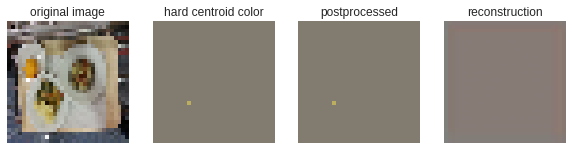

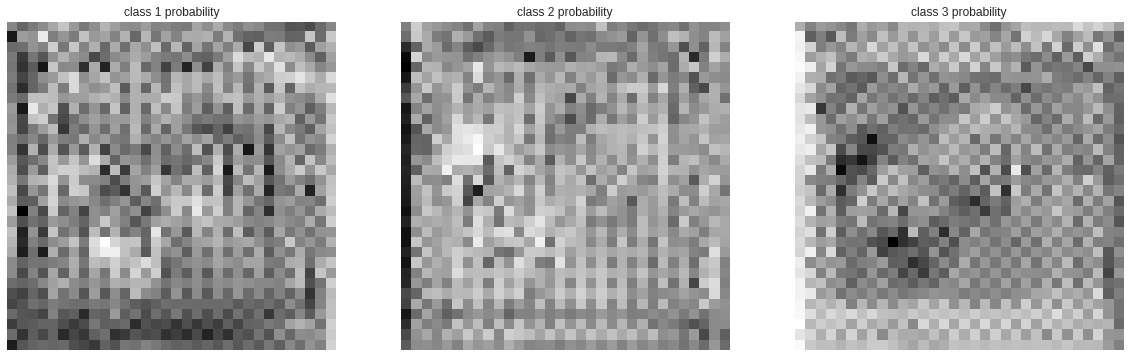

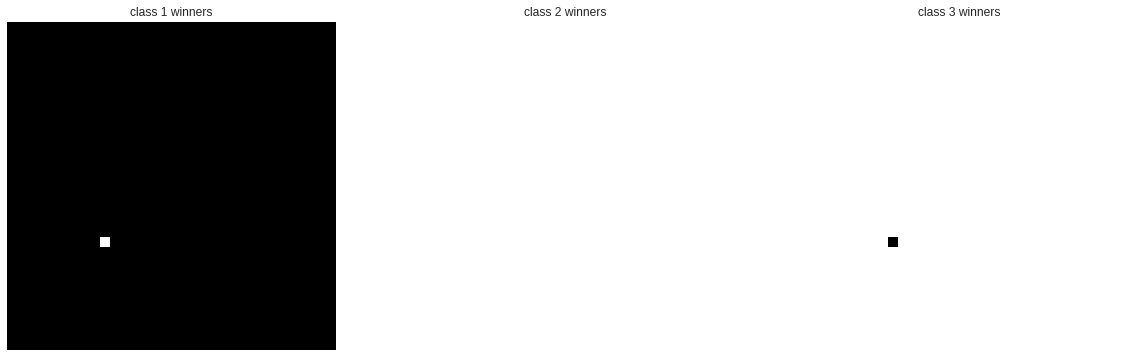

20


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


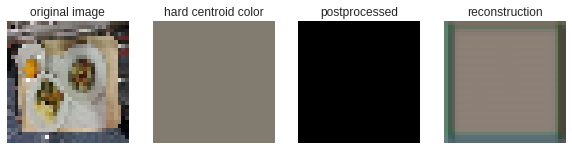

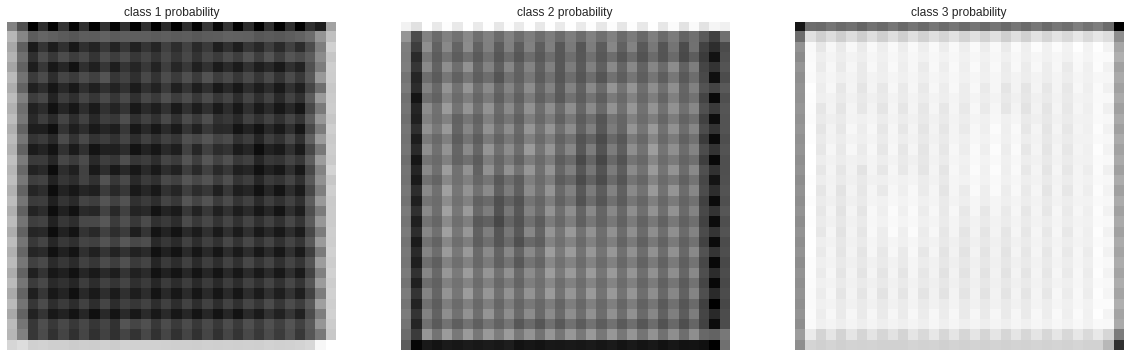

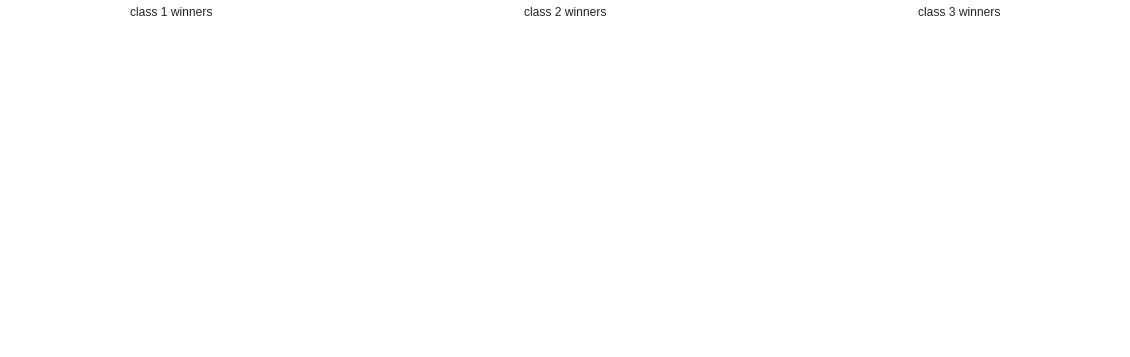

40


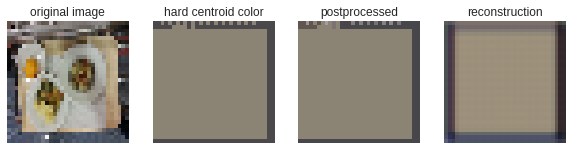

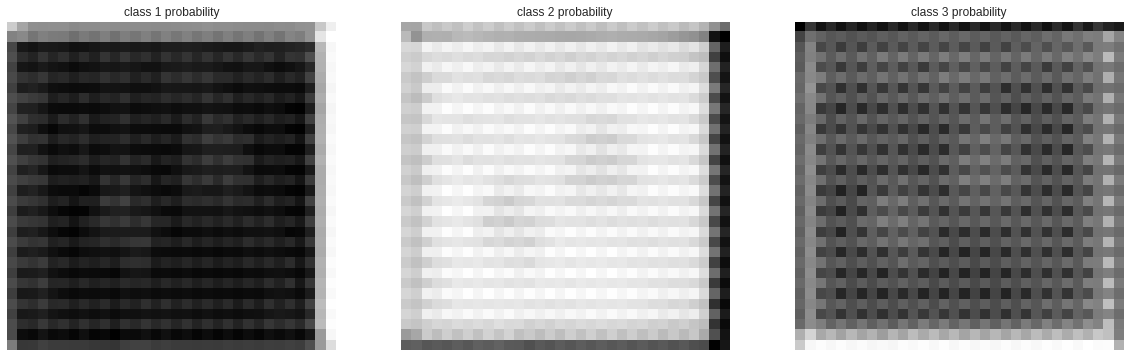

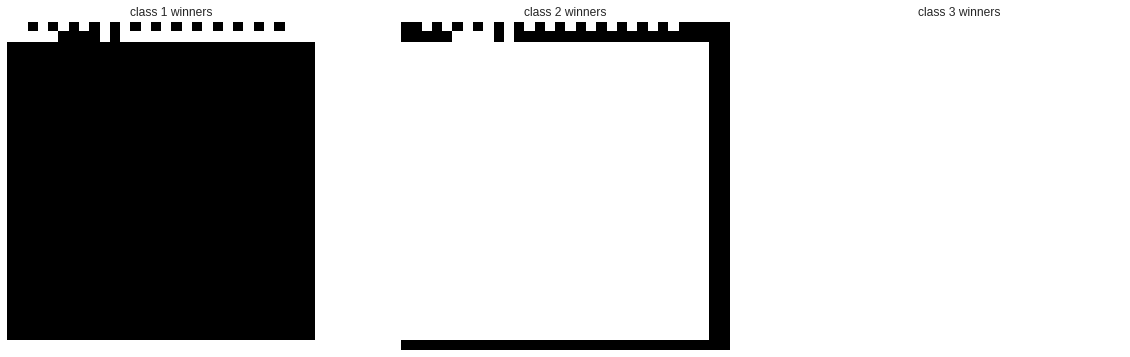

60


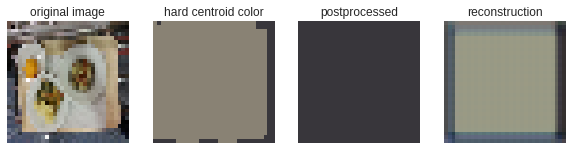

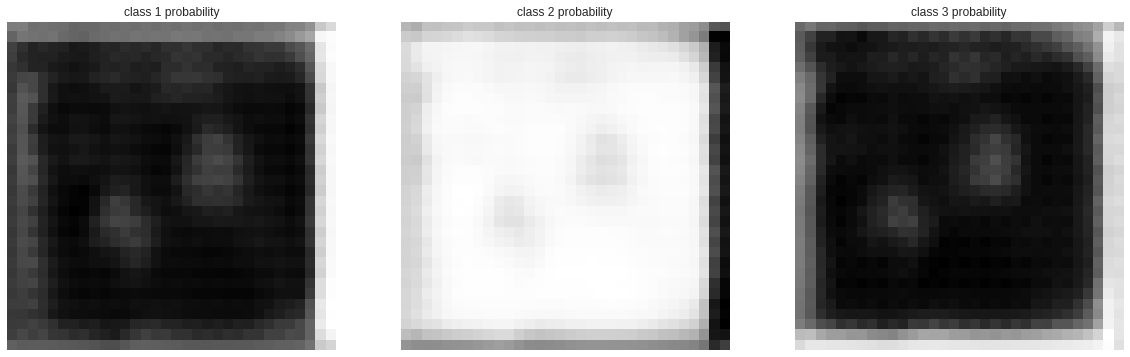

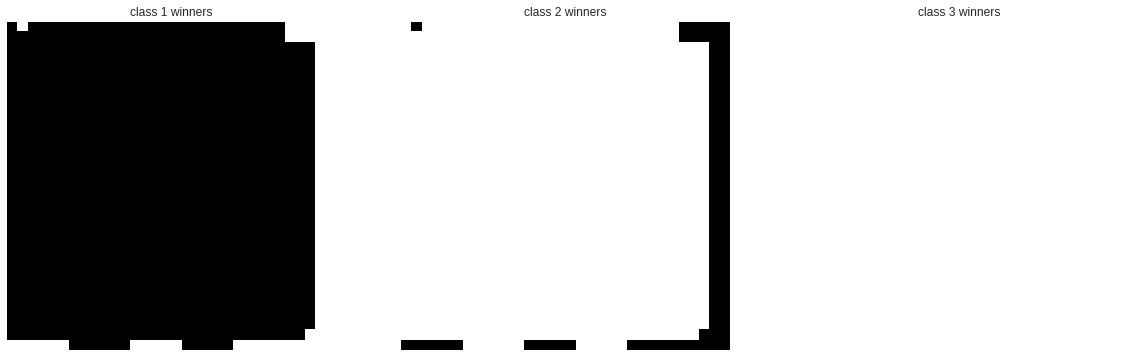

80


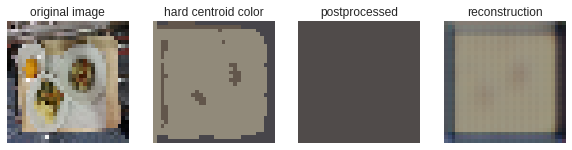

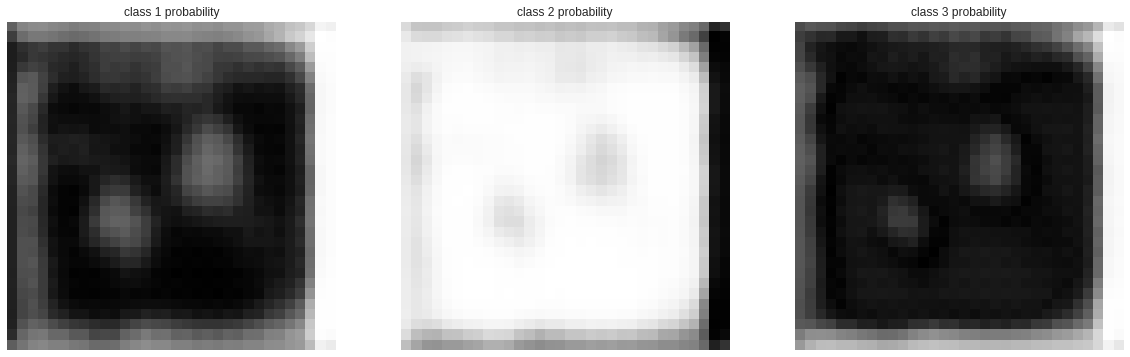

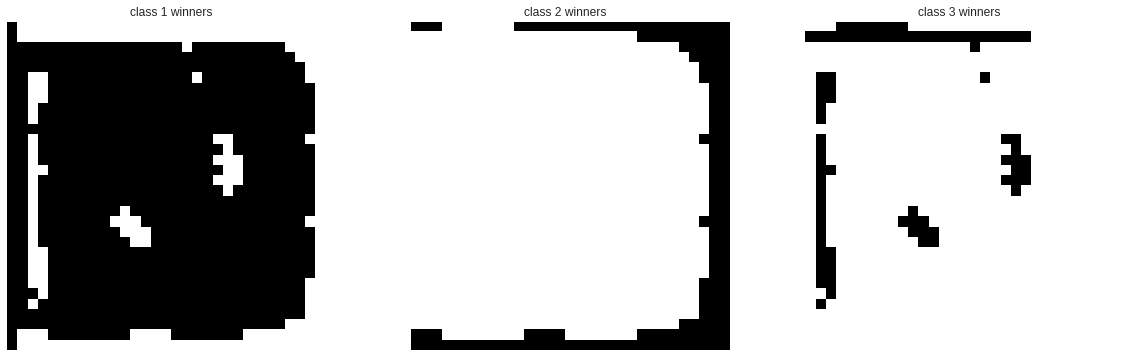

100


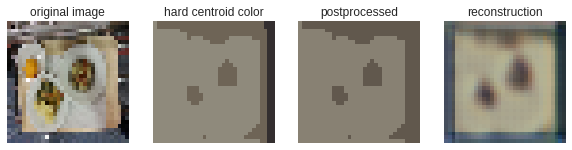

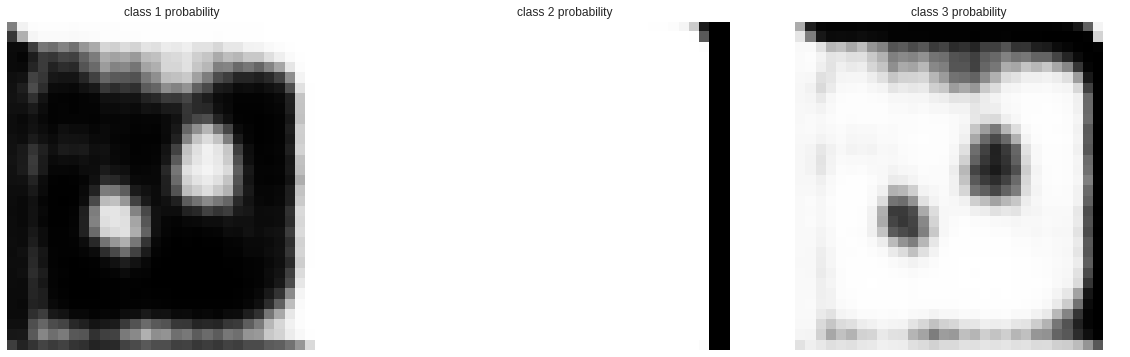

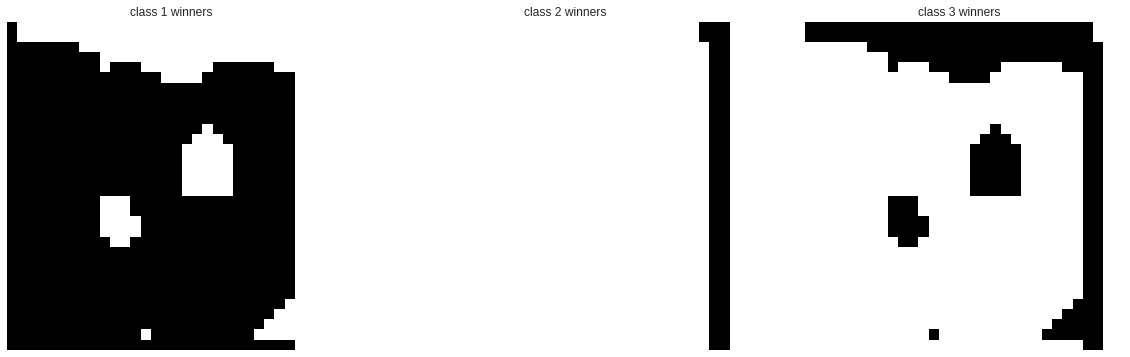

120


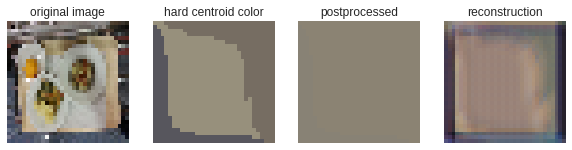

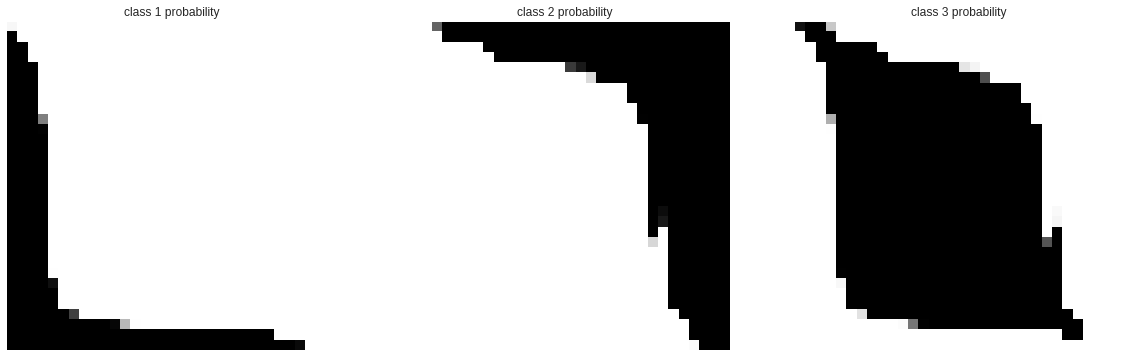

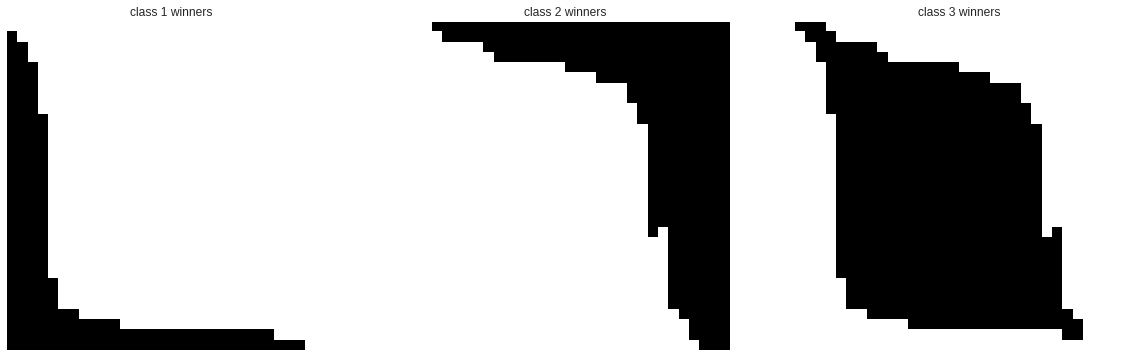

140


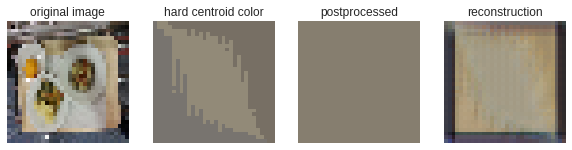

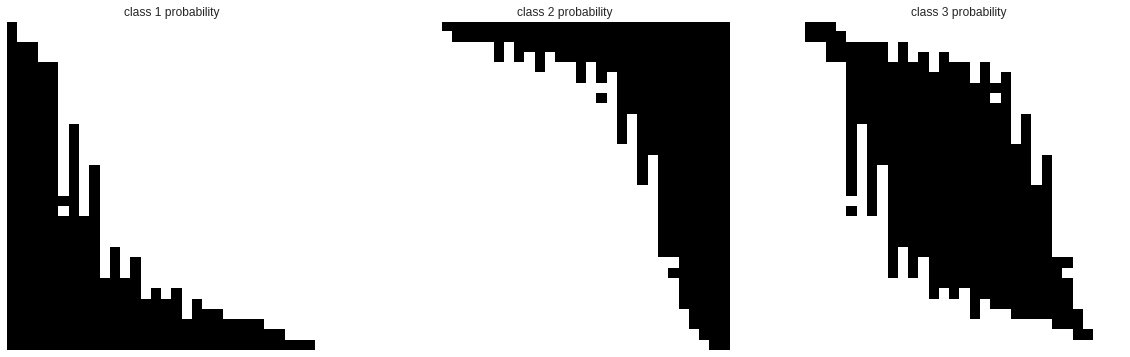

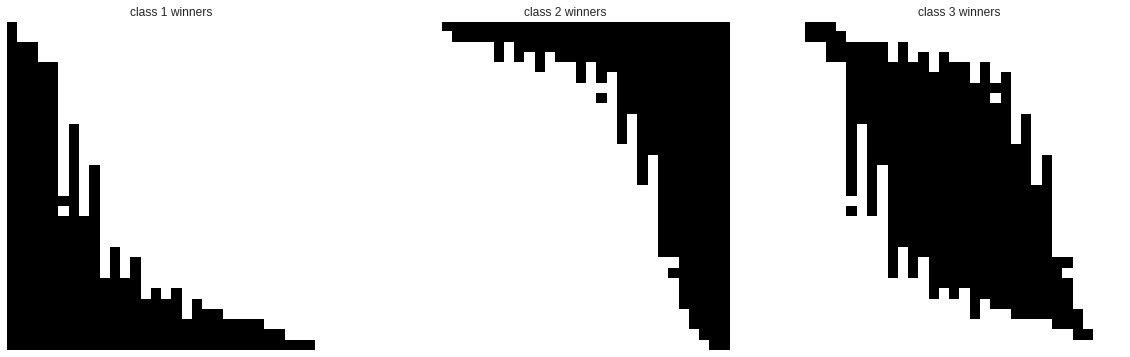

160


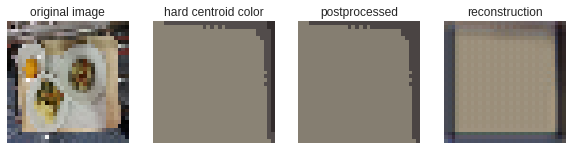

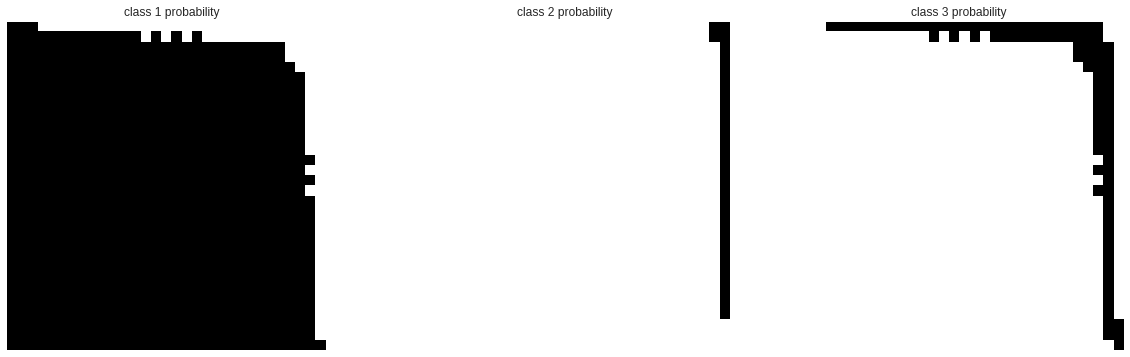

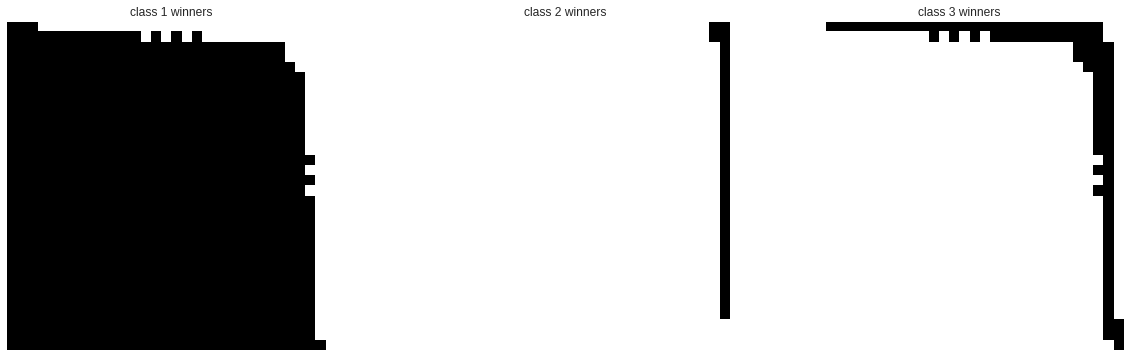

180


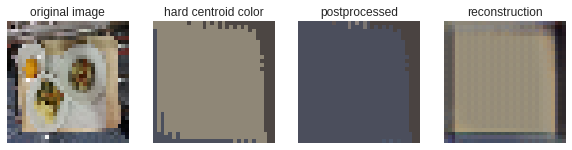

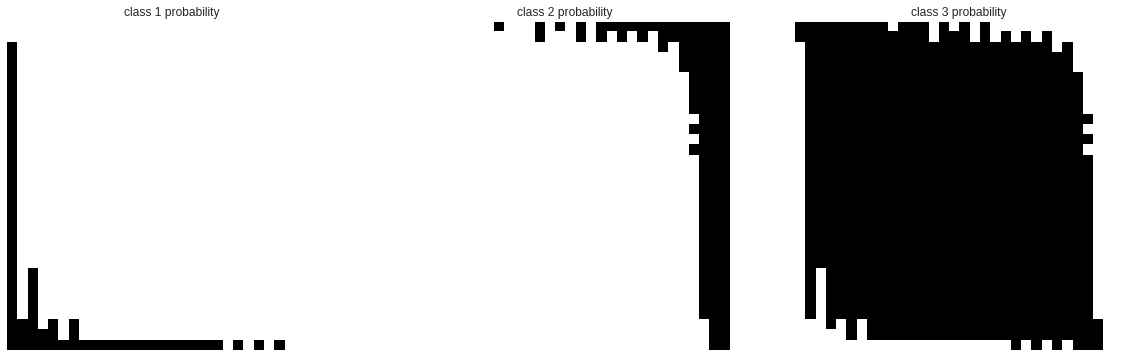

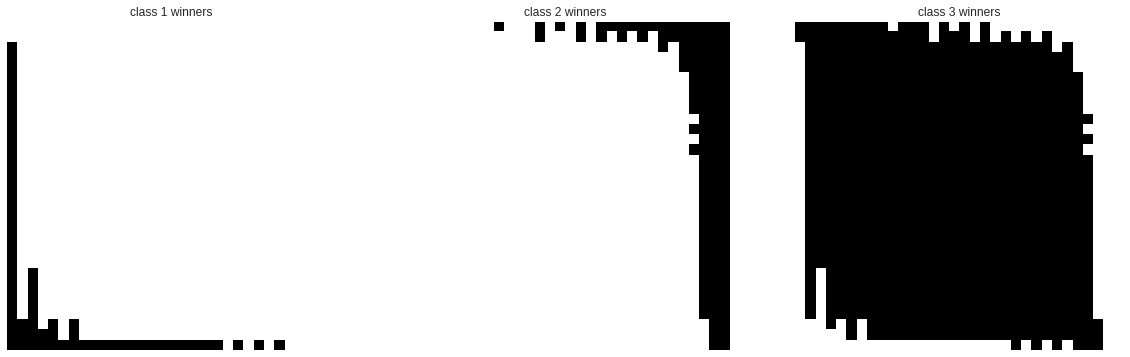

200


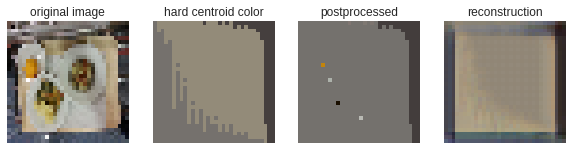

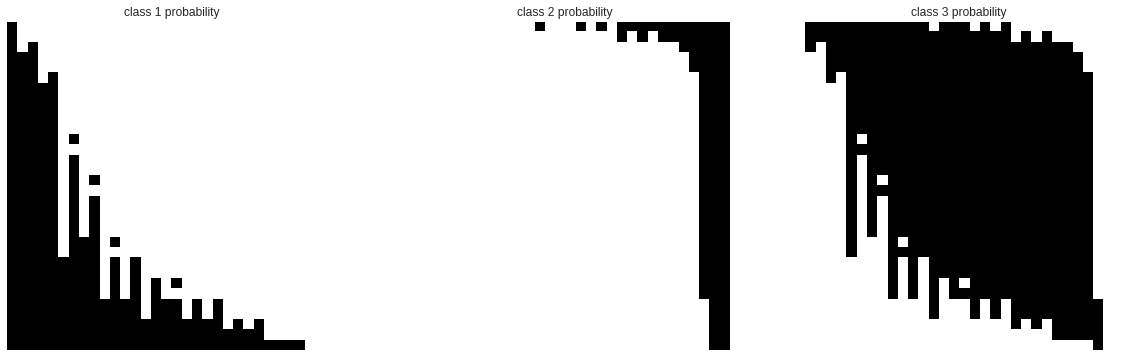

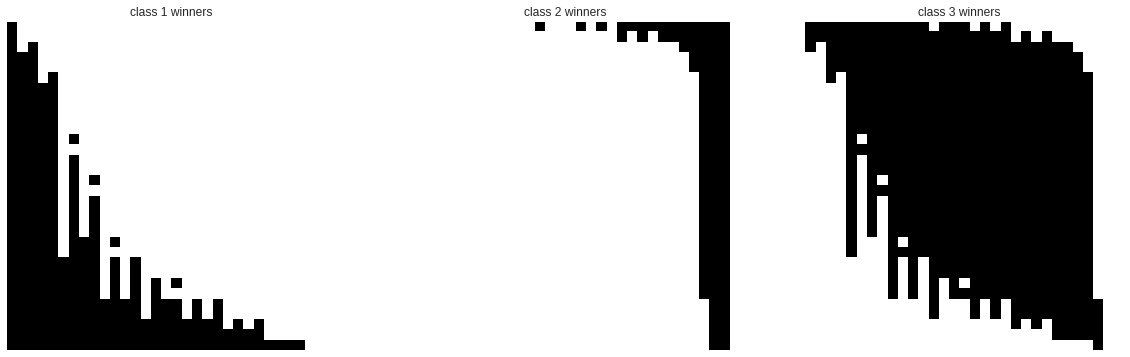

220


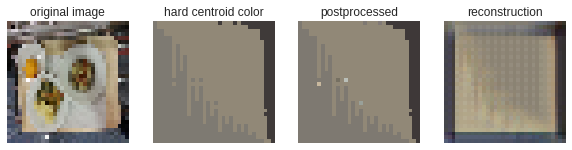

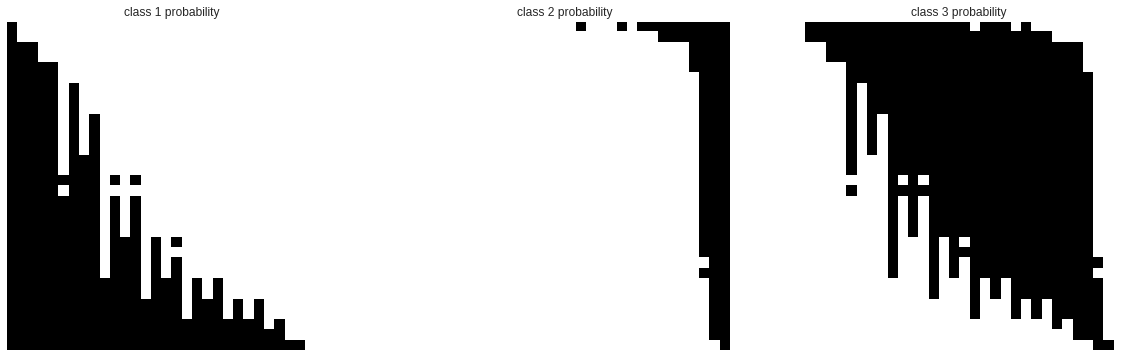

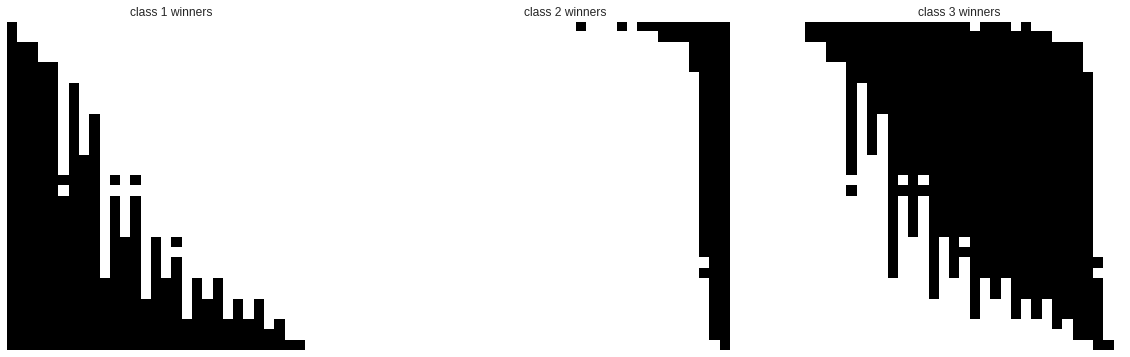

240


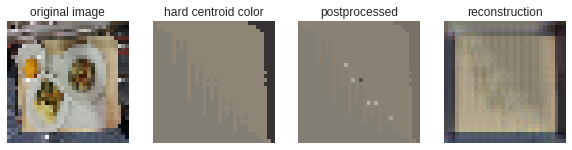

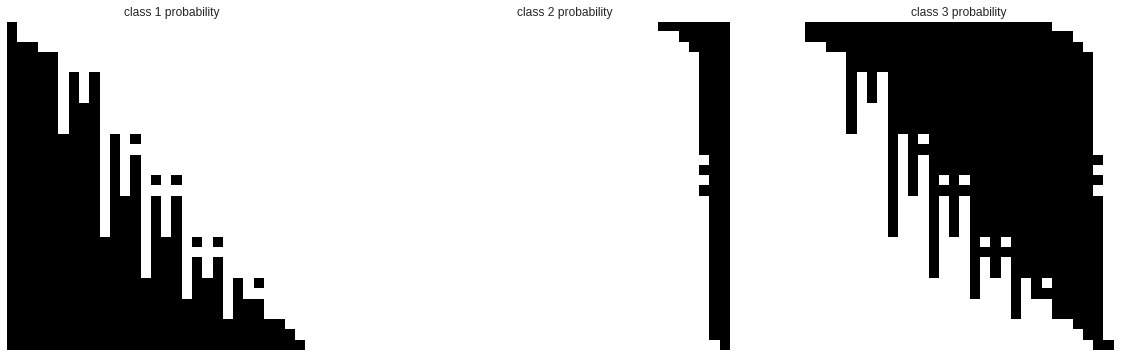

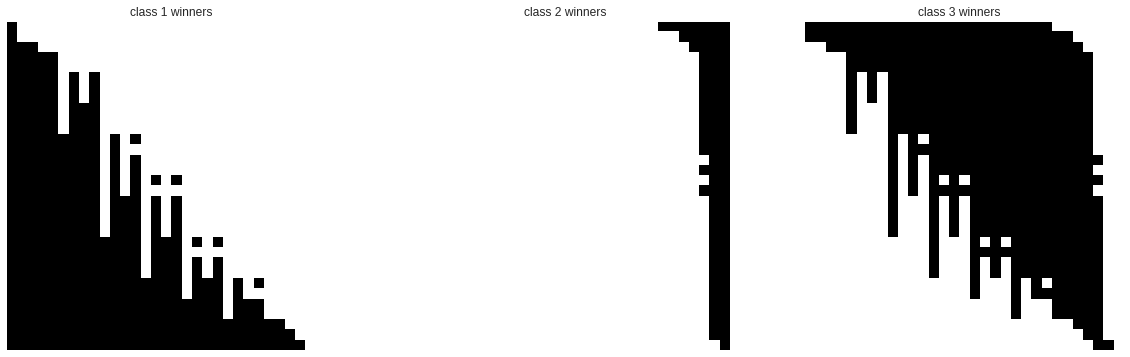

260


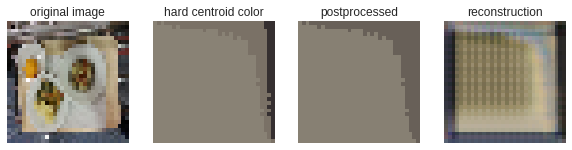

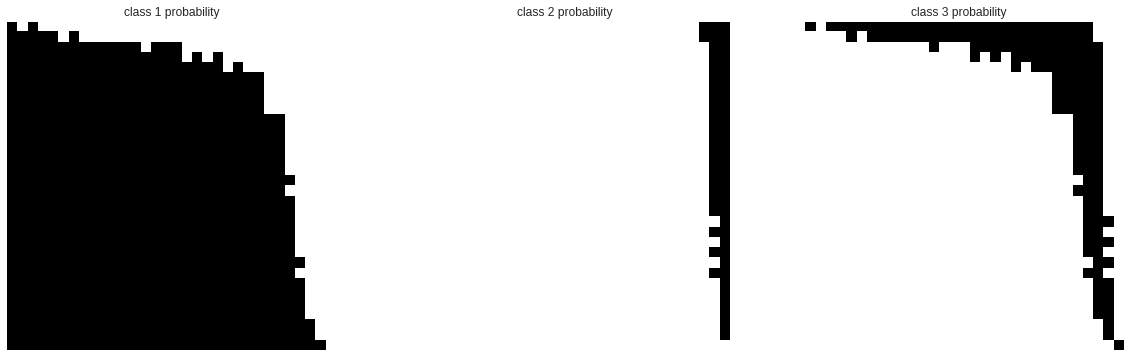

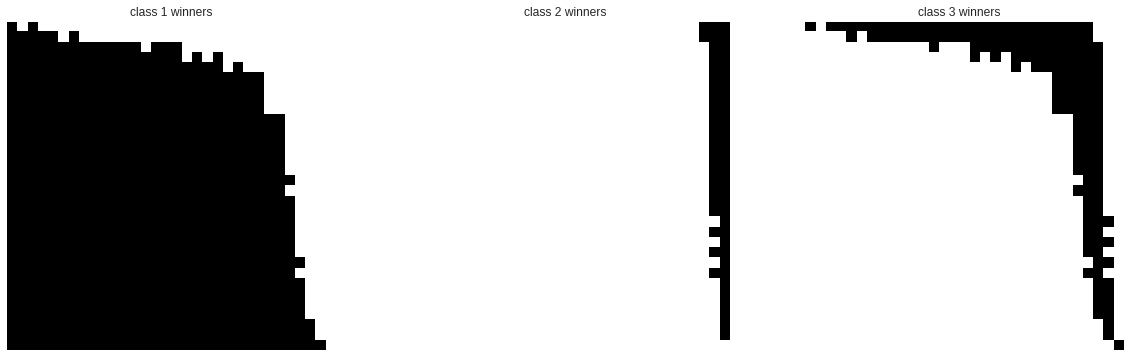

280


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


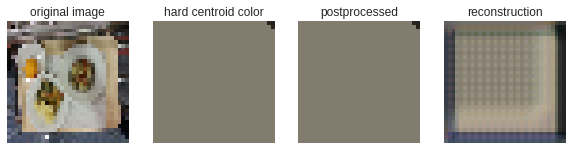

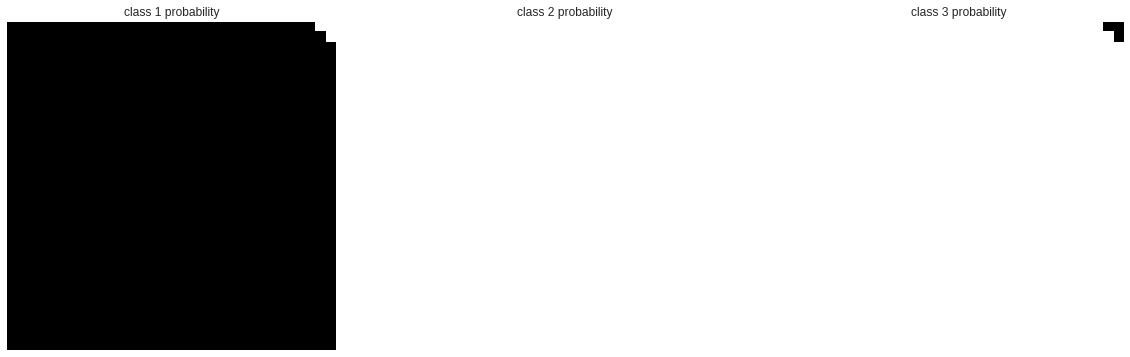

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


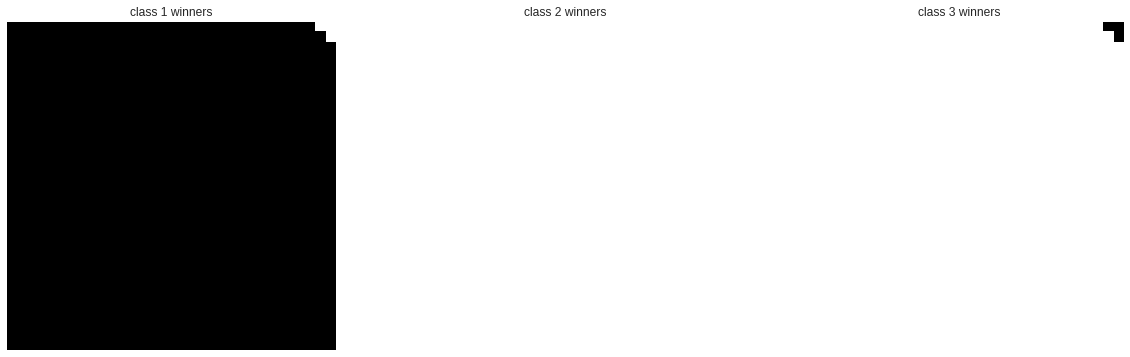

300


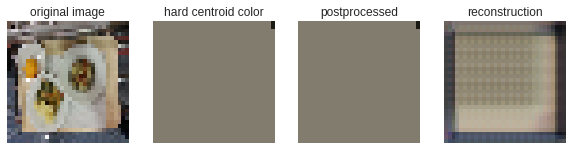

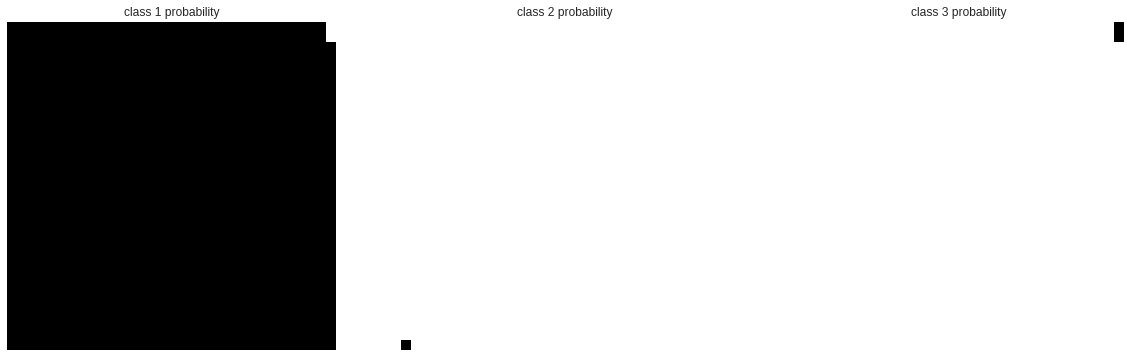

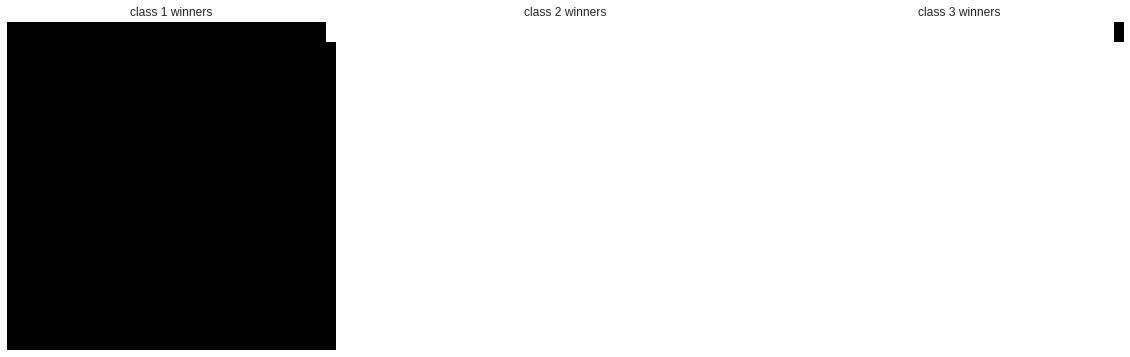

320


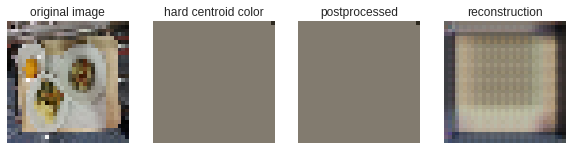

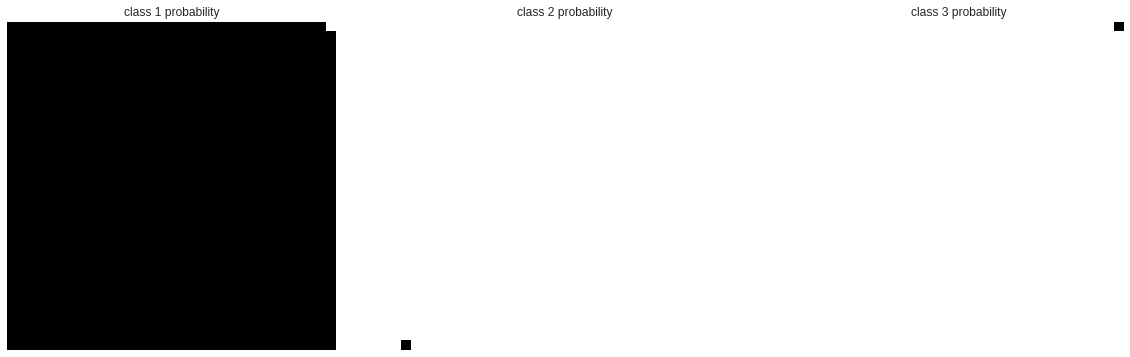

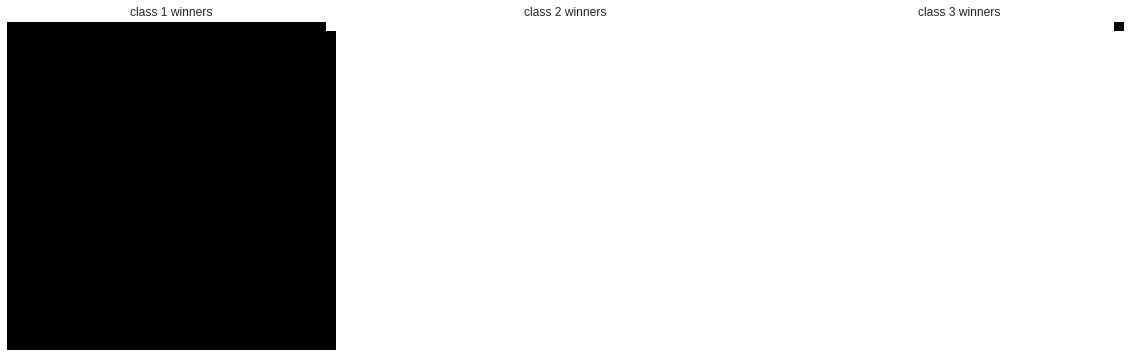

340


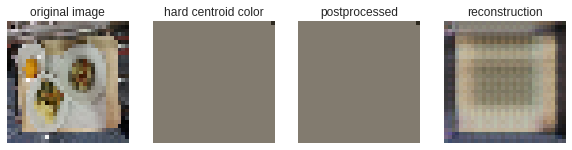

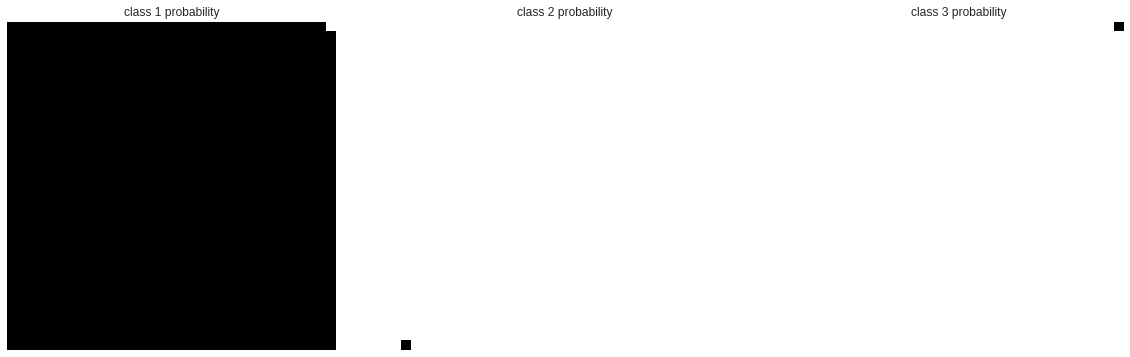

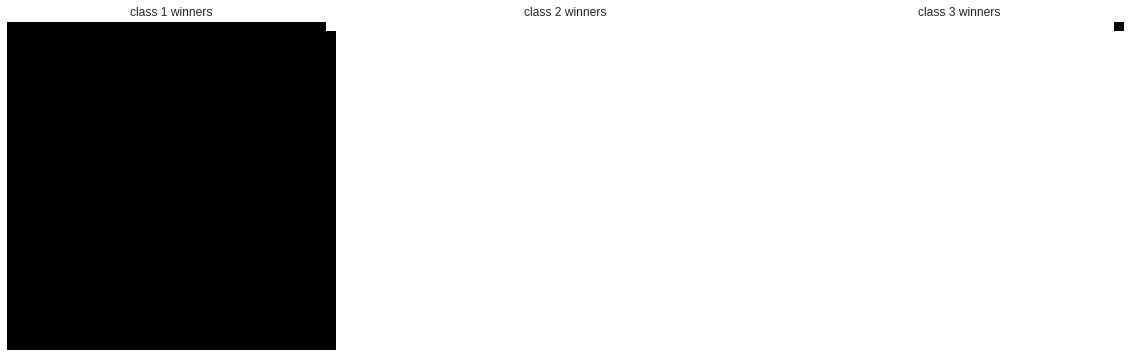

360


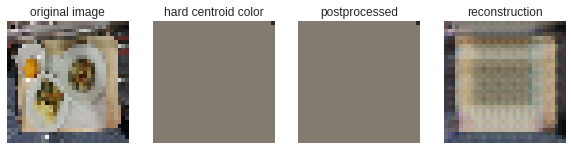

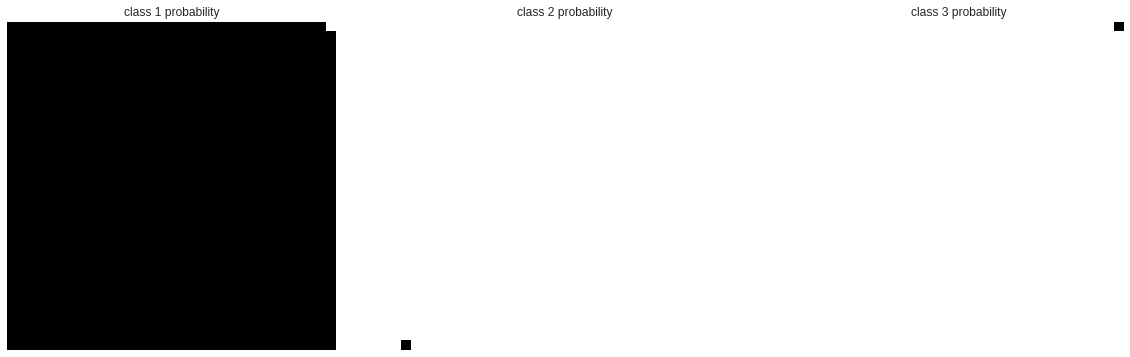

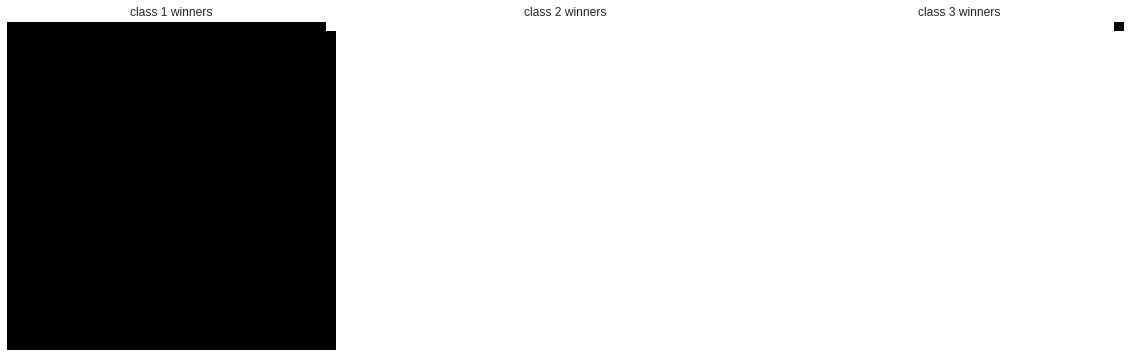

380


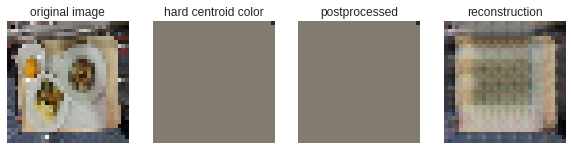

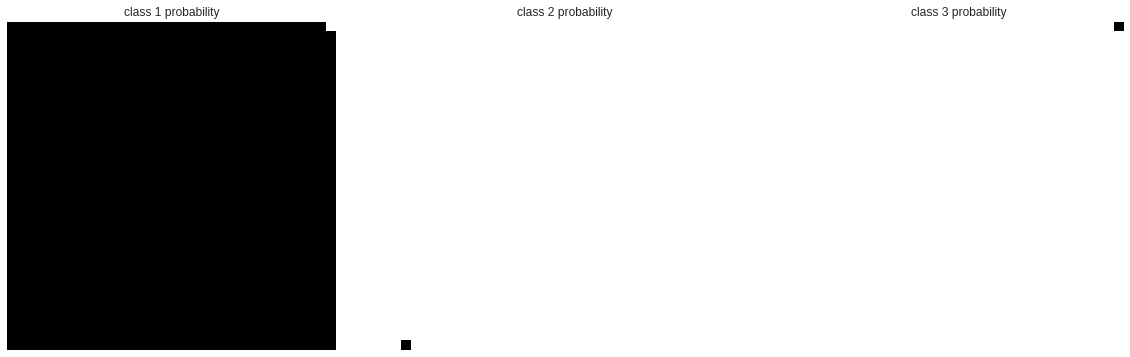

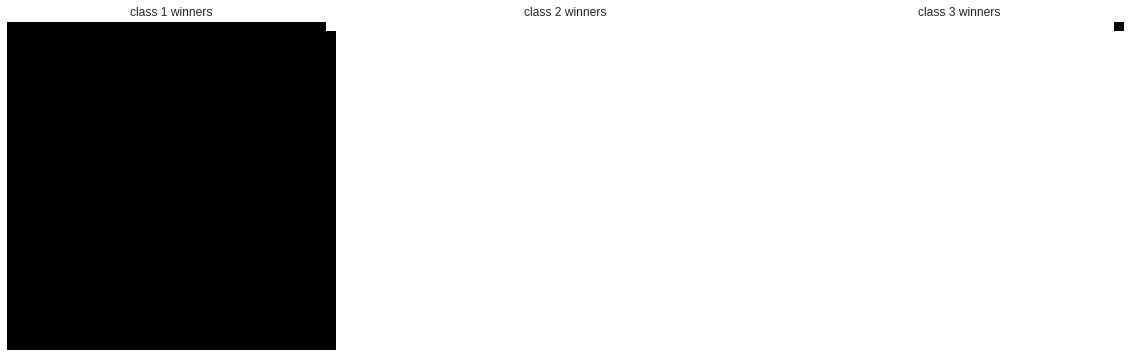

400


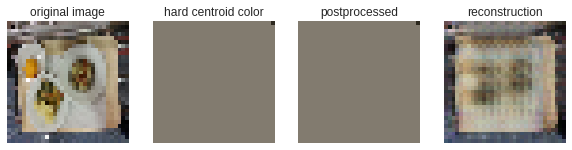

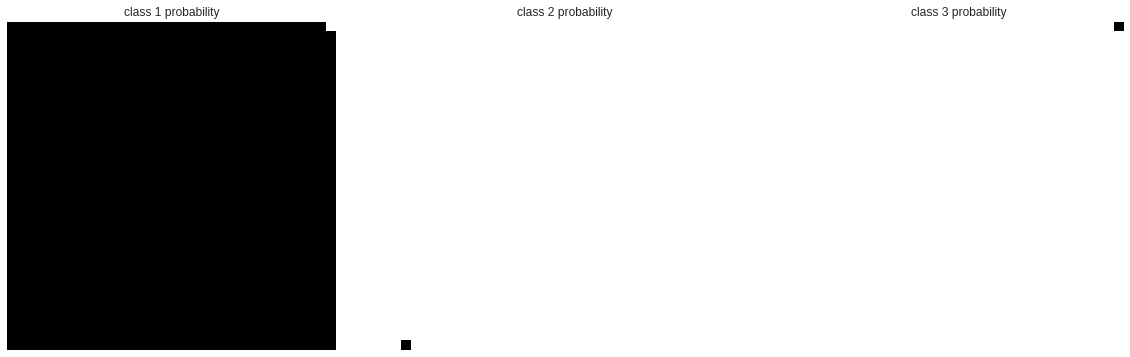

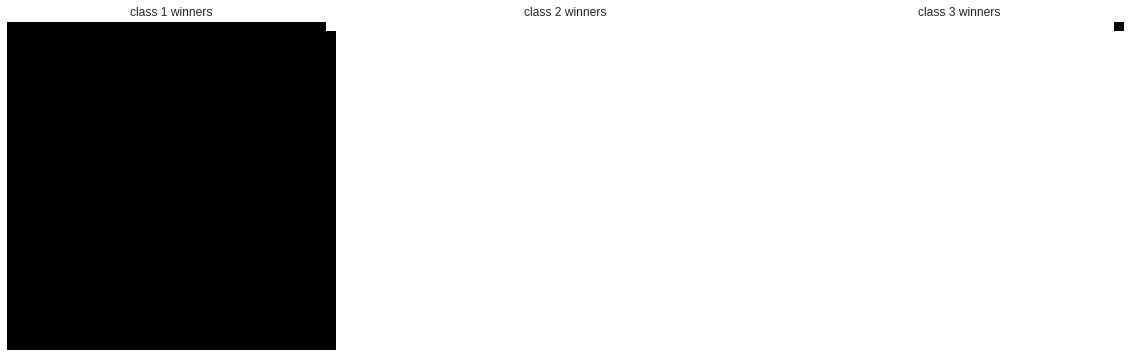

420


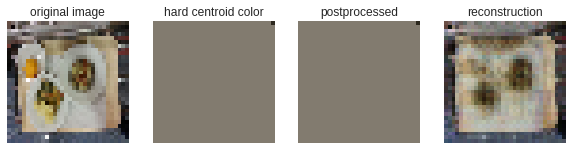

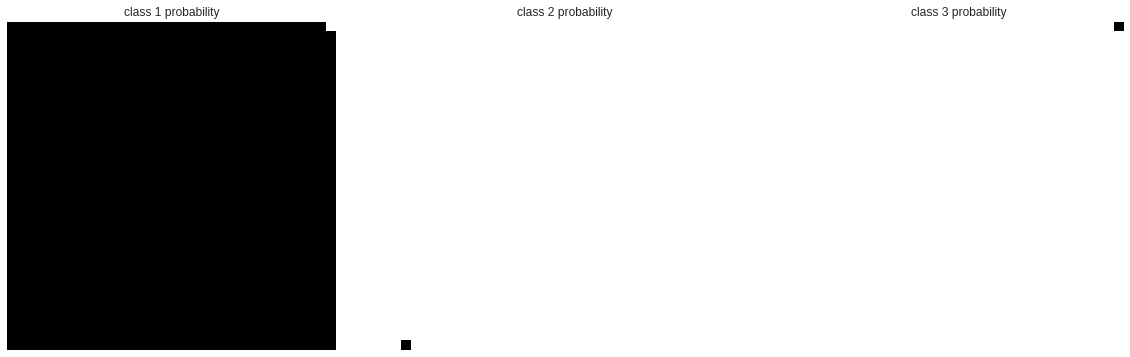

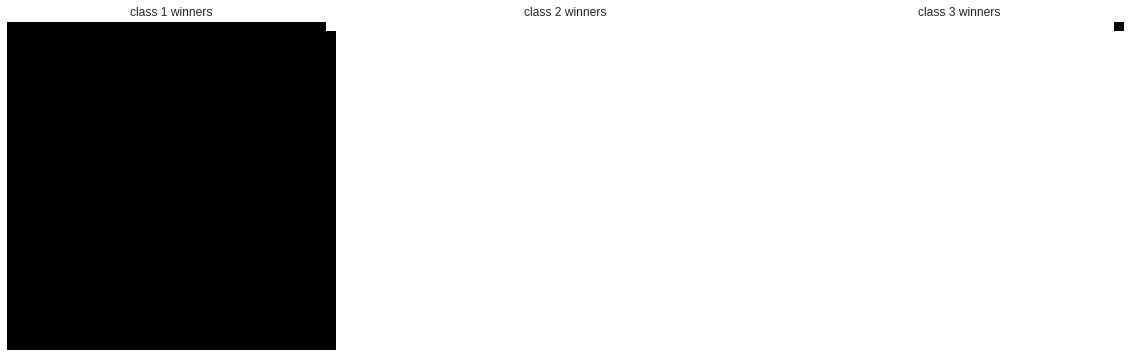

440


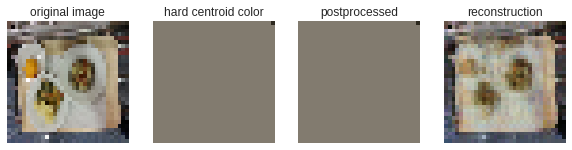

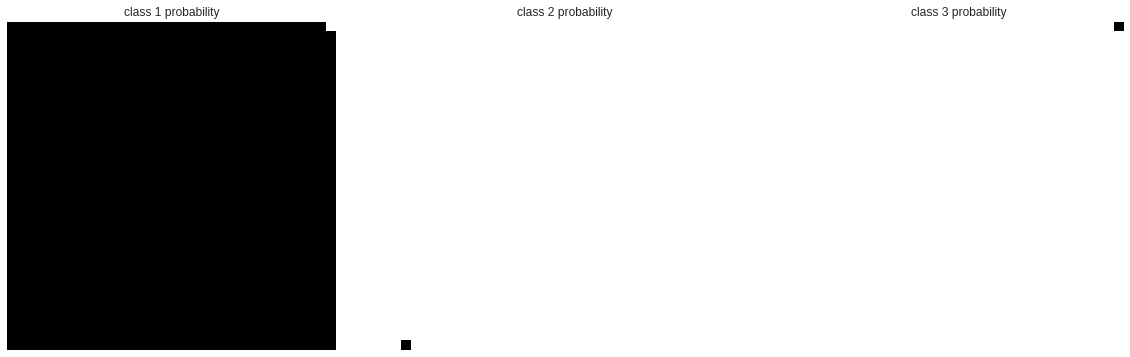

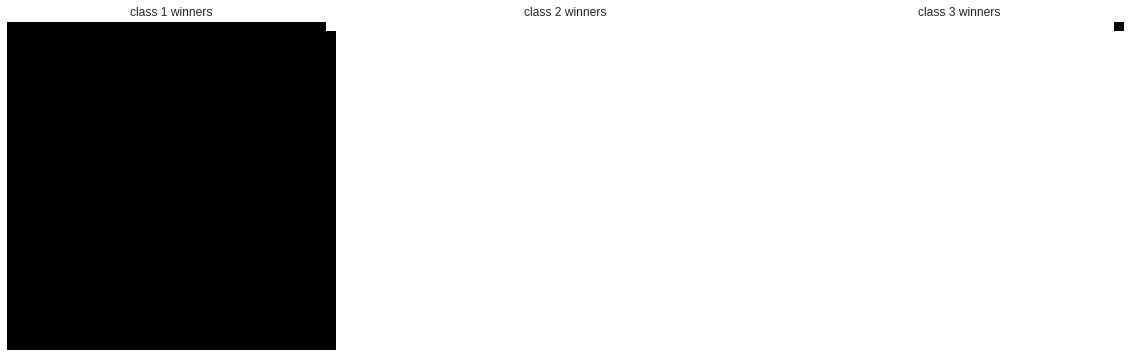

460


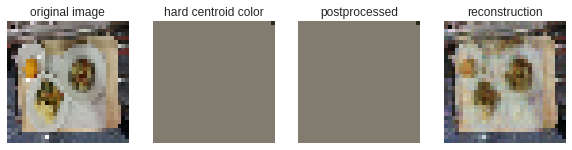

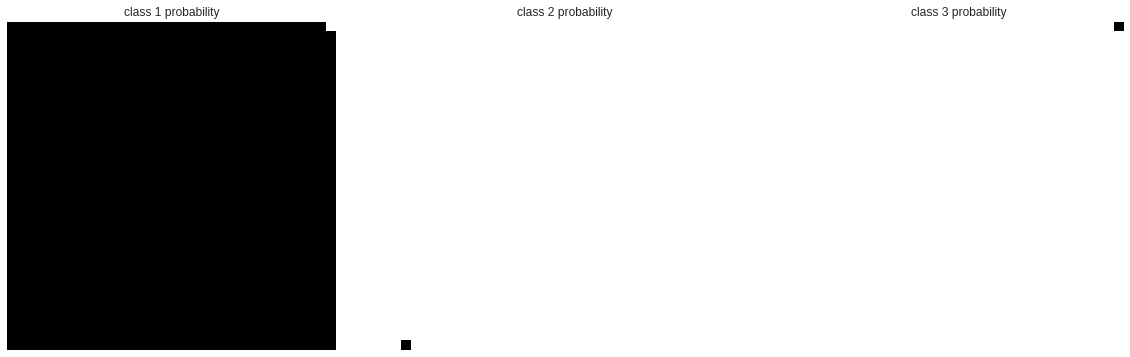

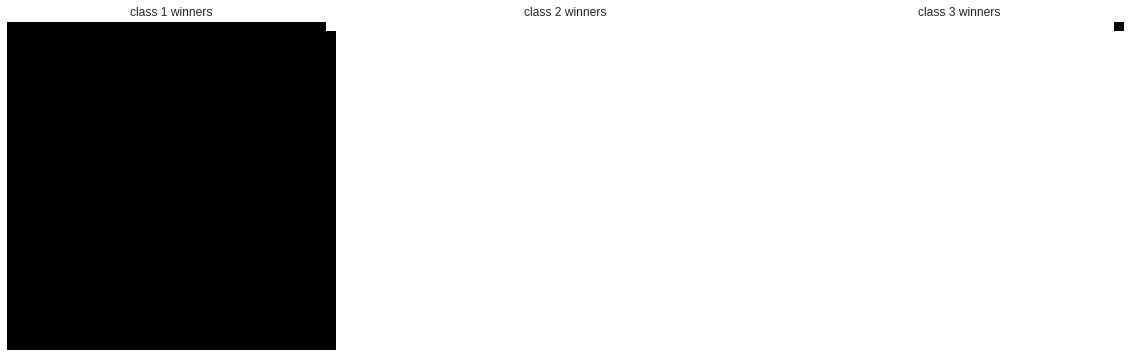

480


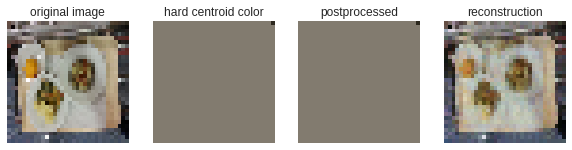

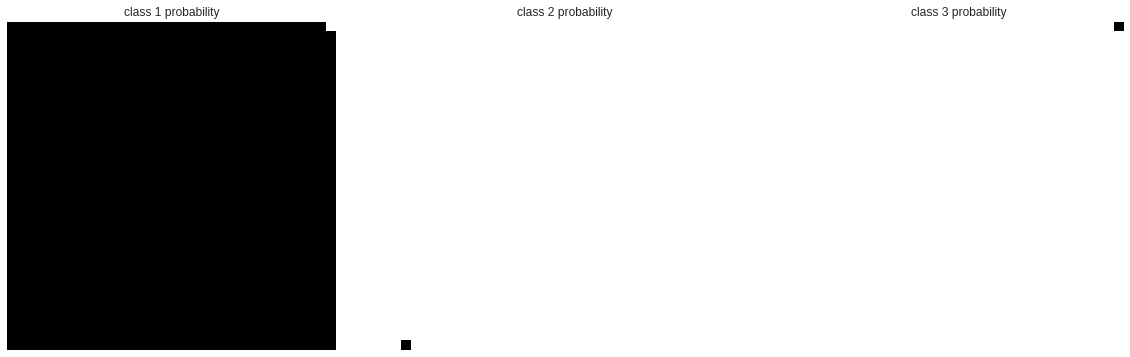

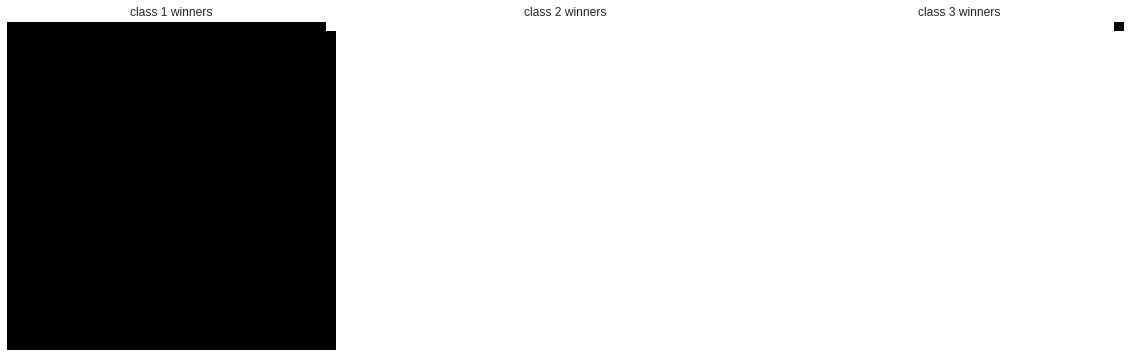

500


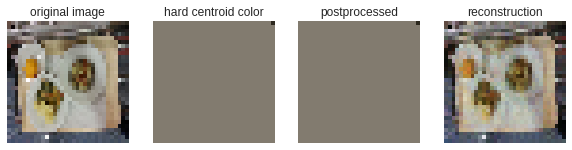

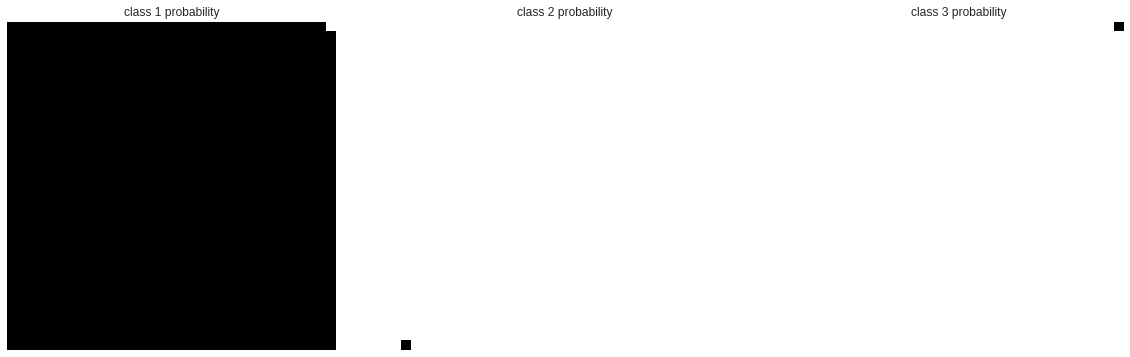

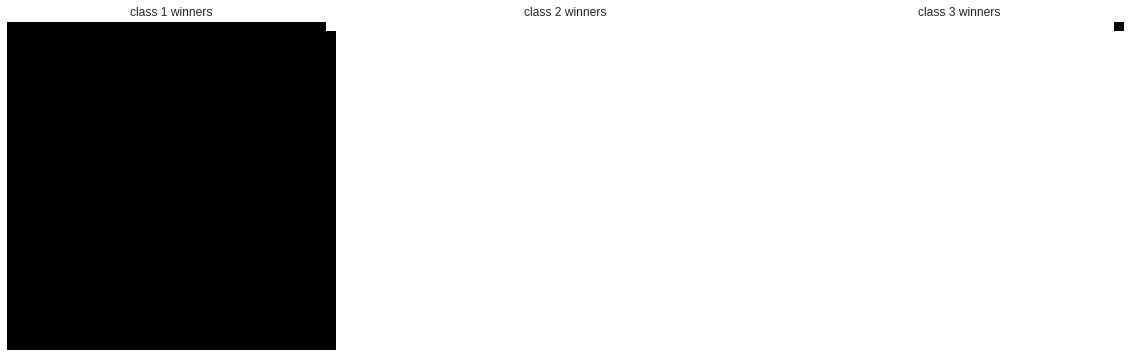

520


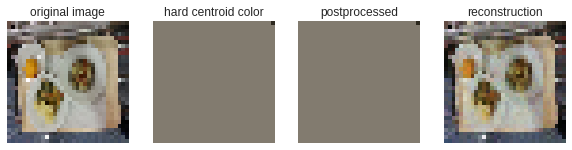

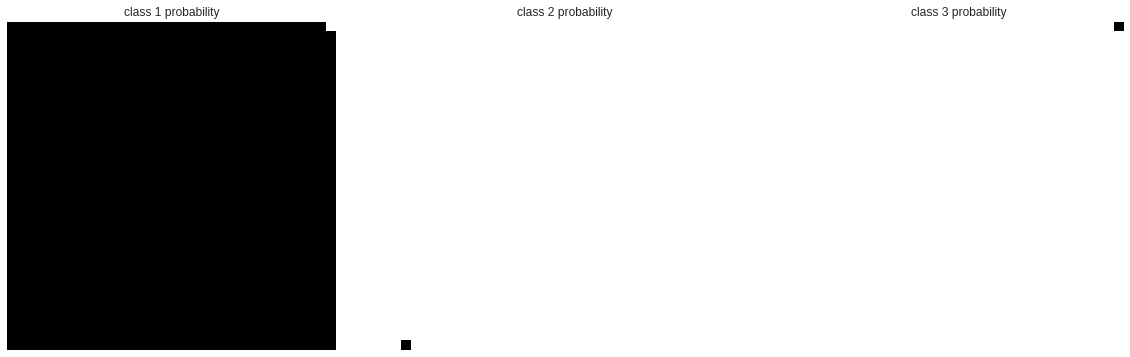

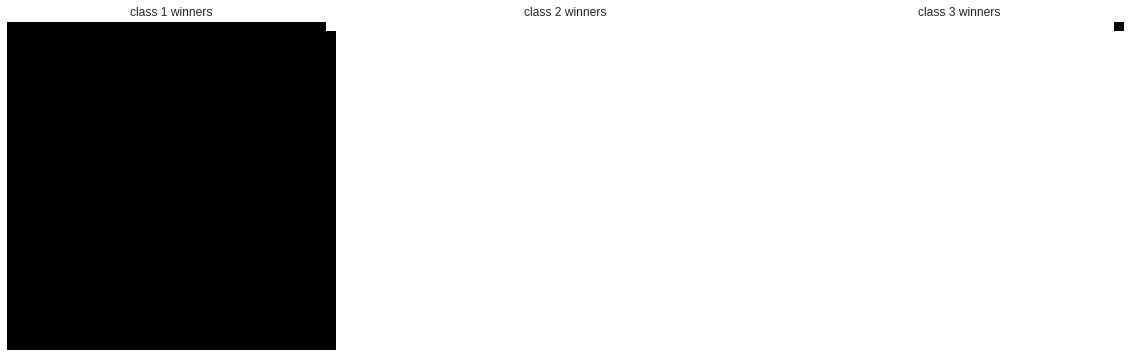

540


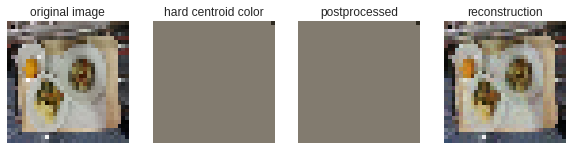

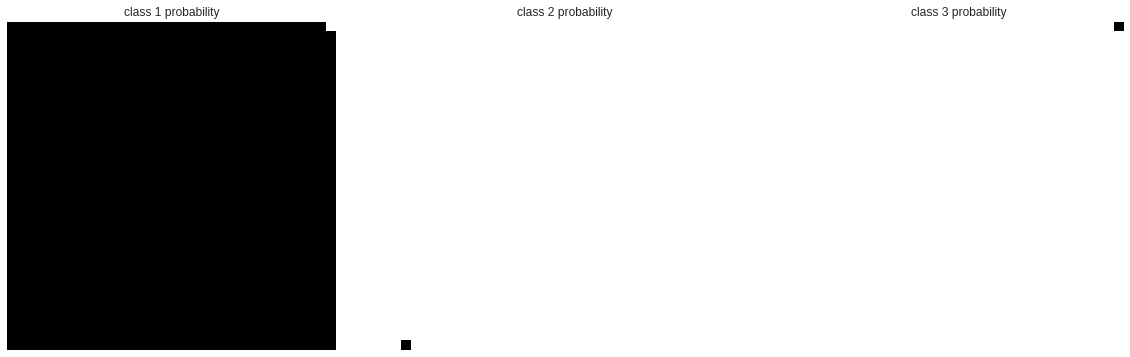

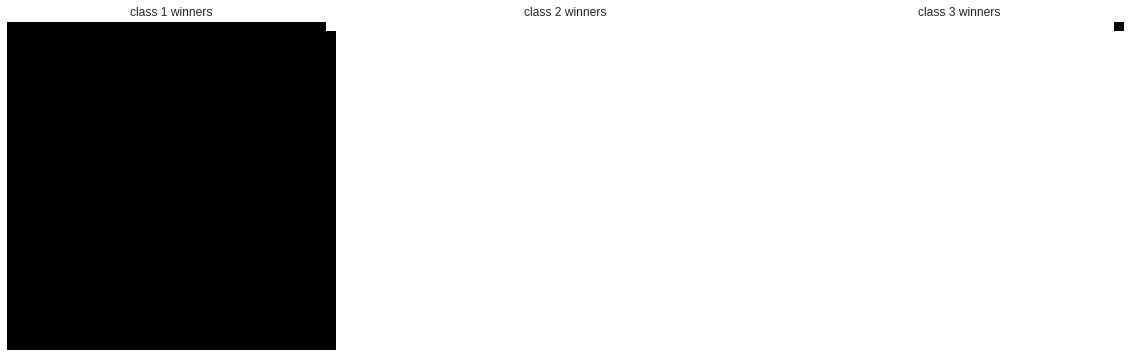

560


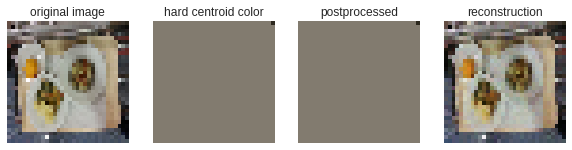

KeyboardInterrupt: ignored

In [14]:
for i in range(1000):
  history = w_net.fit(train_img[:,:,:,:3],[train_img, train_img[:,:,:,:3]],epochs=1, batch_size=1,verbose=0)
  y_s=w_net.predict(train_img[:,:,:,:3],batch_size=1,verbose=0)
  segm = y_s[0][0]
  rec = y_s[1][0]
  if i%20==0:
    print(i)
    paints(img[0],segm,rec)

0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


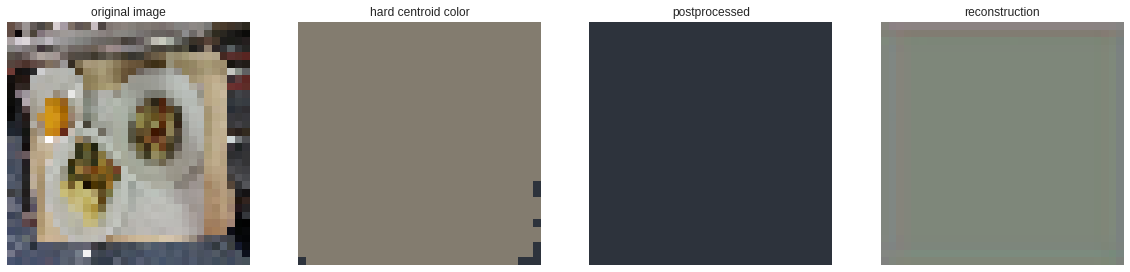

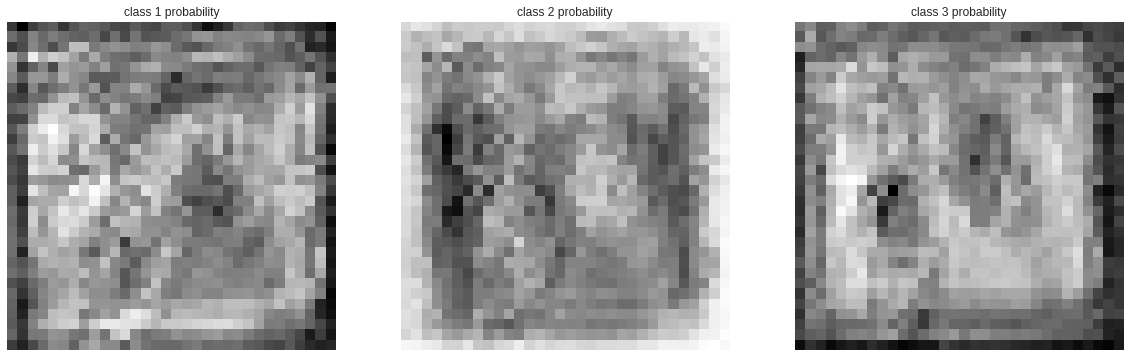

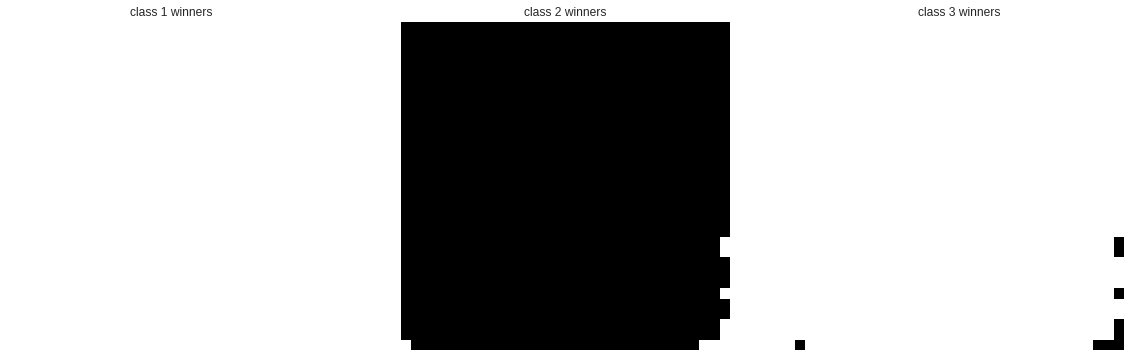

20


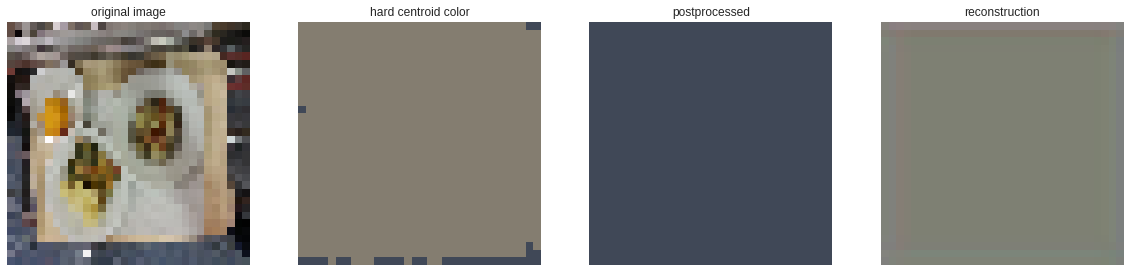

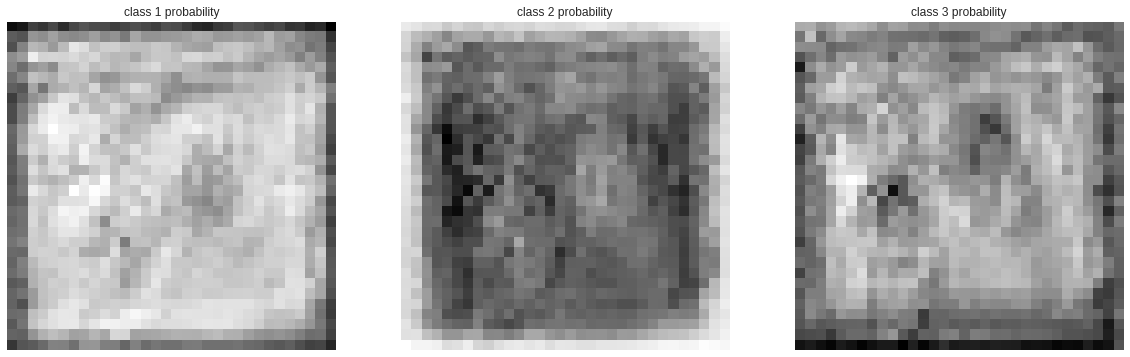

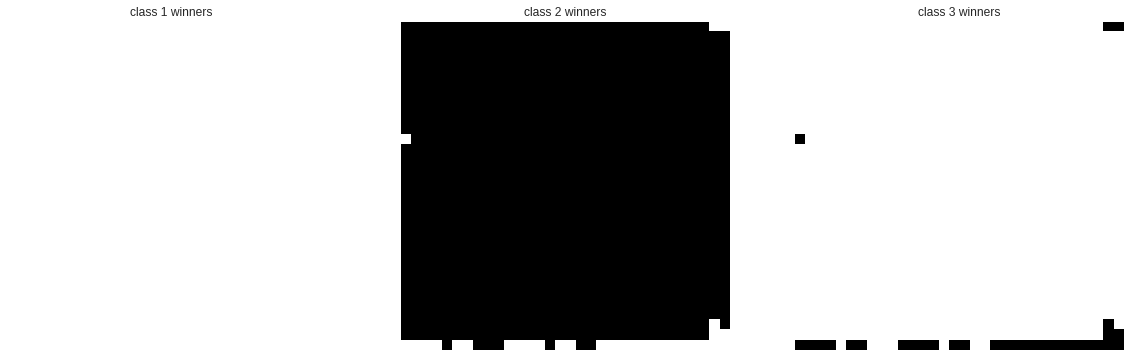

40


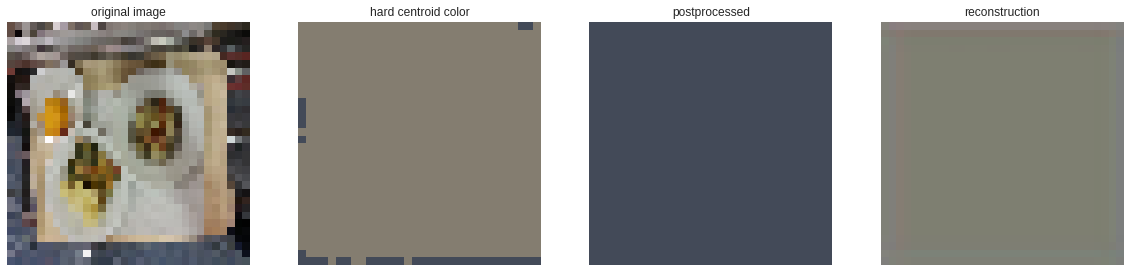

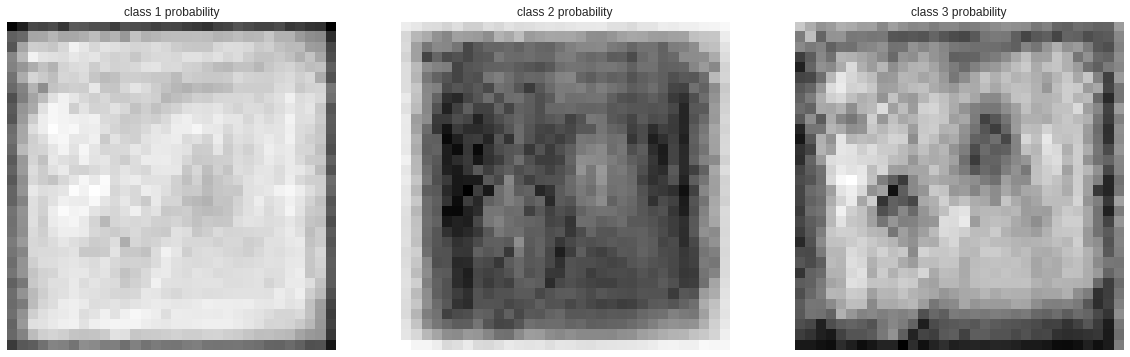

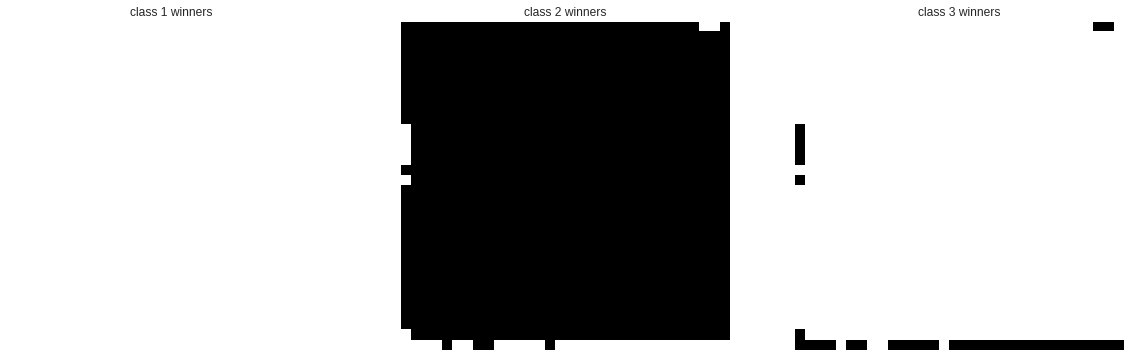

60


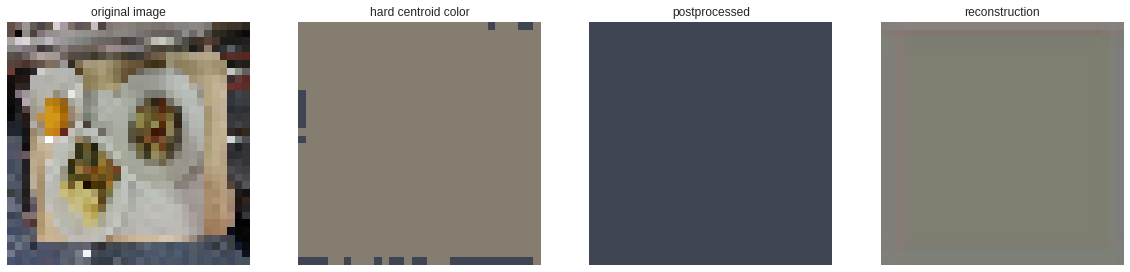

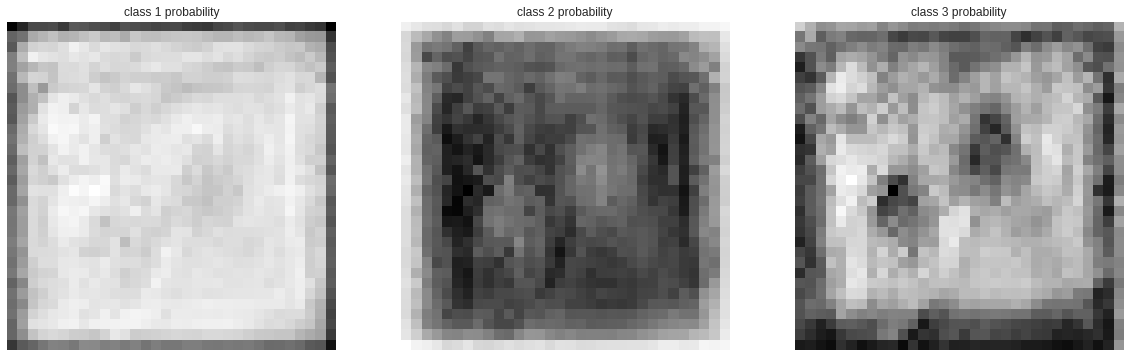

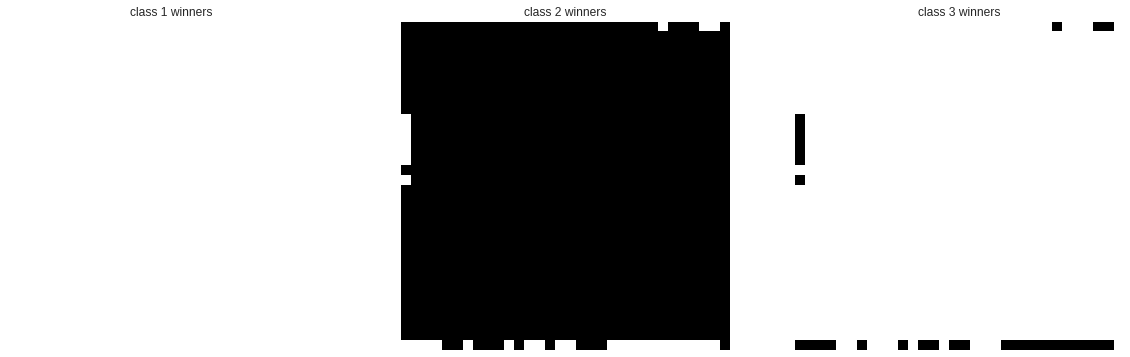

80


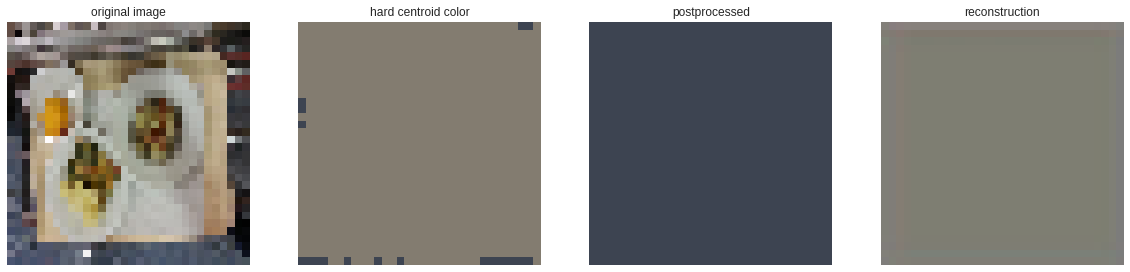

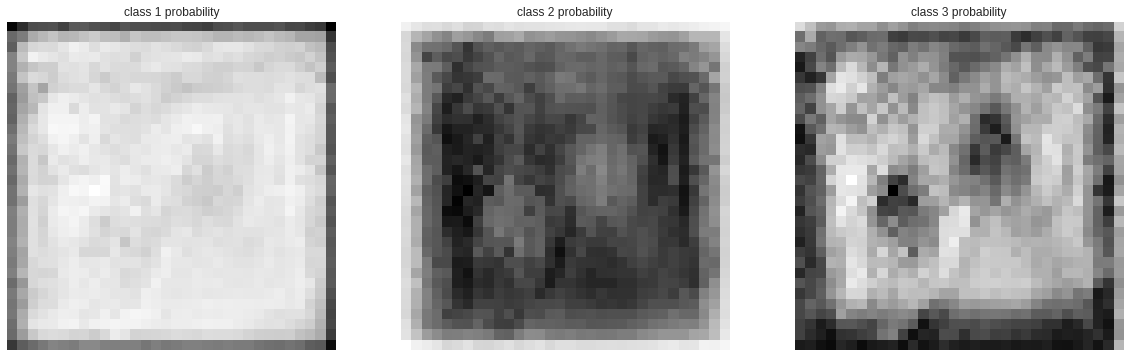

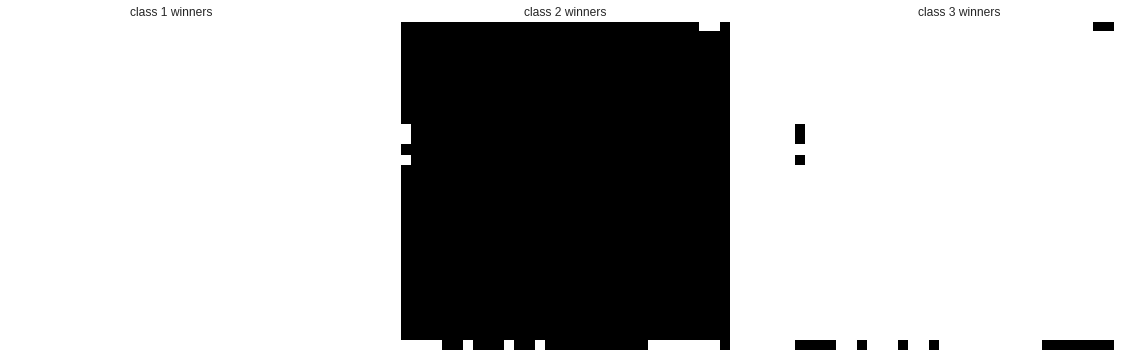

100


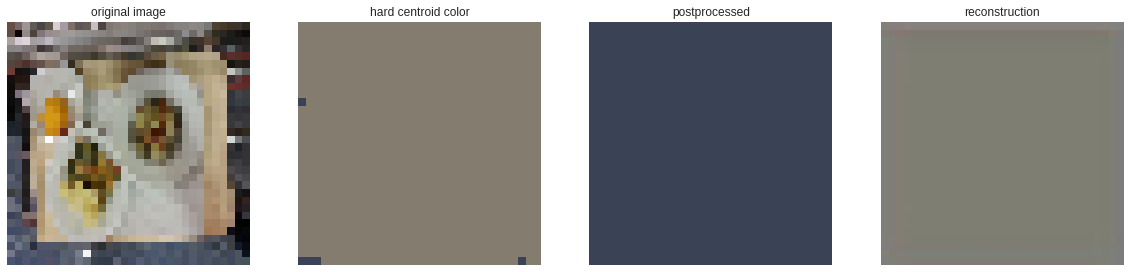

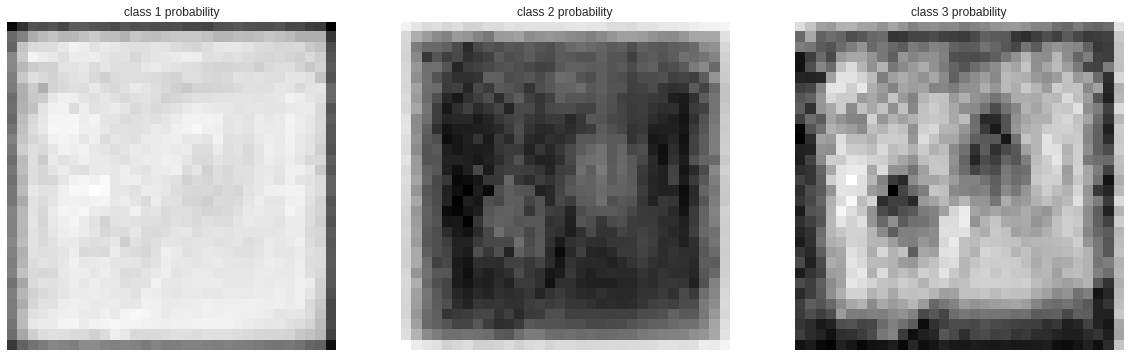

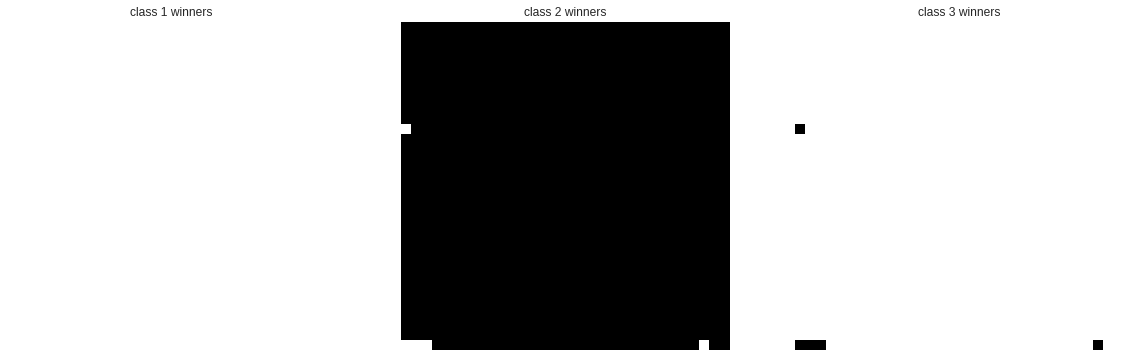

120


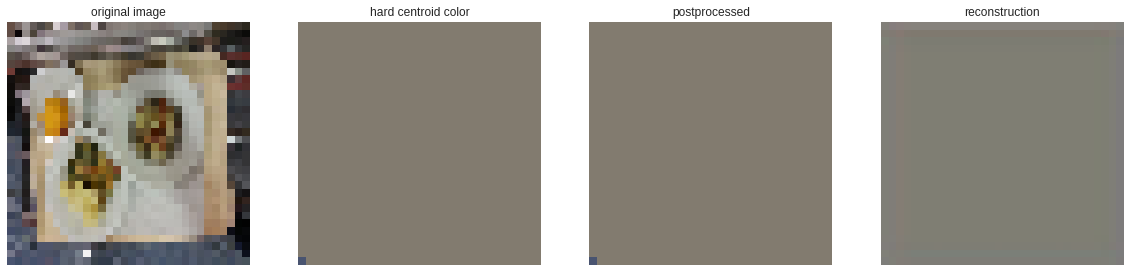

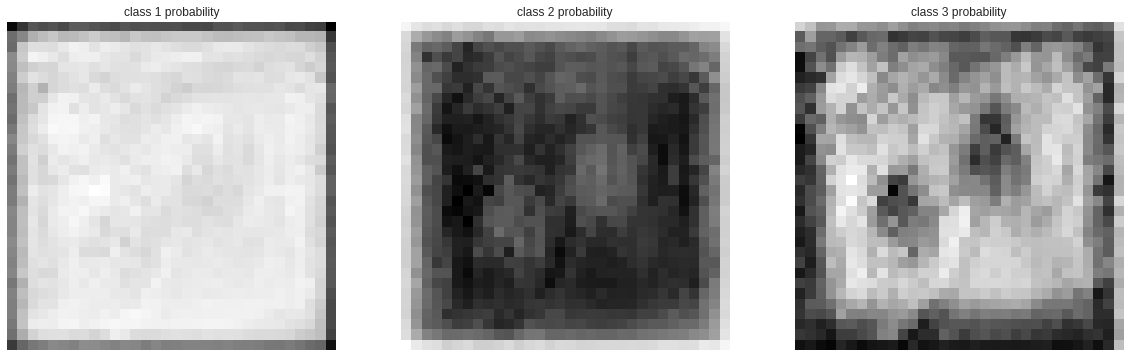

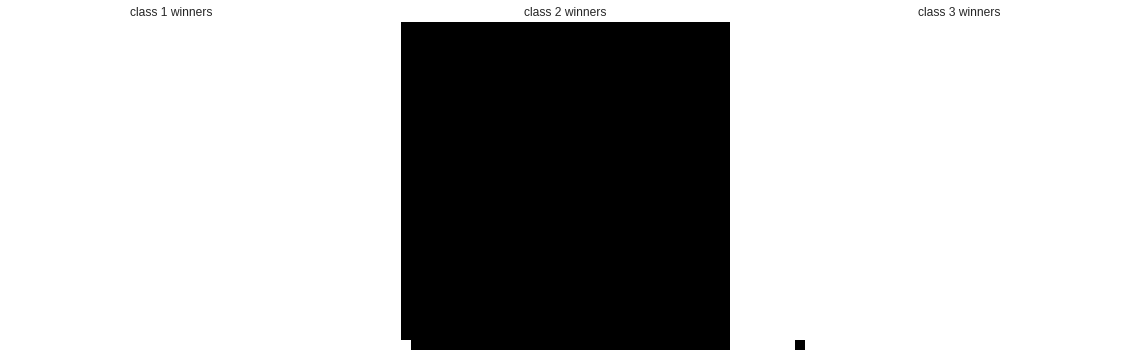

140


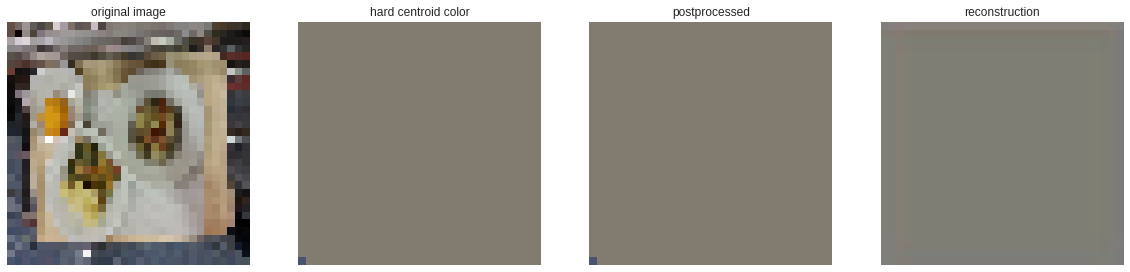

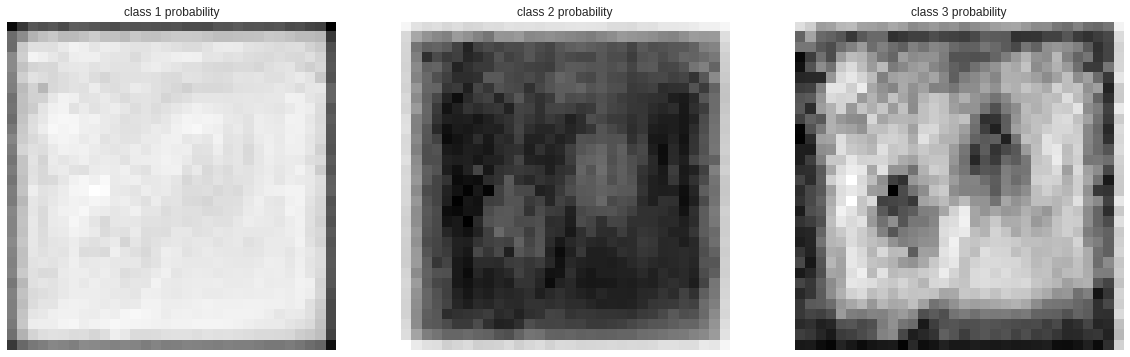

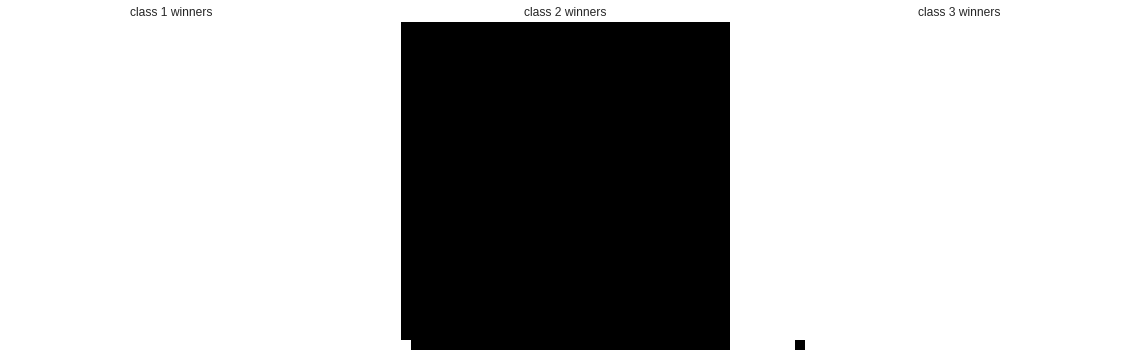

160


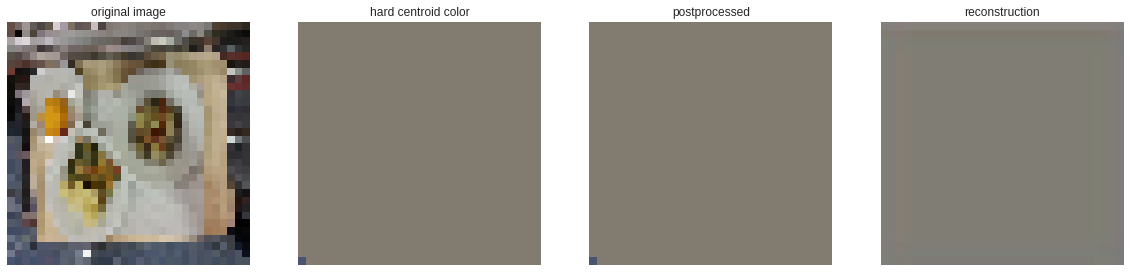

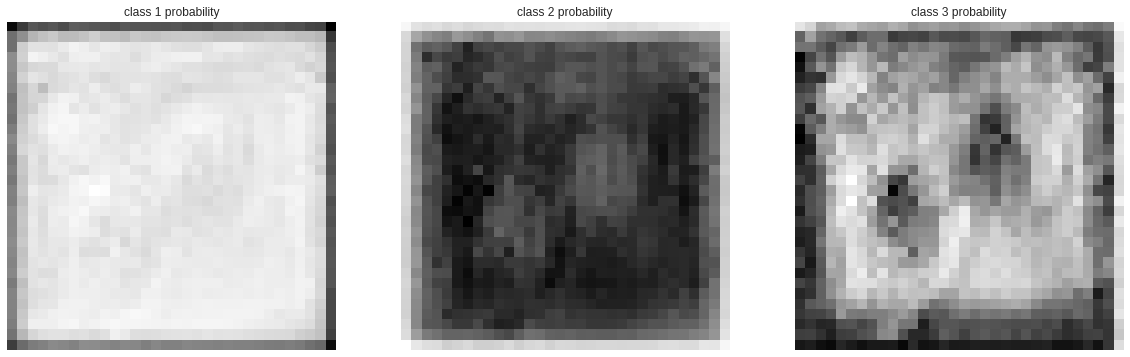

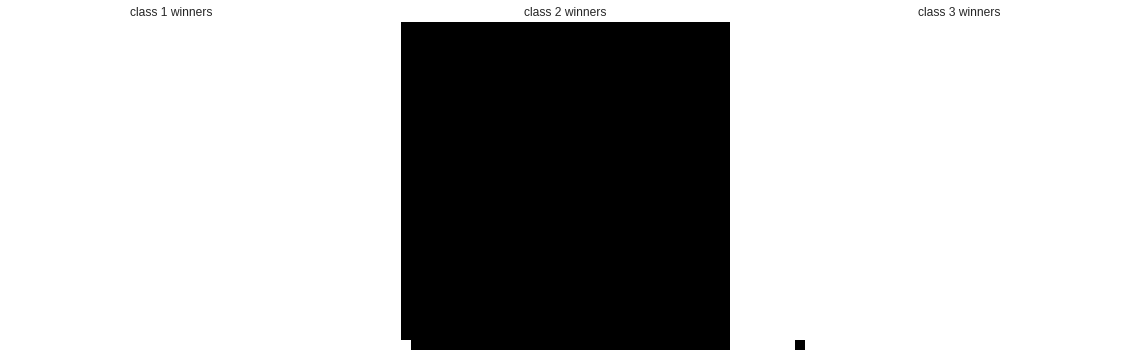

180


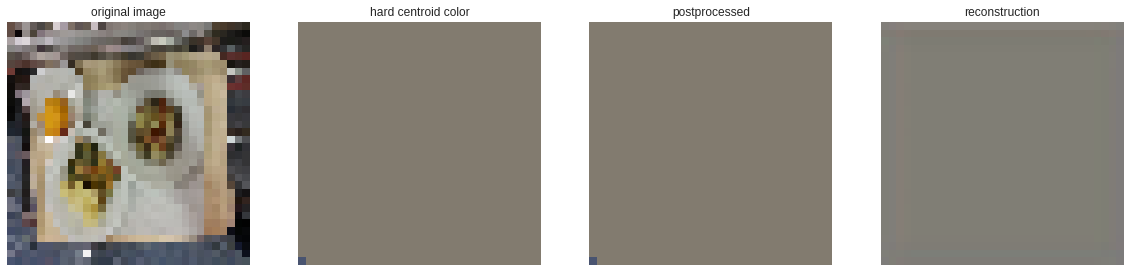

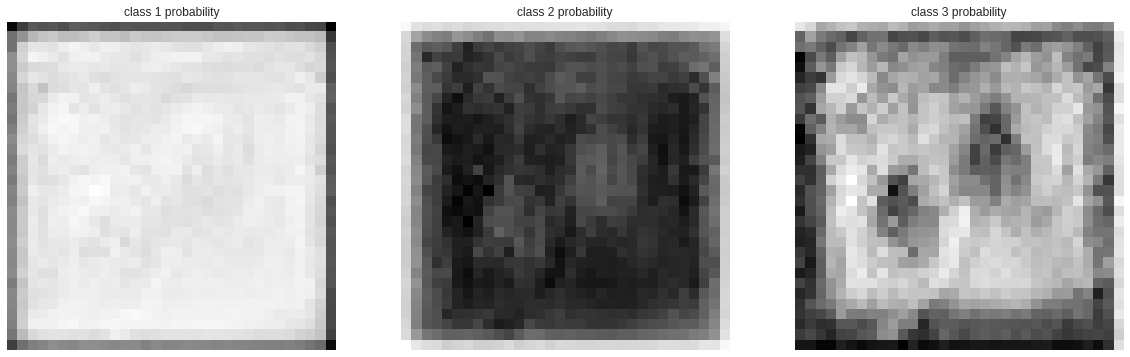

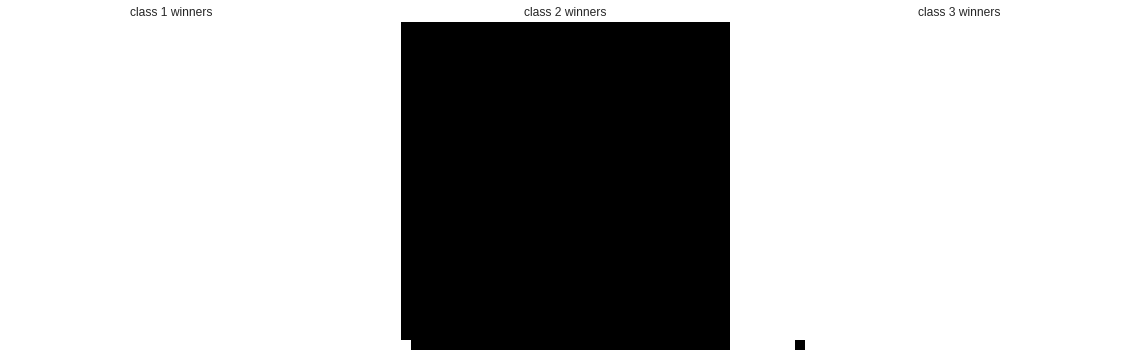

200


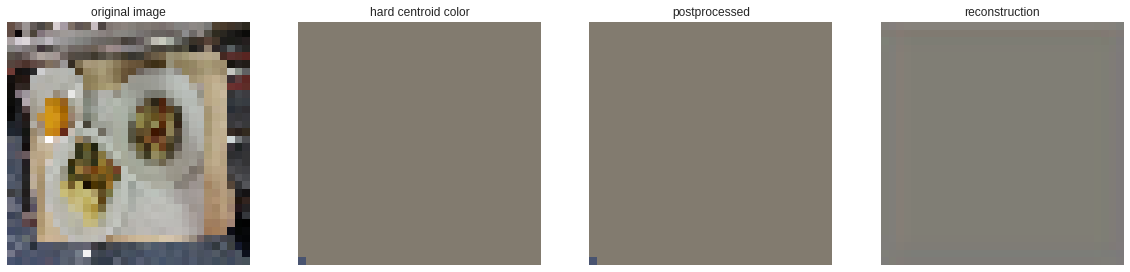

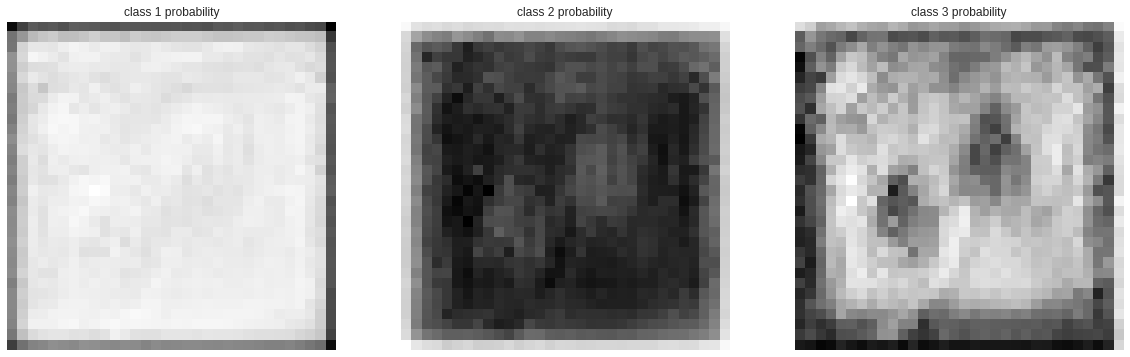

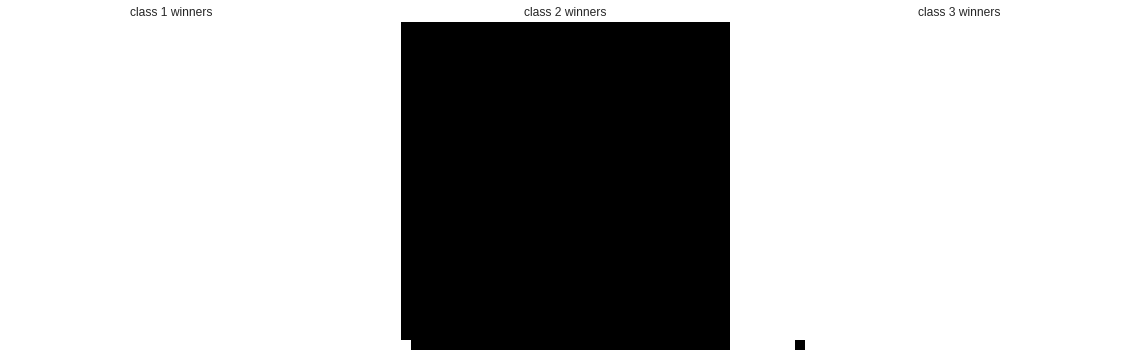

220


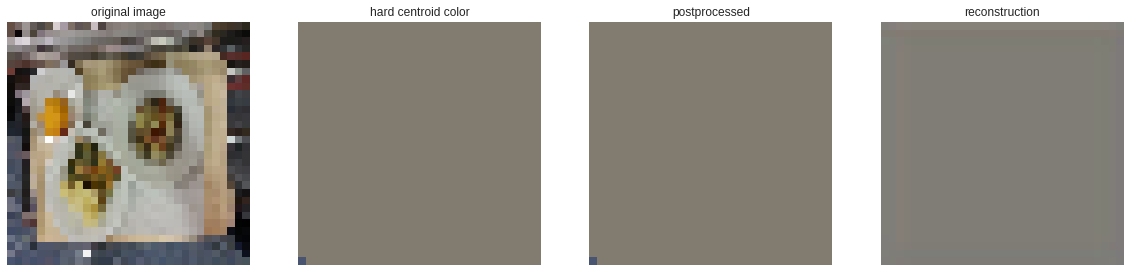

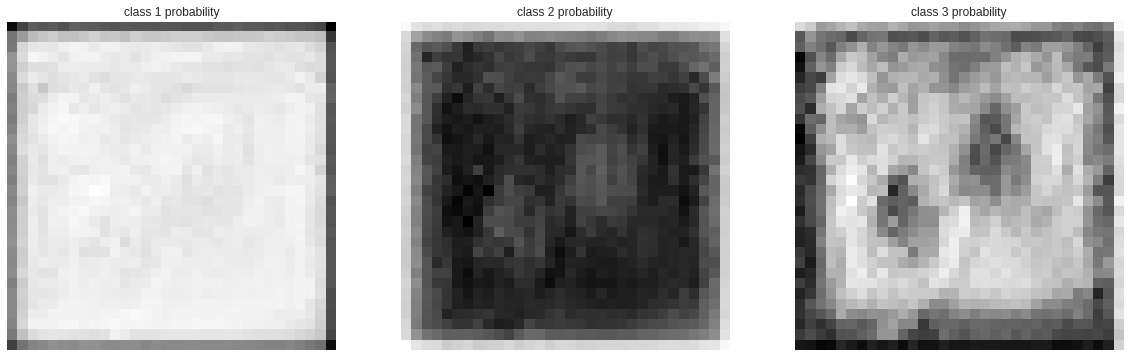

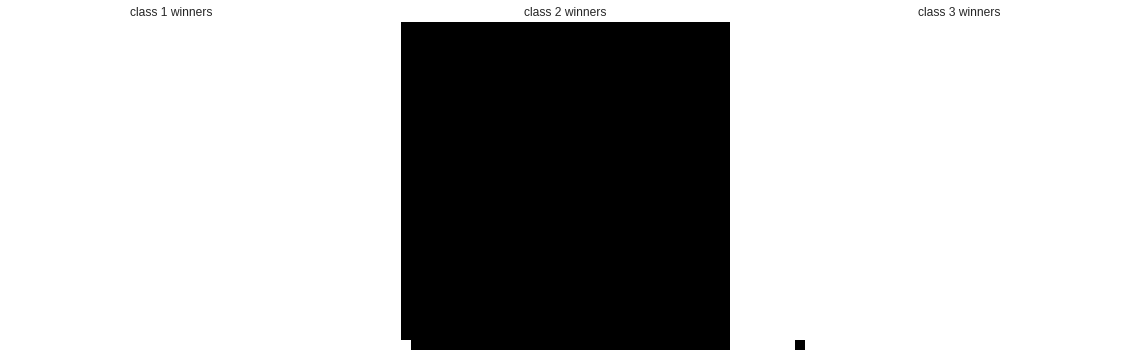

240


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


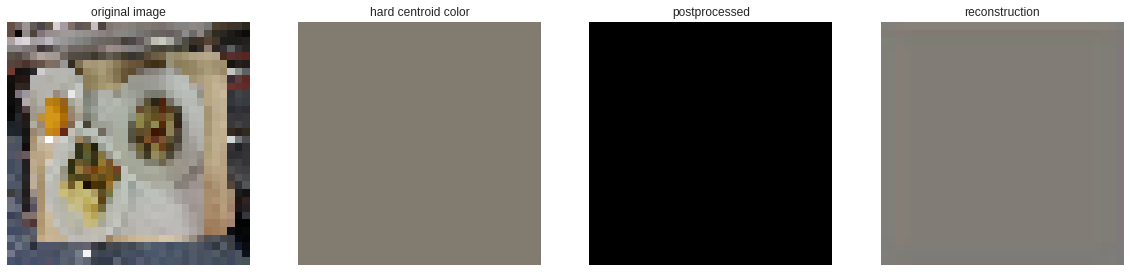

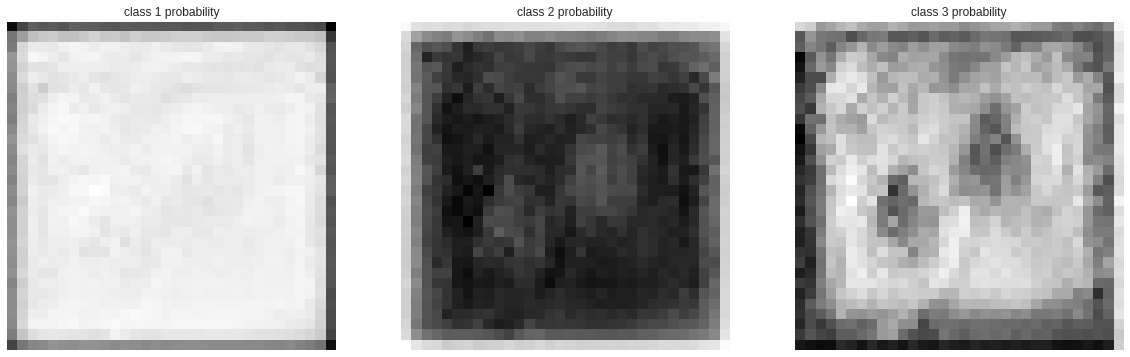

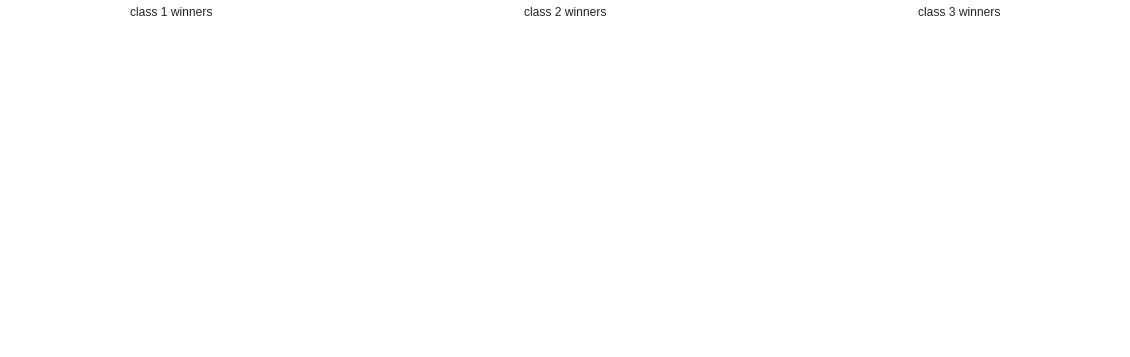

260


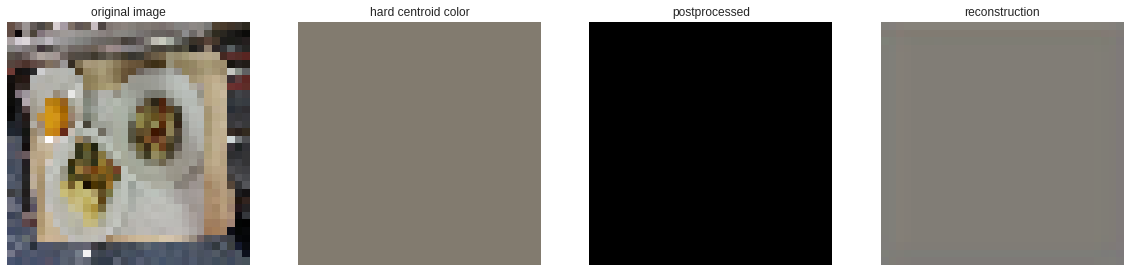

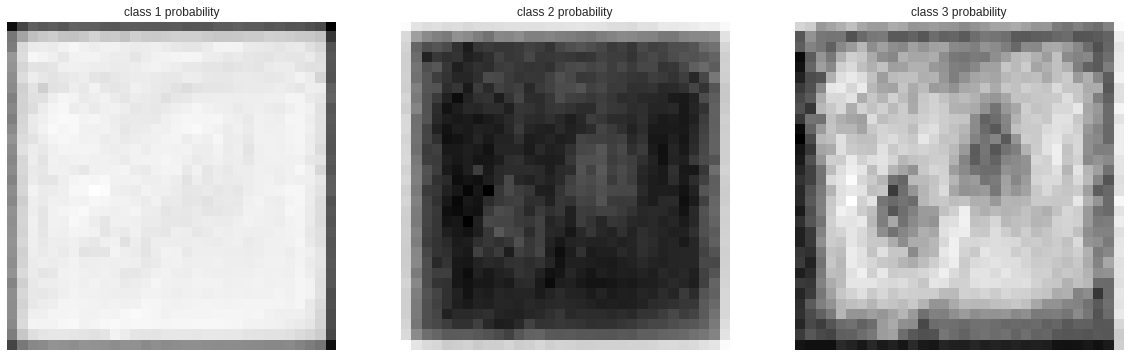

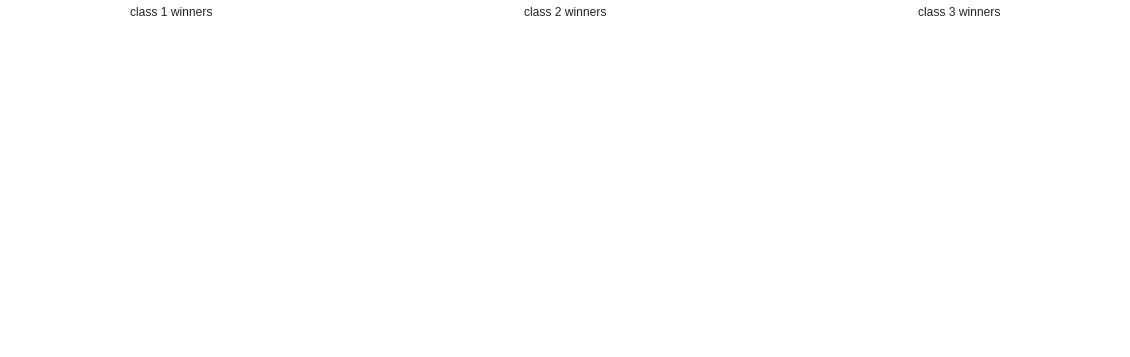

280


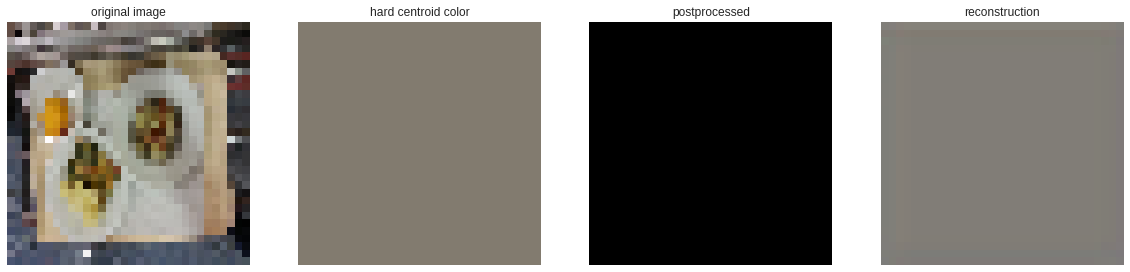

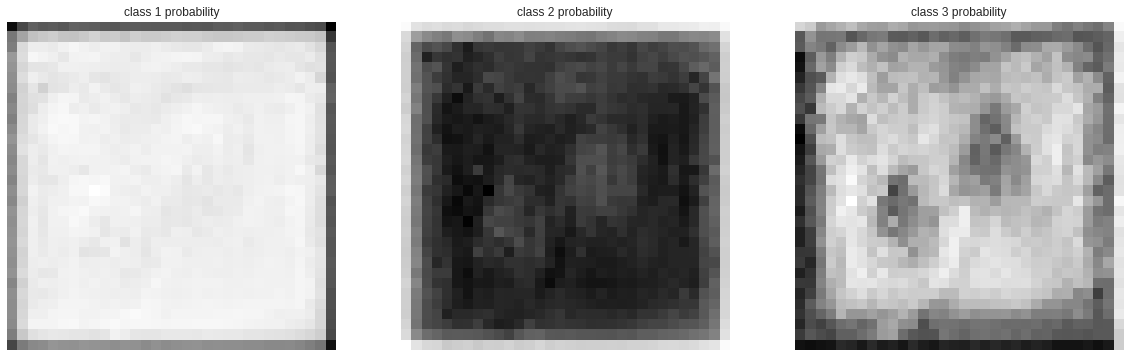

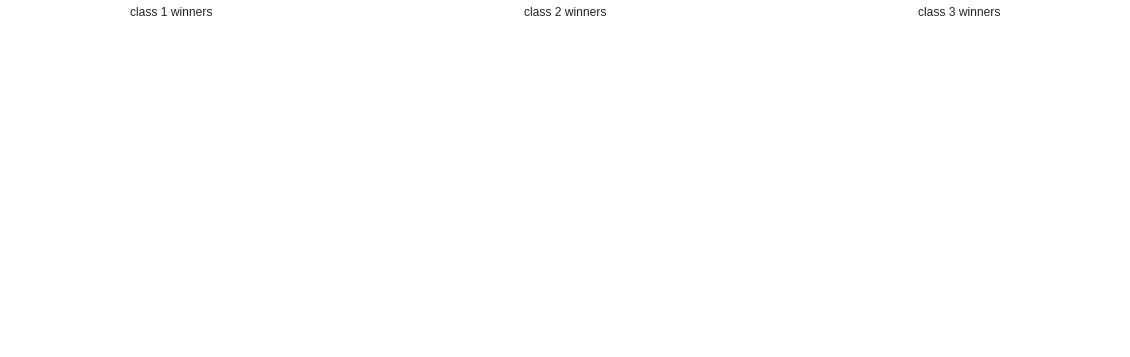

300


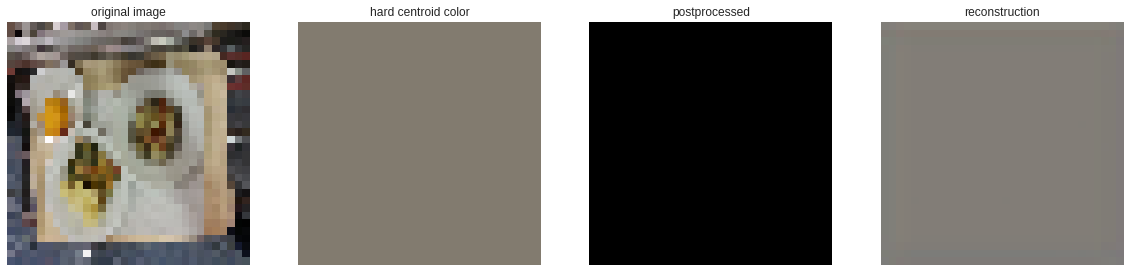

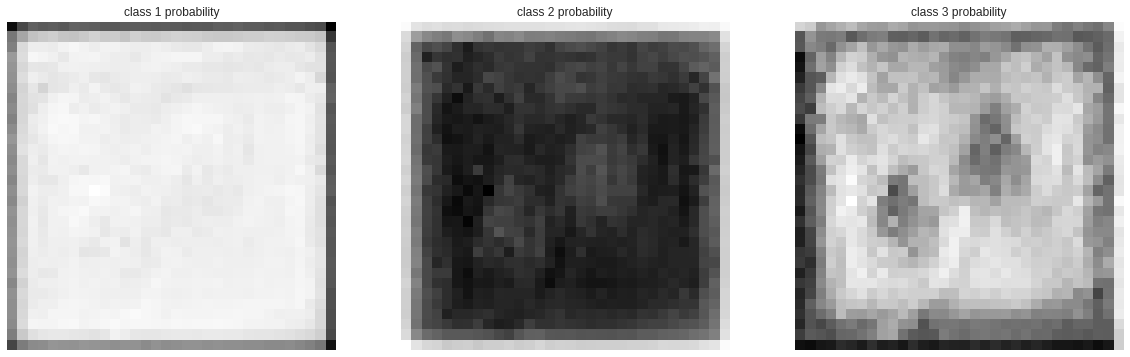

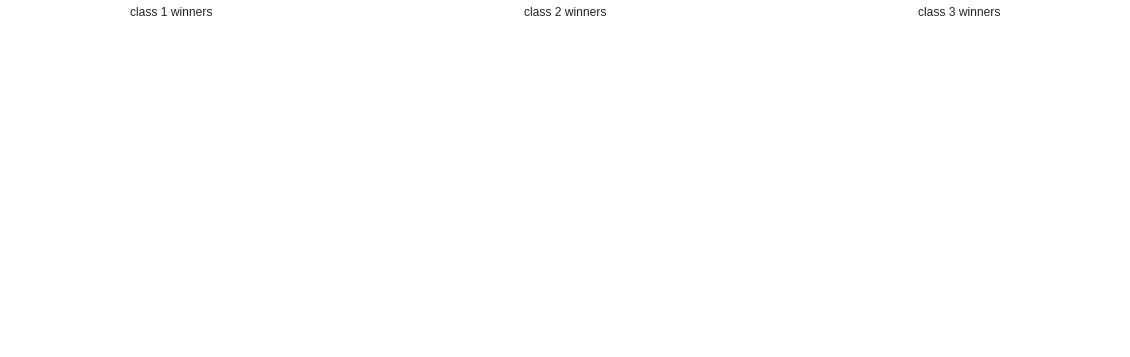

320


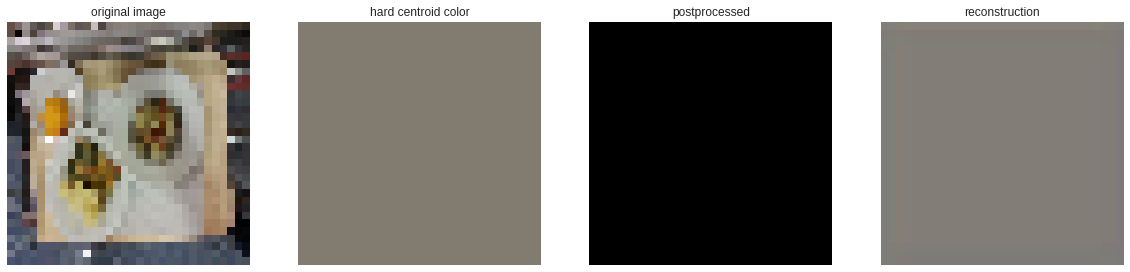

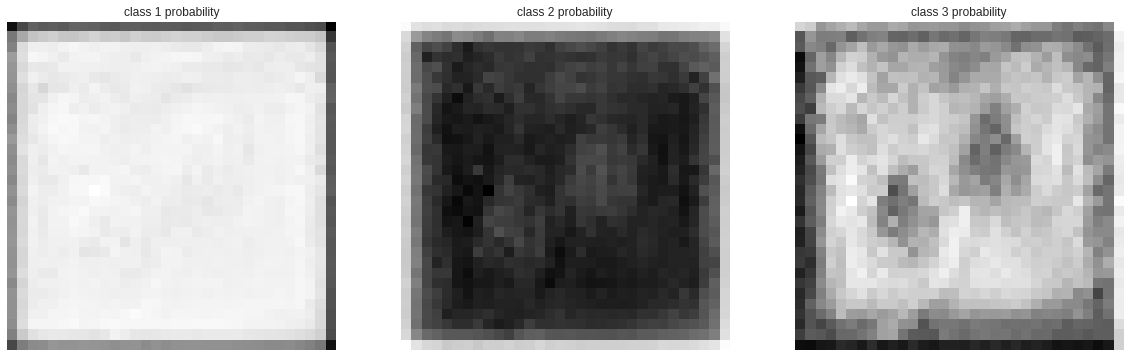

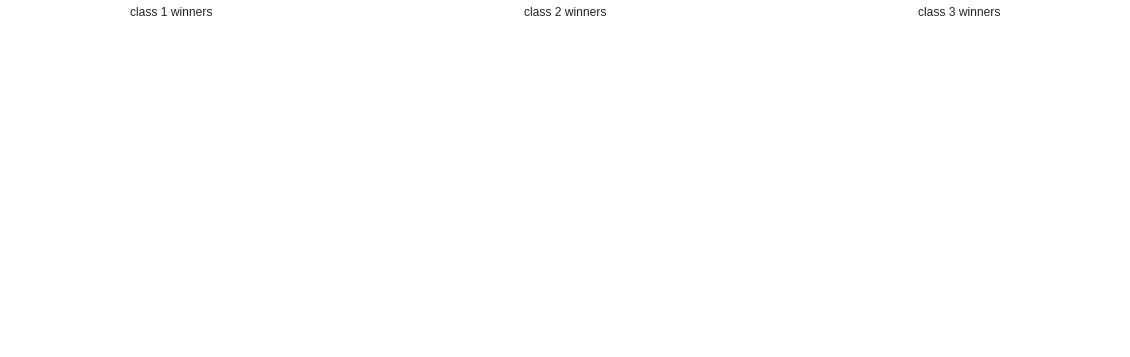

340


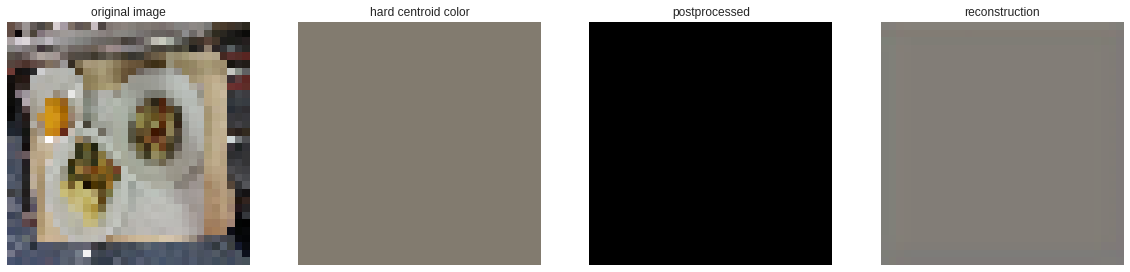

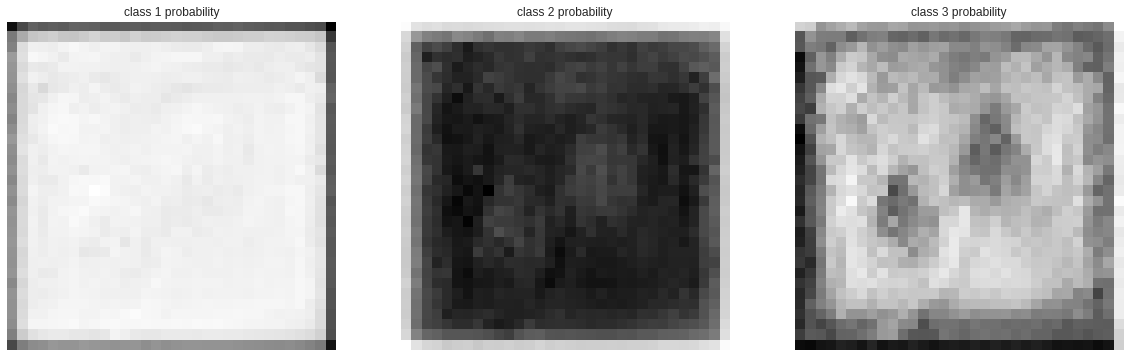

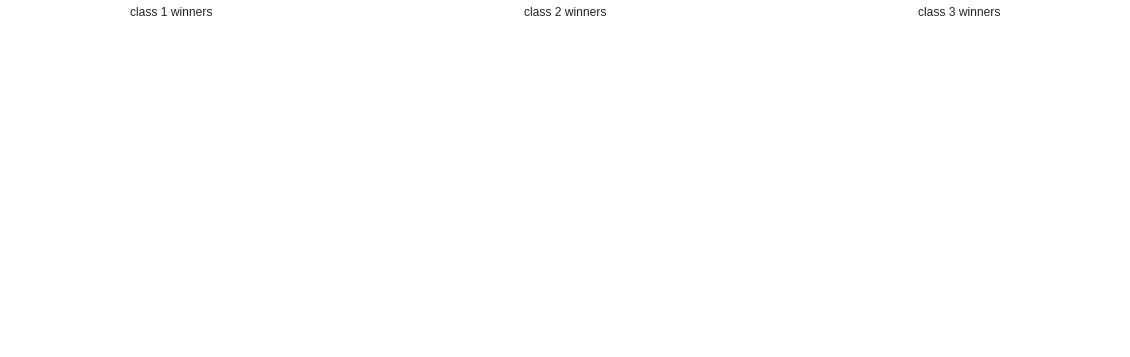

360


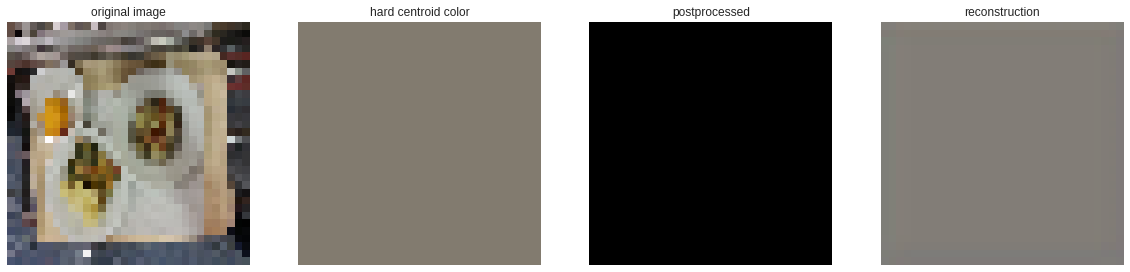

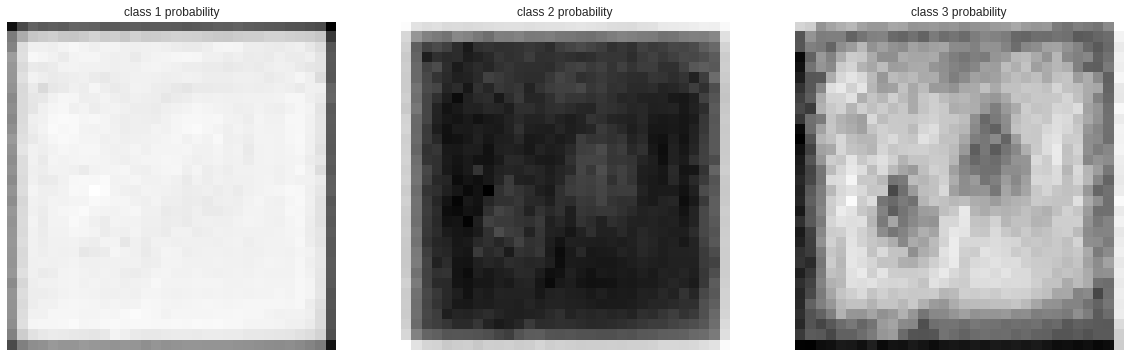

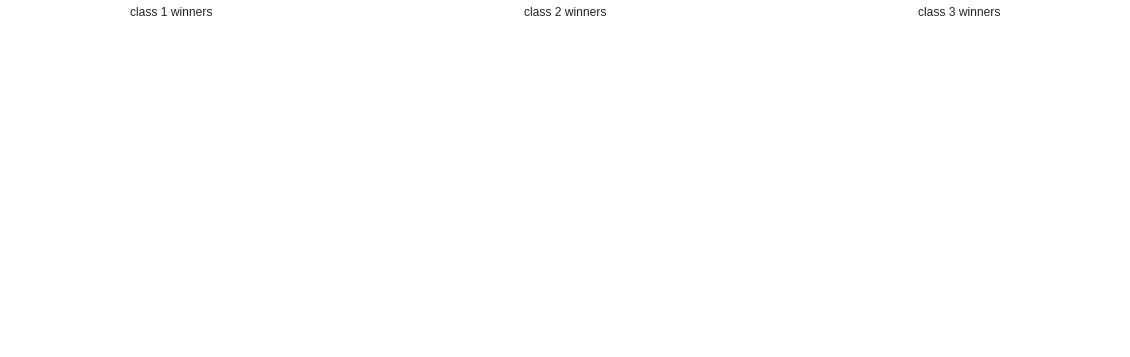

380


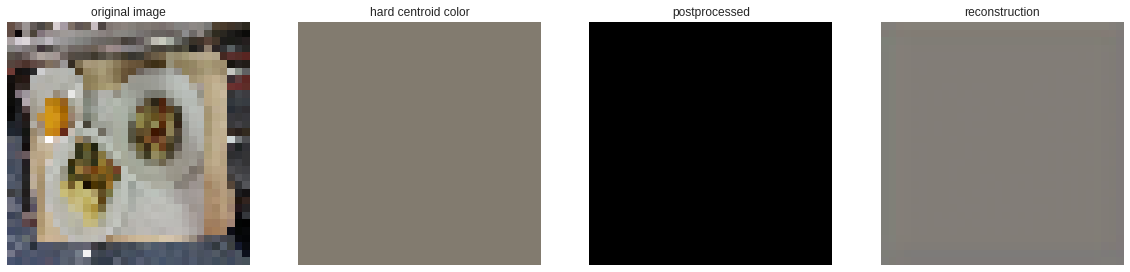

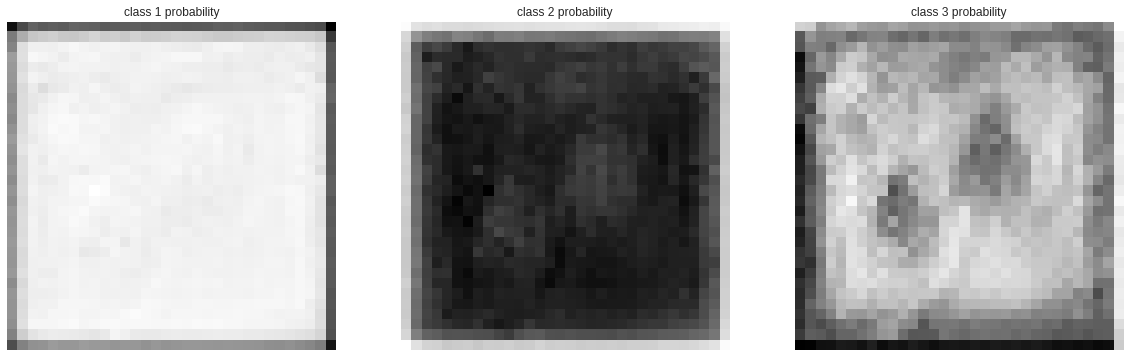

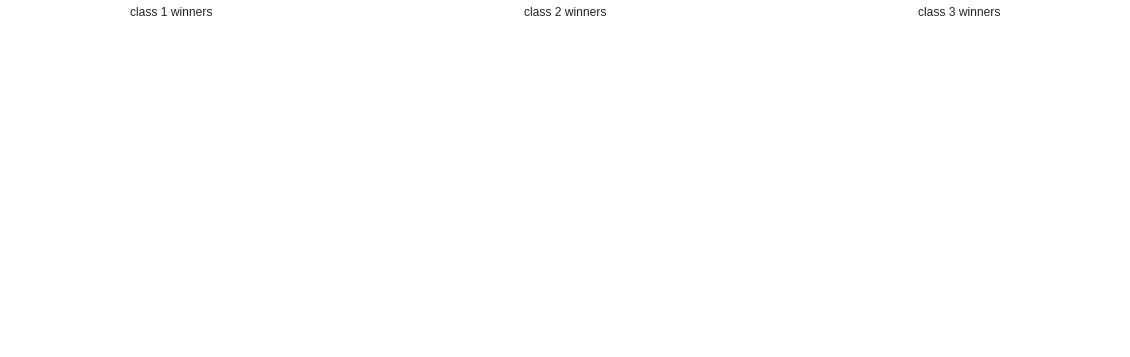

400


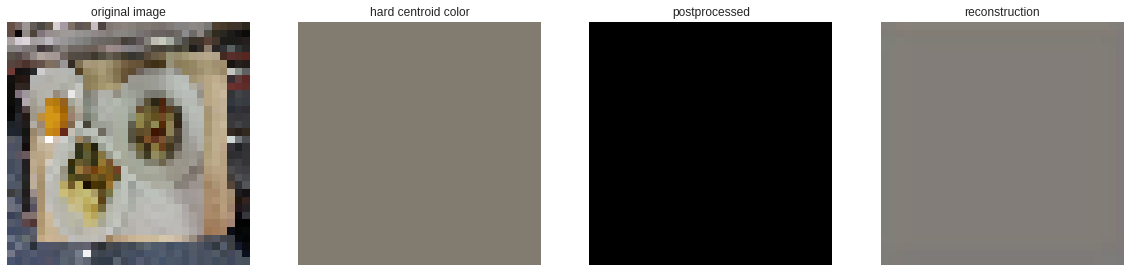

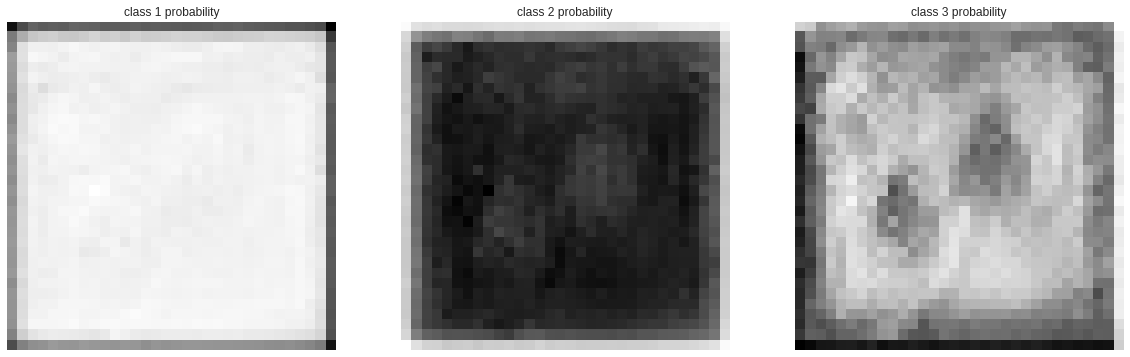

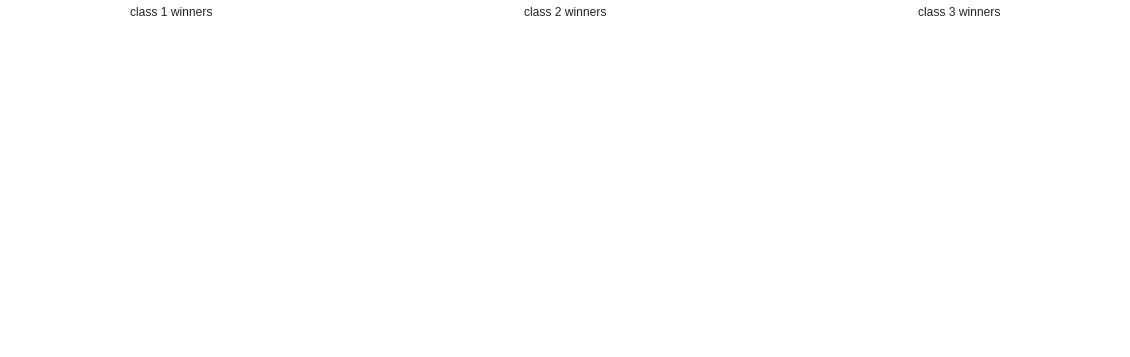

KeyboardInterrupt: ignored

In [0]:
#with sgd
for i in range(1000):
  history = w_net.fit(train_img[:,:,:,:3],[train_img, train_img[:,:,:,:3]],epochs=1, batch_size=1,verbose=0)
  y_s=w_net.predict(train_img[:,:,:,:3],batch_size=1,verbose=0)
  segm = y_s[0][0]
  rec = y_s[1][0]
  if i%20==0:
    print(i)
    paints(img[0],segm,rec)

0


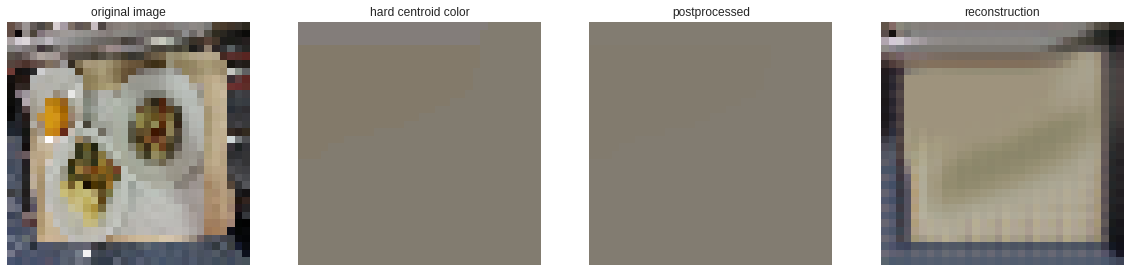

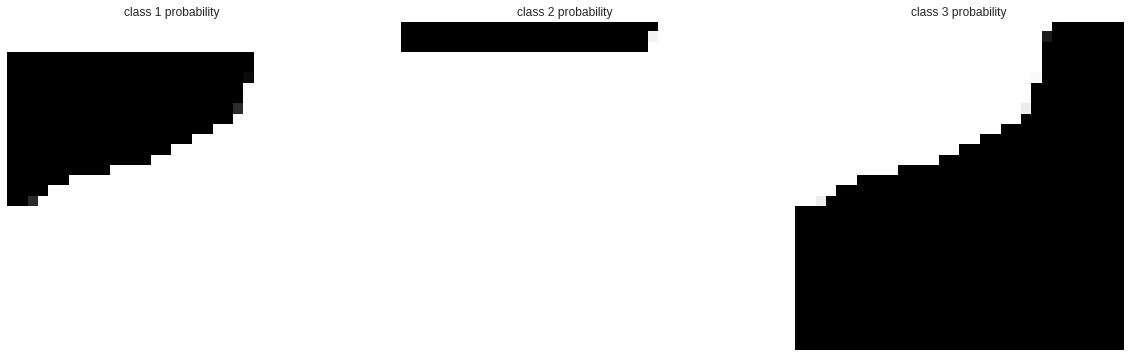

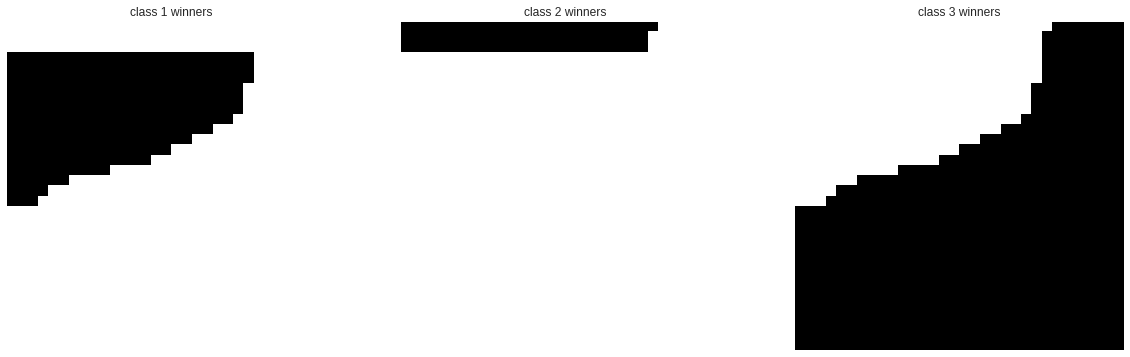

50


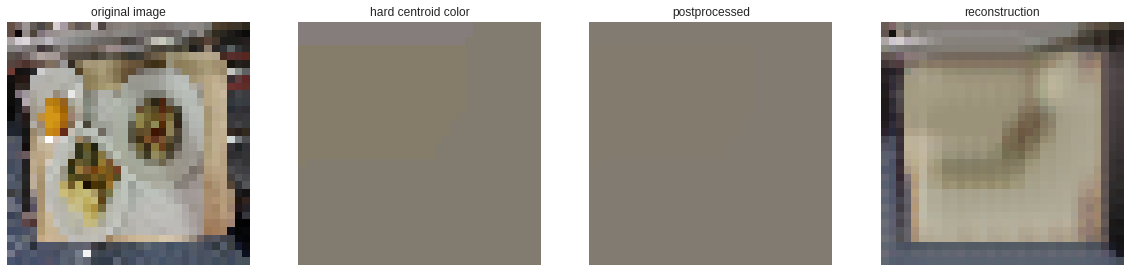

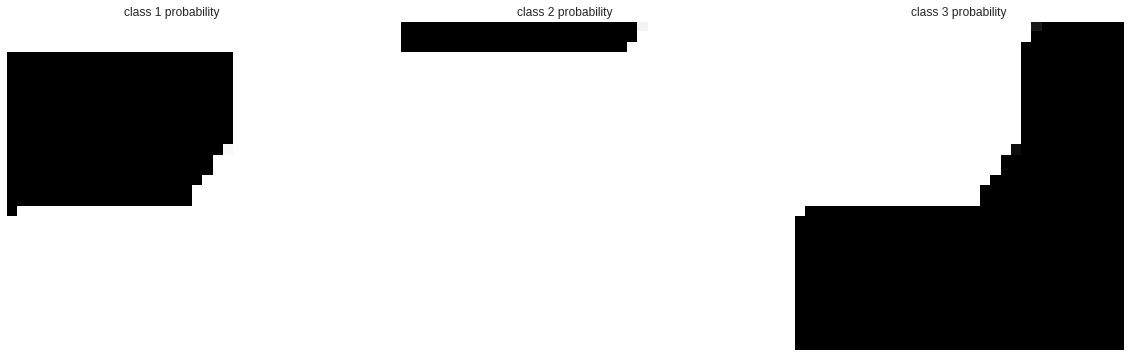

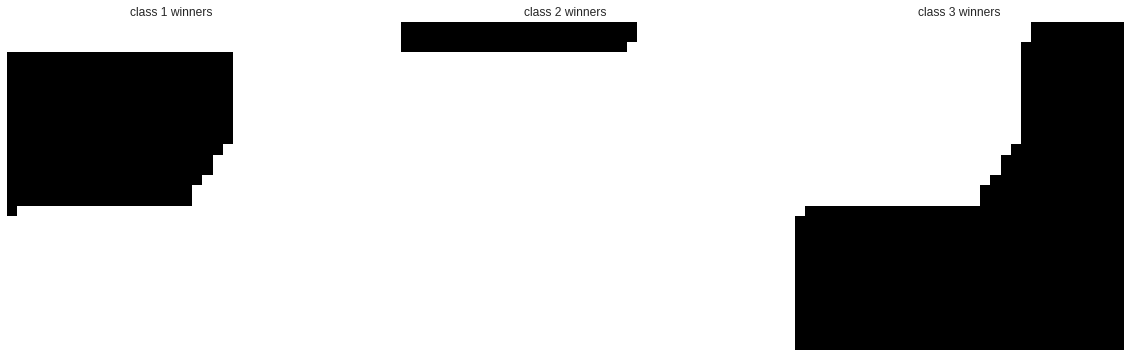

100


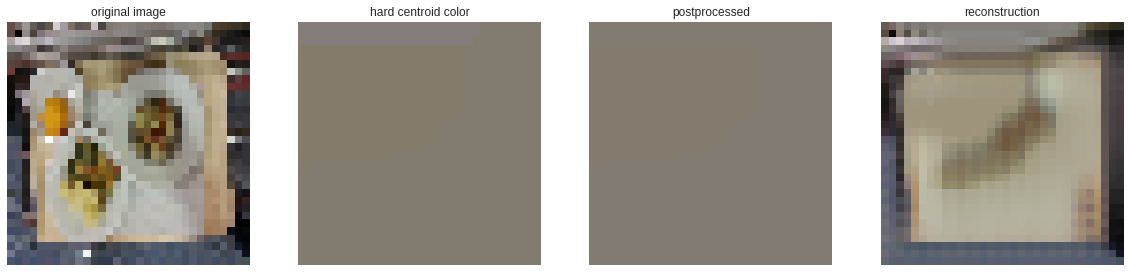

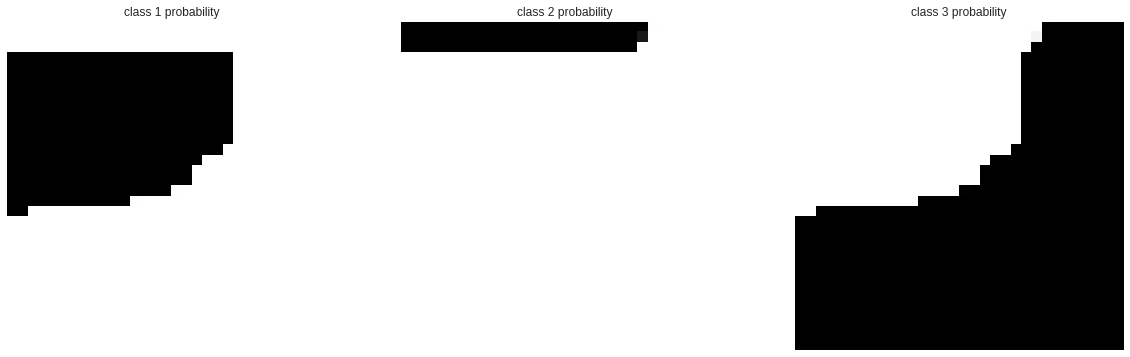

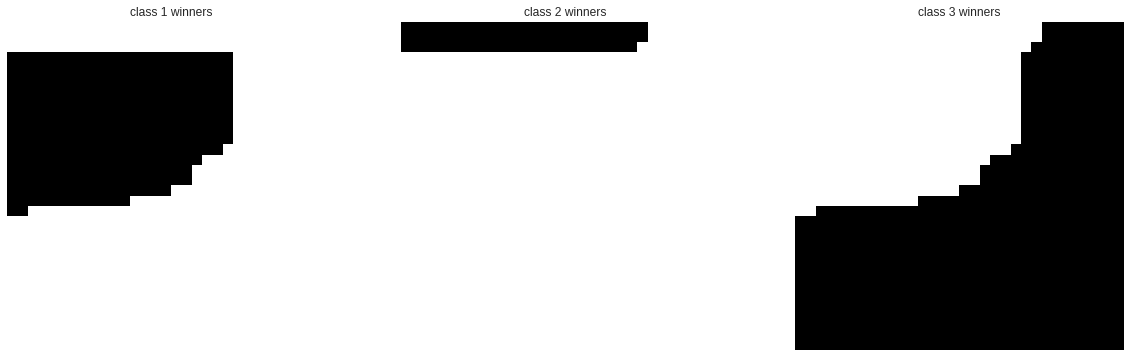

150


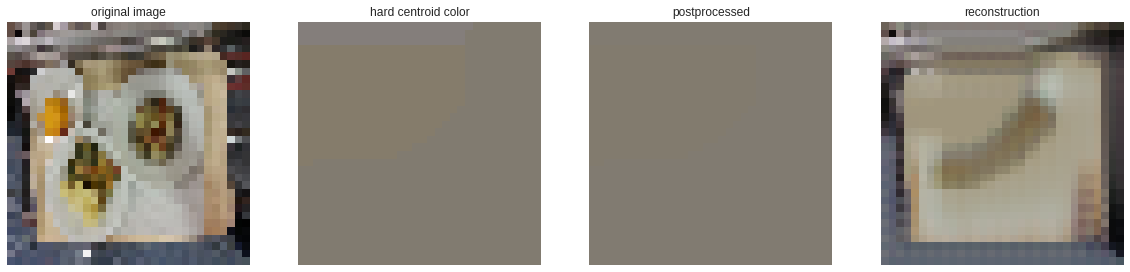

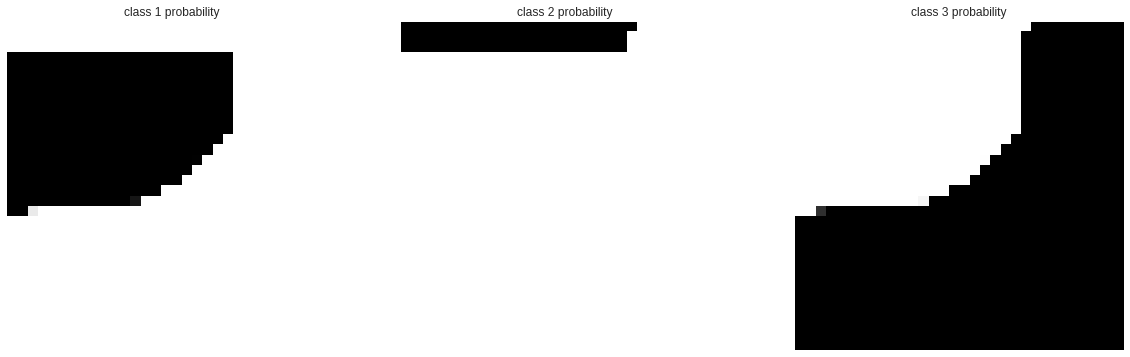

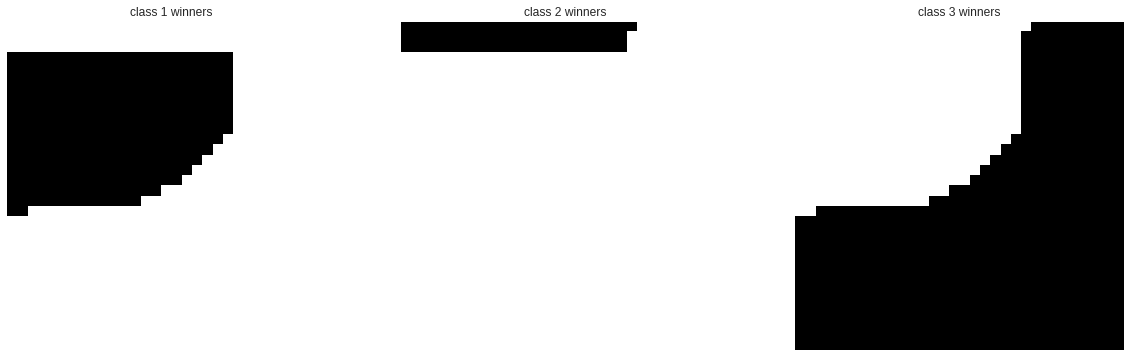

200


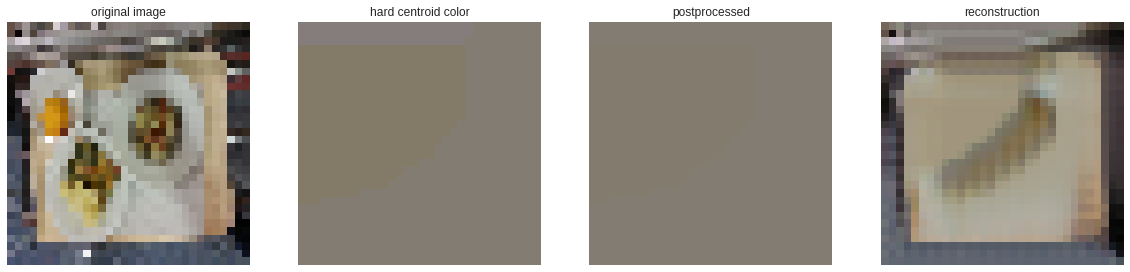

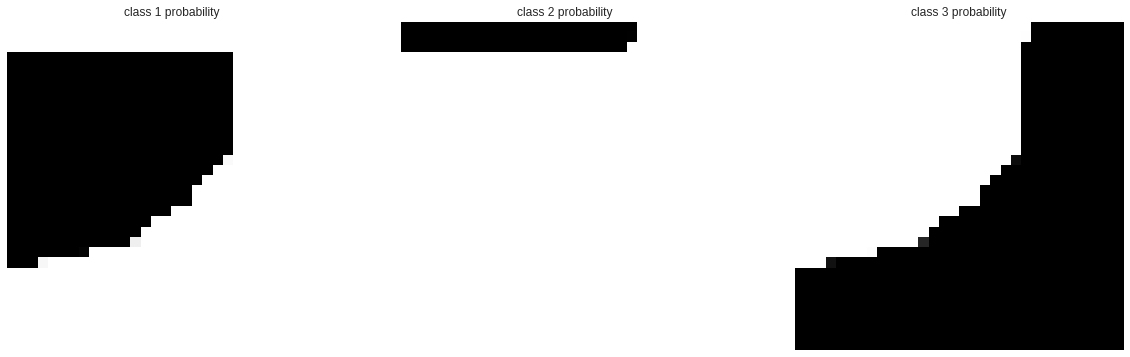

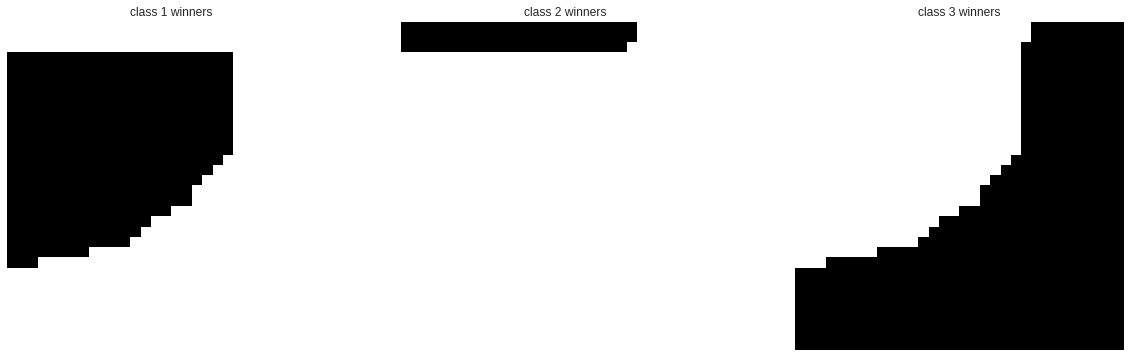

250


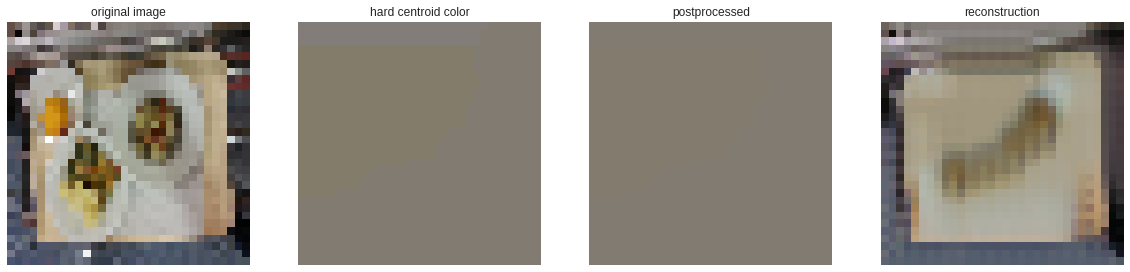

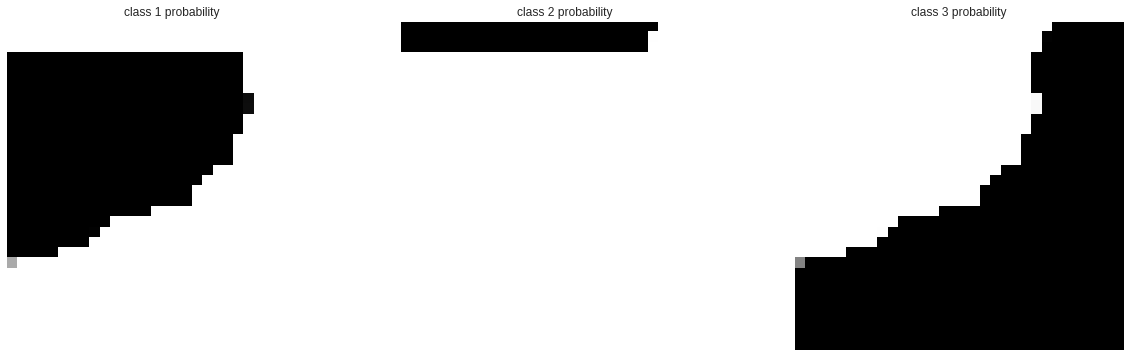

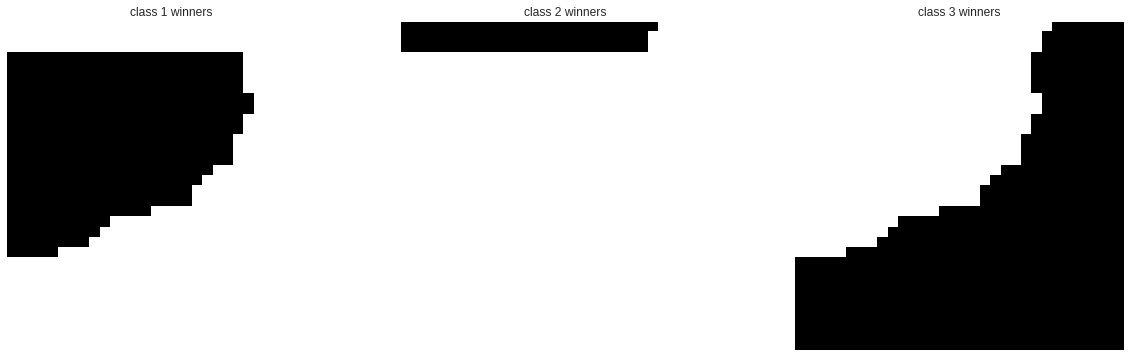

300


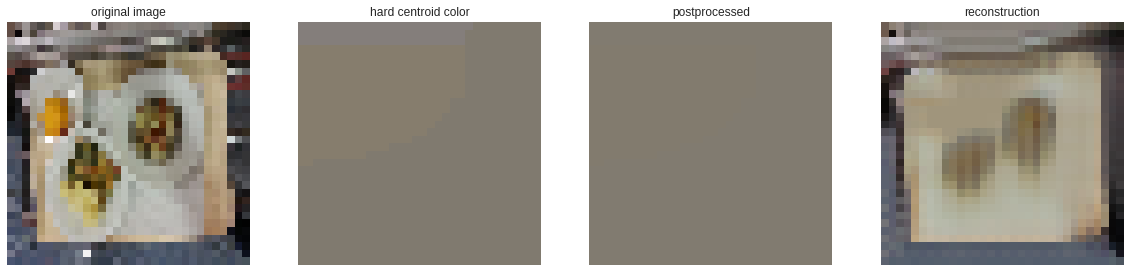

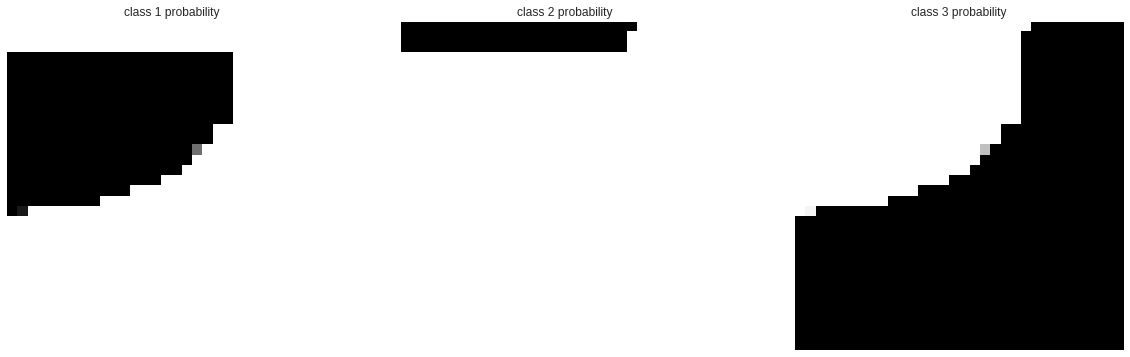

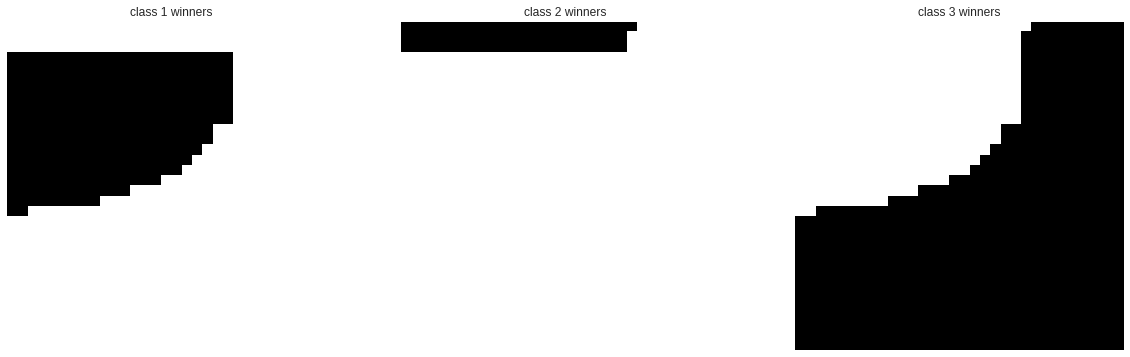

350


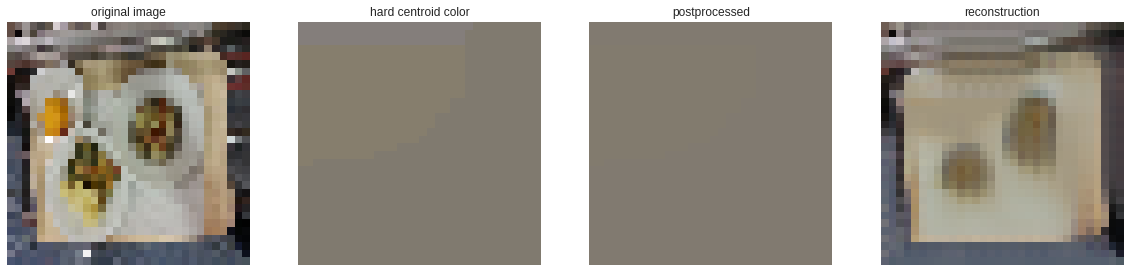

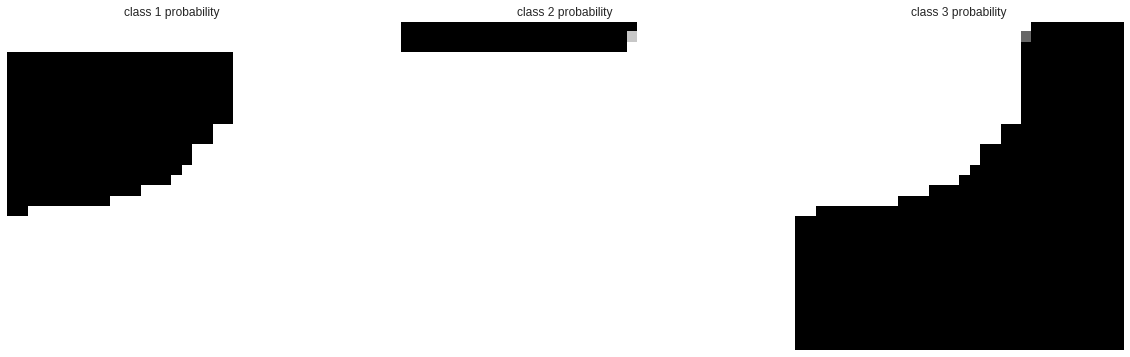

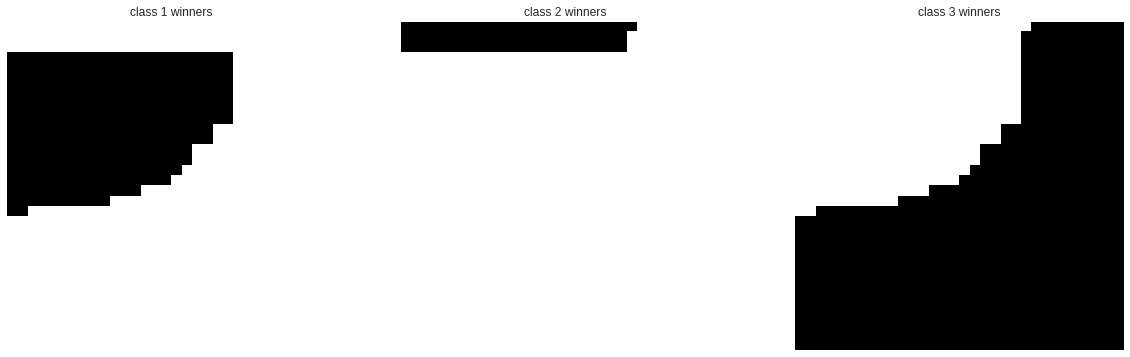

400


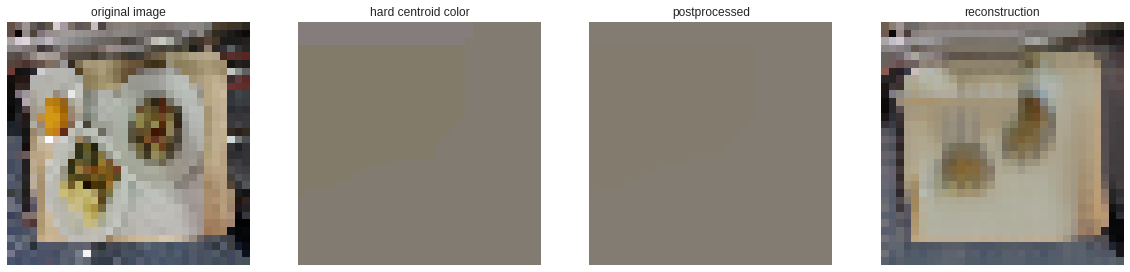

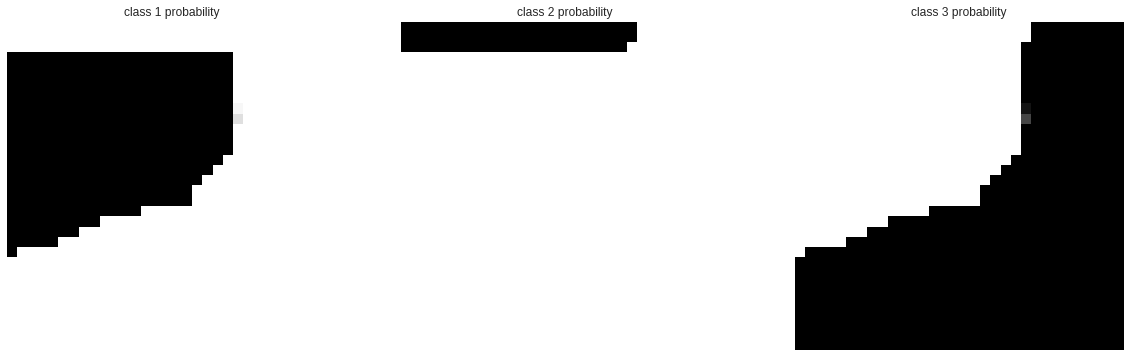

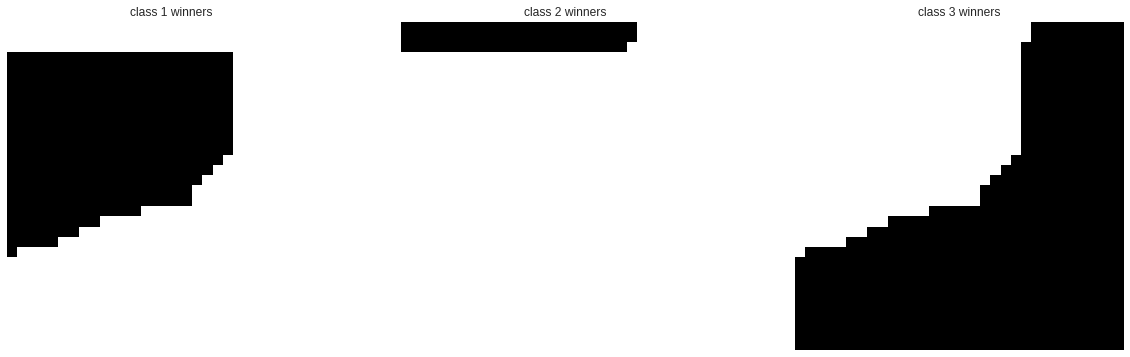

450


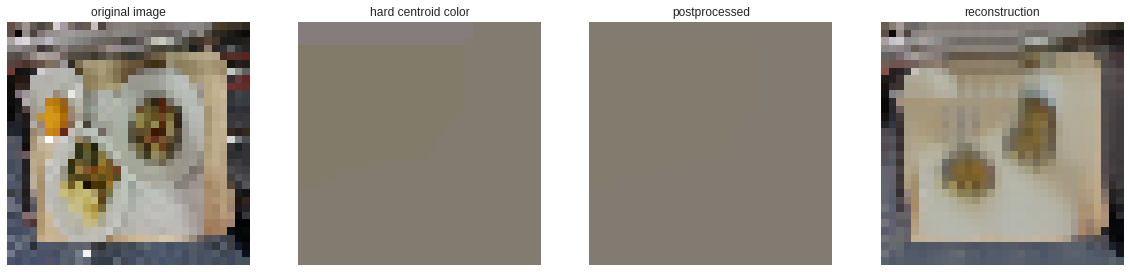

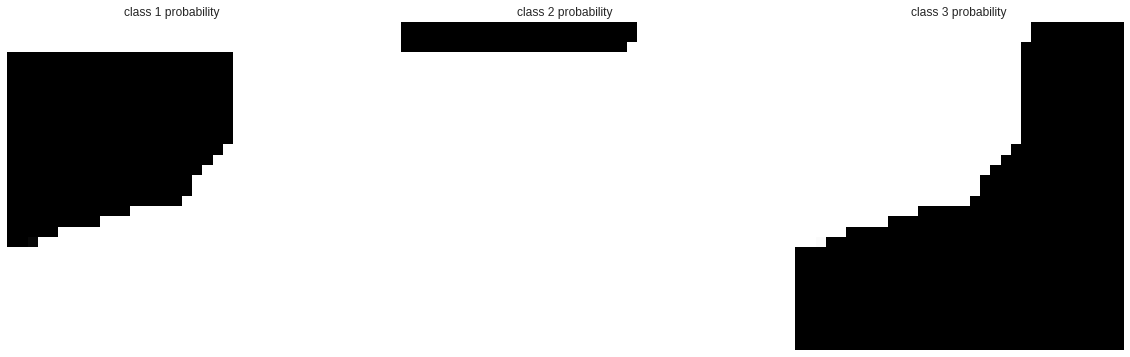

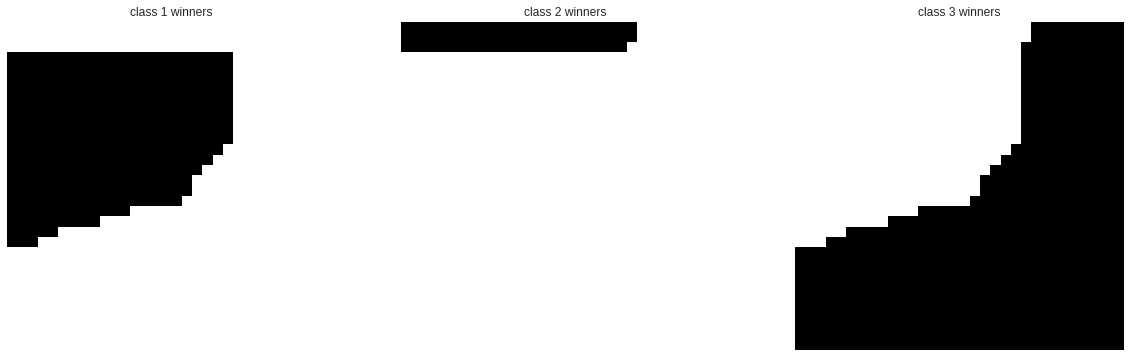

500


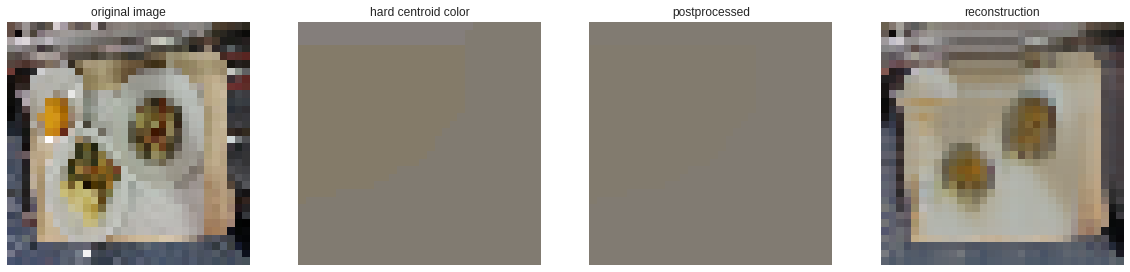

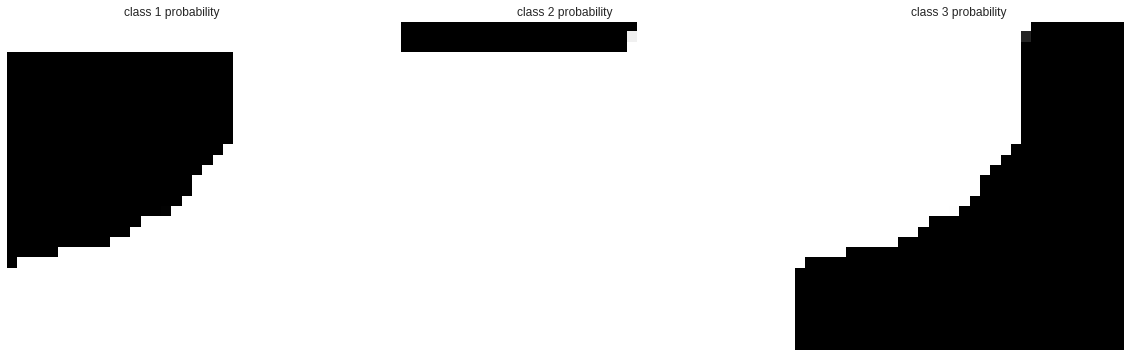

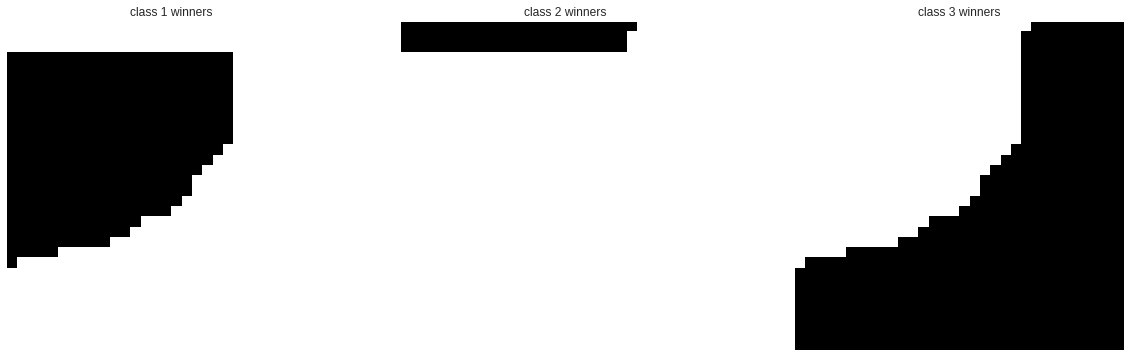

550


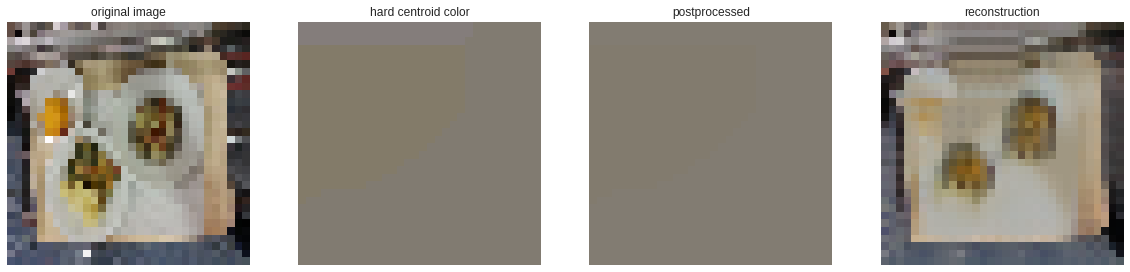

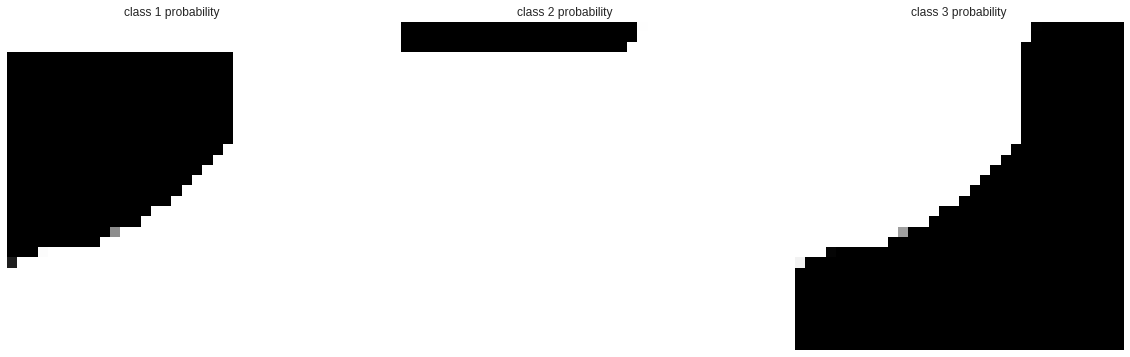

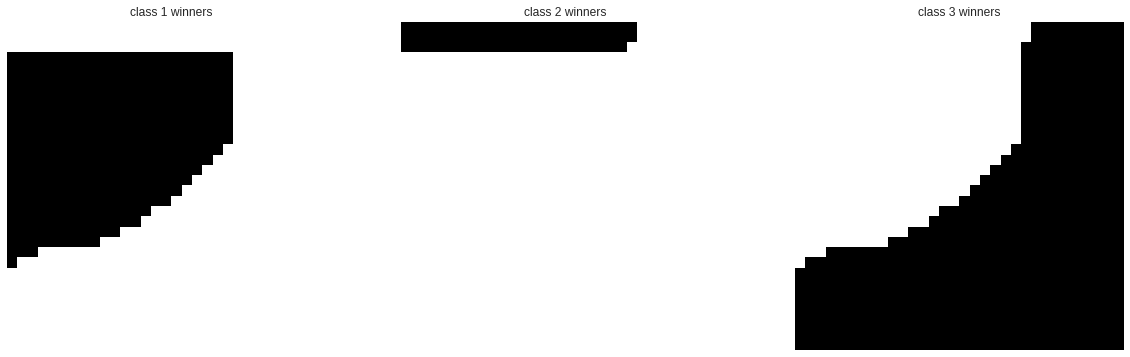

600


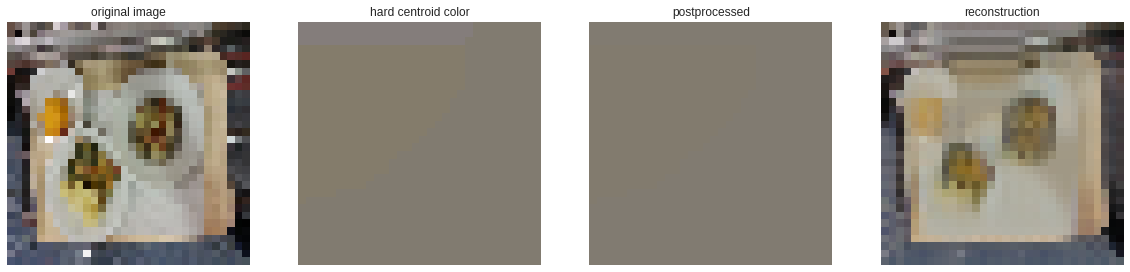

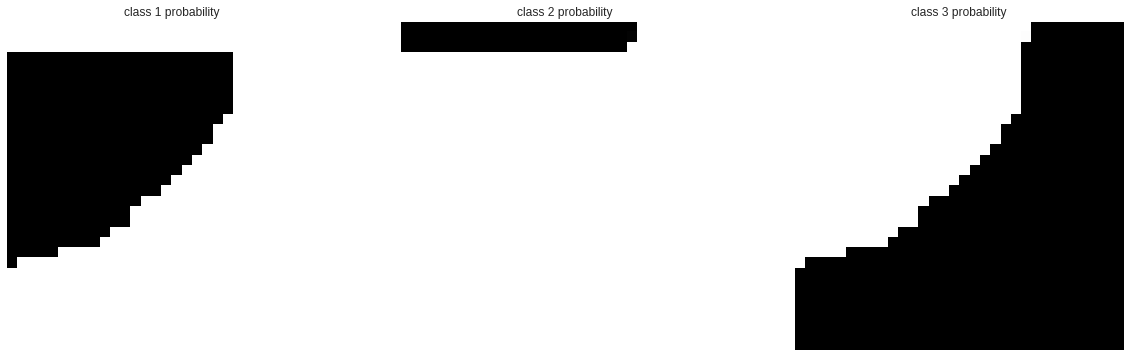

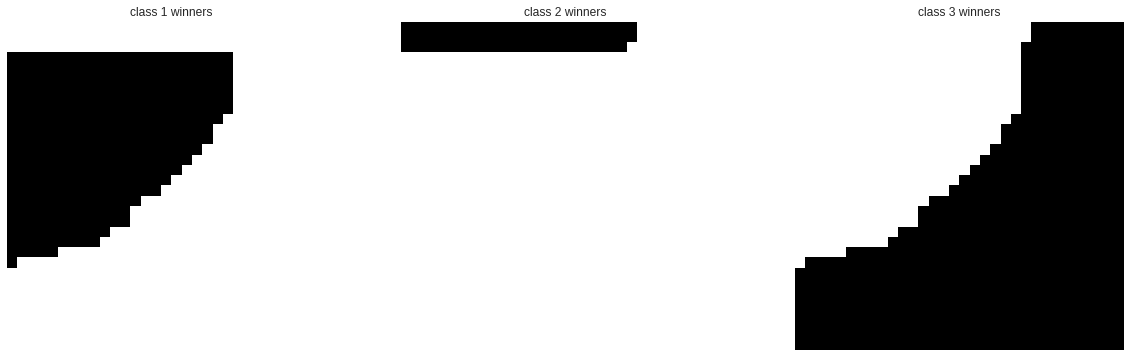

650


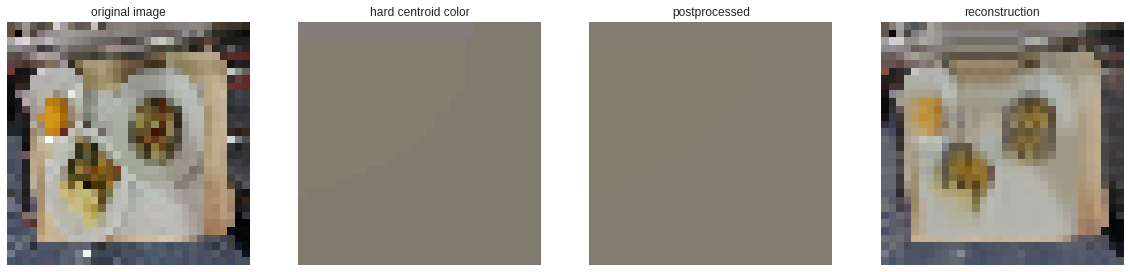

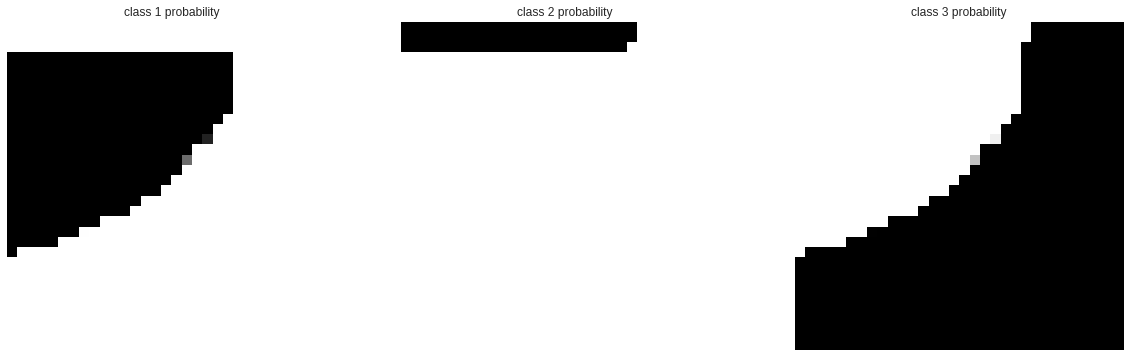

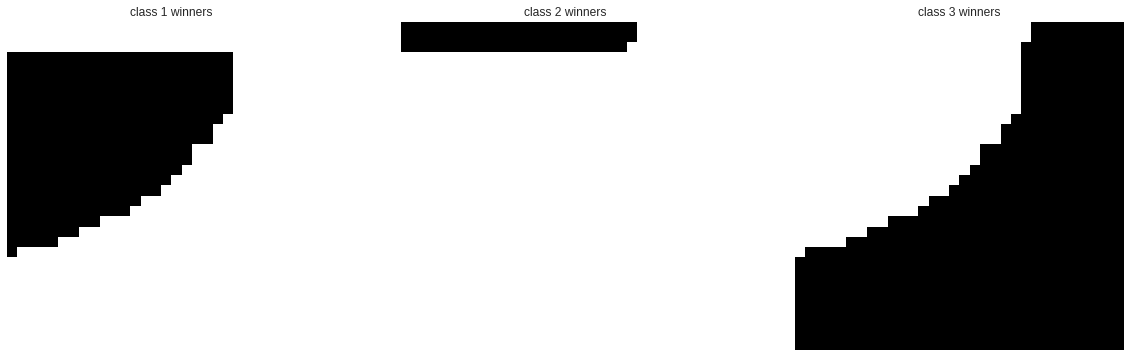

KeyboardInterrupt: ignored

In [0]:
for i in range(1000):
  history = w_net.fit(train_img[:,:,:,:3],[train_img, train_img[:,:,:,:3]],epochs=1, batch_size=1,verbose=0)
  y_s=w_net.predict(train_img[:,:,:,:3],batch_size=1,verbose=0)
  segm = y_s[0][0]
  rec = y_s[1][0]
  if i%50==0:
    print(i)
    paints(img[0],segm,rec)